# OPTIMIZING A PREDICTION PIPELINE BY PREPENDING AN EFFICIENT LOW-FIDELITY MODEL
Consolidated source code to produce graphs and tables in the thesis.

This is shared purely as a reference and to ease reproduction of my results (in other words, not a nice, structured piece of software :))

In [1]:
%matplotlib inline

# Imports of libraries used in this research
import bisect
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scipy as sp
import shap
import simplejson as json
import sklearn as sk
import sys

sys.path.insert(0, os.path.abspath('./packages/sdrmodels'))
from sdrmodels import SDRLookupClassifier, SDRLookupRegressor
from sdrmodels import SDRMeasures

sys.path.insert(0, os.path.abspath('./packages/feature_power'))
from feature_power import regrGBM_FP_agg

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_tree, create_tree_digraph
from numpy import nan, array
from pprint import pprint
from random import random, seed
from scipy.stats.mstats import zscore
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
# explicitly require this experimental feature for HistGradientBoosting...
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsClassifier, RadiusNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils.fixes import loguniform
from time import time
from xgboost import XGBClassifier, XGBRegressor

N_JOBS = 6 # run on 6 (of 8) cores
RAND_STATE = 27 # for reproducibility

figure_path = '../latex/figures/'

# 3. Dataset

## 3.2 Dataset Size and Verdict Distribution

In [2]:
# Load data
fullDF = pd.read_pickle('../data/deduped_dataframe.pkl')
X = fullDF.filter(regex='feature\.|(spf|dkim|dmarc)\.(align|pass)', axis=1).astype('int')
X_list = fullDF.filter(regex='feature_list', axis=1)
yS = fullDF['target_score'].astype('float')
yV = fullDF['target_verdict'].astype('category')
(num_data, num_dims) = X.shape
unique_yX = pd.concat([yV, X], axis=1).drop_duplicates().shape[0]
unique_X = X.drop_duplicates().shape[0]
print(f'Data-set size: {num_data} records ({unique_yX} unique yX, {unique_X} unique X), {num_dims} features')

Data-set size: 131973 records (34336 unique yX, 24407 unique X), 252 features


In [3]:
# Creating targets for the different models
yV_A = pd.Series(['-' if v == '-' else '+' for v in yV])
yV_C = pd.Series(['+' if v == '+' else '-' for v in yV])
yV_T = yV

# Splitting out data beyond the first 100k as validation set.
n_train = 100000
X_validation = X[n_train+1:]
X_list_validation = X_list[n_train+1:]
yV_A_validation = yV_A[n_train+1:]
yV_C_validation = yV_C[n_train+1:]
yV_T_validation = yV_T[n_train+1:]
yS_validation = yS[n_train+1:]
n_validation = yS_validation.shape[0]

X = X[0:n_train]
X_list = X_list[0:n_train]
yV_A = yV_A[0:n_train]
yV_C = yV_C[0:n_train]
yV_T = yV_T[0:n_train]
yS = yS[0:n_train]

In [4]:
# Verdict distribution
(sum([s=='+' for s in yV_T])/len(yV_A), sum([s=='?' for s in yV_T])/len(yV_A), sum([s=='-' for s in yV_T])/len(yV_A), sum([s=='+' for s in yV_A])/len(yV_A))

(0.33577, 0.17453, 0.4897, 0.5103)

In [5]:
# Example data points
orig_val = pd.get_option('display.max_columns')
pd.set_option('display.max_columns', 10)
pd.concat([yV, yS, X], axis=1).loc[0:4,:]
#pd.set_option('display.max_columns', orig_val)

,target_verdict,target_score,dmarc.align,spf.align,envFrom.feature.0,...,listUnsub.feature.53,listUnsub.feature.54,listUnsub.feature.55,listUnsub.feature.60,listUnsub.feature.63
0,-,0.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0
1,-,0.000366,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0
2,?,0.773266,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0
3,-,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
4,+,0.997513,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0


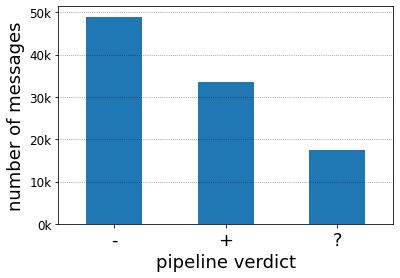

In [6]:
yV_T.value_counts().plot(kind='bar')
plt.xlabel('pipeline verdict', fontsize=18)
plt.ylabel('number of messages', fontsize=18)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=12, ticks=[t for t in range(0,50001,10000)], labels=[f'{int(t/1000)}k' for t in range(0,50001,10000)])
plt.grid(axis='y', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_verdict_hist.pdf', bbox_inches='tight', pad_inches=0)

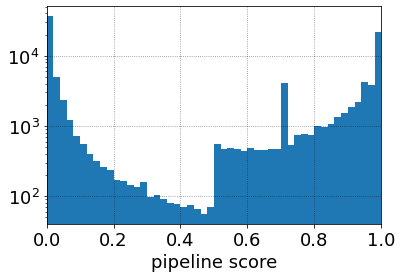

In [7]:
yS.hist(bins=50, grid=False)
plt.xlabel('pipeline score', fontsize=18)
plt.xlim([0,1])
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_score_hist.pdf', bbox_inches='tight', pad_inches=0)

# 4. Theoretical Considerations

## 4.2 Adding an Engine to the Pipeline

#### 4.2.2.3 Joined Optimization Using ROC-Curve Analysis

In [8]:
# Utility function definitions
def roc_b(fpr, tpr, Neg, Pos):
    return (tpr*Pos + fpr*Neg)/(Pos+Neg)

def tpr_thresh_throughput(fpr, bmin, Neg, Pos):
    return Neg*(bmin*(Pos+Neg)/Neg - fpr)/Pos

def roc_tcr(fpr, tpr, lmbda, Neg, Pos):
    return 1/(1 + lmbda*Neg*fpr/Pos - tpr)

def tpr_thresh_accuracy(fpr, lmbda, Neg, Pos):
    return lmbda*Neg*fpr/Pos

def roc_utility(fpr, tpr, eta, lmbda, Neg, Pos):
    return eta*roc_b(fpr, tpr, Neg, Pos) + (1-eta)*(tpr - lmbda*Neg*fpr/Pos)#(1-1/roc_tcr(fpr, tpr, lmbda, Neg, Pos))

def max_util_vals(true_verdicts, predicted_scores, bmin, eta, lmbda, Neg, Pos, pos_label=1):
    # Maximum (valid) utility,fpr/tpr,rho

    (roc_p_fpr,
     roc_p_tpr,
     roc_p_thresholds) = roc_curve(true_verdicts, predicted_scores, pos_label=pos_label)

    util_values = [(True,
                    roc_utility(fpr, tpr, eta, lmbda, Neg, Pos),
                    thr, fpr, tpr, roc_tcr(fpr, tpr, lmbda, Neg, Pos))
                   if (tpr>tpr_thresh_throughput(fpr, bmin, Neg, Pos) and
                       tpr>tpr_thresh_accuracy(fpr, lmbda, Neg, Pos))
                   else
                   (False,
                    roc_utility(fpr, tpr, eta, lmbda, Neg, Pos),
                    thr, fpr, tpr, roc_tcr(fpr, tpr, lmbda, Neg, Pos))
                   for (thr, fpr, tpr) in zip(roc_p_thresholds, roc_p_fpr, roc_p_tpr)]

    best_util = (nan, nan, nan, nan, nan)
    best_valid_util = (nan, nan, nan, nan, nan)
    for u in util_values:
        valid = u[0]
        values = u[1:]
        if values[0]>best_util[0] or best_util[0] is nan:
            best_util = values
        if valid:
            if values[0]>best_valid_util[0] or best_valid_util[0] is nan:
                best_valid_util = values

    return best_util, best_valid_util

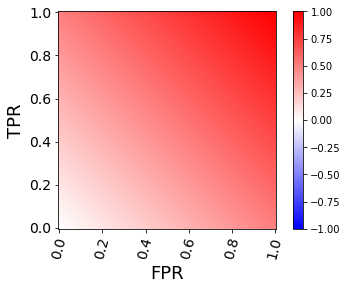

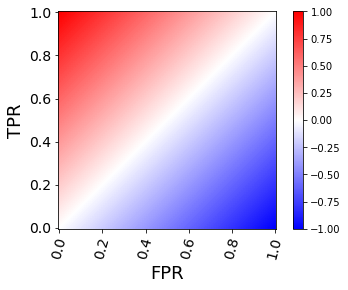

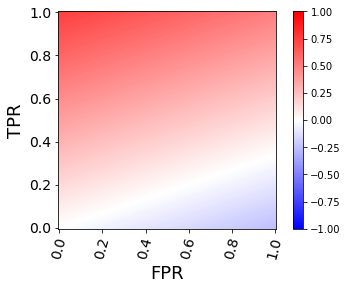

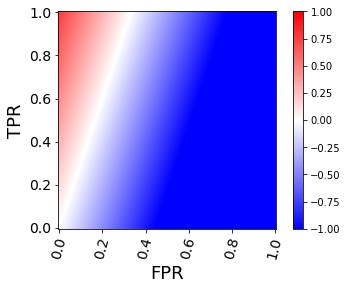

In [9]:
# Overview of utility function for various parameters

# Grid
fprs = [i/100 for i in range(0,101)]
tprs = [1-i/100 for i in range(0,101)]
tick_val = [f'{i/100:3.1f}' for i in range(0,101,20)]
xtick_loc = [i for i in range(0,101,20)]
ytick_loc = [100-i for i in range(0,101,20)]
# Assume Neg = Pos (balanced dataset)
Neg = Pos = 2709 # arbitrary > 0

# eta = 1, B only
hm_B = np.zeros((len(fprs),len(tprs)))
eta = 1
lmbda = 2709 # irrelevant
for col, fpr in enumerate(fprs):
    for row, tpr in enumerate(tprs):
        hm_B[row][col] = roc_utility(fpr, tpr, eta, lmbda, Neg, Pos)

plt.imshow(hm_B, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(xtick_loc, tick_val, rotation=75)
plt.yticks(ytick_loc, tick_val)
#plt.savefig(f'{figure_path}fig_util_hm_b.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# eta = 0, 1-1/TCR only
hm_TCR = np.zeros((len(fprs),len(tprs)))
eta = 0
lmbda = 1
for col, fpr in enumerate(fprs):
    for row, tpr in enumerate(tprs):
        hm_TCR[row][col] = roc_utility(fpr, tpr, eta, lmbda, Neg, Pos)

plt.imshow(hm_TCR, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.xticks(xtick_loc, tick_val, rotation=75)
plt.yticks(ytick_loc, tick_val)
#plt.savefig(f'{figure_path}fig_util_hm_tcr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# eta = 0.5, mix
hm_mix = np.zeros((len(fprs),len(tprs)))
eta = 0.5
lmbdas = [1,5]
for lmbda in lmbdas:
    for col, fpr in enumerate(fprs):
        for row, tpr in enumerate(tprs):
            hm_mix[row][col] = roc_utility(fpr, tpr, eta, lmbda, Neg, Pos)

    plt.imshow(hm_mix, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xlabel('FPR', fontsize=18)
    plt.ylabel('TPR', fontsize=18)
    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(xtick_loc, tick_val, rotation=75)
    plt.yticks(ytick_loc, tick_val)
#    plt.savefig(f'{figure_path}fig_util_hm_mix_l{lmbda:02d}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

In [10]:
# colorbar in display is truncated to -1,1. Check how low utitily gets:
hm_mix[-1][-1]

-2.25

In [11]:
# Fit a regression model.
clf = LGBMRegressor(random_state=RAND_STATE,
                    learning_rate=0.3,
                    n_estimators=750,
                    reg_lambda=1)
clf.fit(X, yS)
# Make predictions and count classes.
preds = clf.predict(X)
# Use the "conservative" interpretation with threshold .9
Neg = sum([(yS[i]<.9) for i in range(len(yS))])
Pos = sum([(yS[i]>=.9) for i in range(len(yS))])

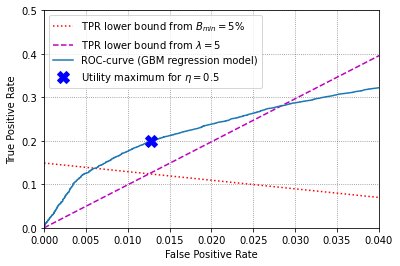

In [12]:
# Produce example figure illustrating ROC-analysis
bmin = .05
plt.plot([0, 1], [tpr_thresh_throughput(0, bmin, Neg, Pos),
                  tpr_thresh_throughput(1, bmin, Neg, Pos)], 'r:')
# Constraint imposed by lambda:
lmbda = 5
plt.plot([0, 1], [tpr_thresh_accuracy(0, lmbda, Neg, Pos),
                  tpr_thresh_accuracy(1, lmbda, Neg, Pos)], 'm--')
# ROC curve.
roc_ax = plt.gca()
roc_p_fpr, roc_p_tpr, roc_p_thresholds = roc_curve(yV_C, preds, pos_label='+')
roc_plt = RocCurveDisplay(fpr=roc_p_fpr, tpr=roc_p_tpr)
roc_plt.plot(ax=roc_ax)

# Best fpr/tpr for qualifying section of the ROC-curve:
eta = .5
_, best_valid_util = max_util_vals(yV_C, preds,
                                   bmin, eta, lmbda,
                                   Neg, Pos, pos_label='+')

plt.plot(best_valid_util[2], best_valid_util[3], 'bX', markersize=12)

roc_ax.set_xlim(0,.04)
roc_ax.set_ylim(0,.5)
plt.legend(['TPR lower bound from $B_{min}=5\%$',
            'TPR lower bound from $\lambda=5$',
            'ROC-curve (GBM regression model)',
            'Utility maximum for $\\eta=0.5$'])
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_roc_example_rocspace.pdf', bbox_inches='tight', pad_inches=0)

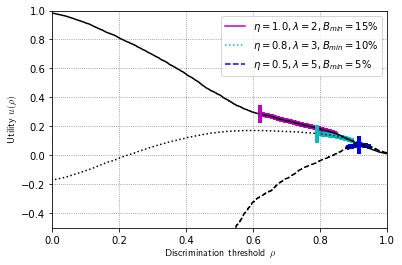

In [13]:
# Produce example figure illustrating utility function for various parameter values.
# Parameter rho (underlying the ROC curve) vs utility
# bmin: lower bmin => fewer convictions (i.e. higher threshold) necessary to be worthwhile
#   * increase to extend worthwhile section towards the right.
# eta: lower eta => higher weight for TCR. At lambda>1 that means higher penalties for FPs.
#   * increase to lift left side of utility (blockrate irrespective of accuracy)
#   * decrease to lift right side of utility (requiring higher thresholds, more precision)
params = [
    {'line':'-', 'color':'m', 'eta':1., 'lmbda':2, 'bmin':.15},
    {'line':':', 'color':'c', 'eta':.8, 'lmbda':3, 'bmin':.1},
    {'line':'--', 'color':'b', 'eta':.5, 'lmbda':5, 'bmin':.05},
]

legend = []
tex_b_min = 'B_{min}'
for p in params:
    plt.plot(-1,-1, f"{p['color']}{p['line']}")
    legend.append(f"$\eta={p['eta']}, \lambda={p['lmbda']}, {tex_b_min}={int(100*p['bmin'])}\%$")
plt.legend(legend)

for p in params:
    line=p['line']
    color=p['color']
    bmin=p['bmin']
    eta=p['eta']
    lmbda=p['lmbda']
    
    u_vals = [(True, roc_utility(fpr, tpr, eta, lmbda, Neg, Pos), thr, fpr, tpr)
        if (tpr>tpr_thresh_throughput(fpr, bmin, Neg, Pos) and
            tpr>tpr_thresh_accuracy(fpr, lmbda, Neg, Pos))
        else (False, roc_utility(fpr, tpr, eta, lmbda, Neg, Pos), thr, fpr, tpr)
        for (thr, fpr, tpr) in zip(roc_p_thresholds, roc_p_fpr, roc_p_tpr)]
    plt.scatter(roc_p_thresholds, [u[1] if u[0] else 100 for u in u_vals],
            c=[color if u[0] else 'y' for u in u_vals],
            marker='.')
    plt.plot(roc_p_thresholds, [u[1] for u in u_vals], f'k{line}')
    best_util = (-1 -1, -1, -1)
    best_valid_util = (-1 -1, -1, -1)
    for u in u_vals:
        valid = u[0]
        values = u[1:]
        if values[0]>best_util[0]:
            best_util = values
            if valid:
                best_valid_util = values
    plt.plot(best_valid_util[1], best_valid_util[0], f'{color}|', markersize=18, markeredgewidth=4)
    
plt.xlim(0,1)
plt.ylim(-.5,1)
plt.xlabel('Discrimination threshold $\\rho$', usetex=True)
plt.ylabel('Utility $u(\\rho)$', usetex=True)
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_roc_example_utility.pdf', bbox_inches='tight', pad_inches=0)

# 5 Experiments

## 5.3 Mean, Mode, and Aggregation Baselines
Establish naive predictions just based on prevalence or average of training labels.

In [14]:
# Naive baselines (mean, mode)
score = yV_A.value_counts(normalize=True).max()
print(f'Baseline (global mode, aggressive) score: {score}')
score = yV_C.value_counts(normalize=True).max()
print(f'Baseline (global mode, conservative) score: {score}')
score = yV_T.value_counts(normalize=True).max()
print(f'Baseline (global mode, threeclass) score: {score}')
mean_score = np.mean(yS)
score = r2_score(yS, [mean_score for _ in range(len(yS))])
print(f'Baseline (global mean, regression) score: {score}')

Baseline (global mode, aggressive) score: 0.5103
Baseline (global mode, conservative) score: 0.66423
Baseline (global mode, threeclass) score: 0.4897
Baseline (global mean, regression) score: 0.0


## 5.4 Baseline Predictions and Model Comparison
Tune a selection of commonly employed models using cross-validation and compare performance.

In [15]:
# Collection of classifiers for comparison.
model_types = {
    'regression': {'target': yS, 'validation_target': yS_validation, 'xtick': 4, 'color': 'green'},
    'aggressive': {'target': yV_A, 'validation_target': yV_A_validation, 'xtick': 1, 'color': 'red'},
    'conservative': {'target': yV_C, 'validation_target': yV_C_validation, 'xtick': 2, 'color': 'blue'},
    'threeclass': {'target': yV_T, 'validation_target': yV_T_validation, 'xtick': 3, 'color': 'magenta'},
}

# "Decent" parameters, used if not otherwise specified.
# Not optimizing for highest possible model quality,
#   higher focus is on consistency between experiments...
lgbm_base_params = {'random_state': RAND_STATE,
                    'learning_rate': 0.3,
                    'num_leaves': 31,
                    'n_estimators': 750,
                    'reg_lambda': 1}

model_markers = {
    'AdaBoost': 's',
    'DecisionTree': 'd',
    'ElasticNet': 'P',
    'GBM': '1',
    'CatBoost': '2',
    'LightGBM': '3',
    'XGBoost': '4',
    'KNearestNeighbors': 'h',
    'Lasso': '+',
    'LinearSVM': '^',
    'LogisticRegression': '',
    'LookupTable': '.',
    'NaiveBayes': 'v',
    'NeuralNet': 'X',
    'Perceptron': 'x',
#    'RadiusNearestNeighbors_0': '*',
    'RadiusNearestNeighbors': 'H',
    'RandomForest': 'D',
    'Ridge': '<',
    'SGD': '>',
}

In [16]:
# Previously evaluated models and stats (to avoid retraining)
evaluated_models = {'AdaBoost': {'aggressive': {'cv_scores': array([0.696 , 0.6914, 0.6844, 0.7108, 0.6746, 0.6822, 0.6928, 0.7128,
       0.67  , 0.6772, 0.6806, 0.6974, 0.6746, 0.684 , 0.7012, 0.7074,
       0.6844, 0.6962, 0.6722, 0.6842]),
                             'p_vals': {'algorithm': 'SAMME.R',
                                        'base_estimator': None,
                                        'learning_rate': 0.3807351226600021,
                                        'n_estimators': 934,
                                        'random_state': 27},
                             't_cv': 4633.822207927704,
                             't_fit': 242.0567569732666,
                             't_params': 2356.59366607666,
                             't_pred': 13.835801124572754,
                             'validation_score': 0.6956086575753785},
              'conservative': {'cv_scores': array([0.7284, 0.7364, 0.7398, 0.7528, 0.7146, 0.7316, 0.7368, 0.7512,
       0.6904, 0.7126, 0.7192, 0.7258, 0.7088, 0.725 , 0.724 , 0.741 ,
       0.7228, 0.7348, 0.7196, 0.7288]),
                               'p_vals': {'algorithm': 'SAMME.R',
                                          'base_estimator': None,
                                          'learning_rate': 0.34657044375378565,
                                          'n_estimators': 982,
                                          'random_state': 27},
                               't_cv': 4975.812776088715,
                               't_fit': 259.33961486816406,
                               't_params': 2624.1136219501495,
                               't_pred': 15.57357406616211,
                               'validation_score': 0.7437132490929563},
              'regression': {'cv_scores': array([0.0913026 , 0.08109925, 0.0796478 , 0.07145976, 0.07649606,
       0.08312432, 0.07681476, 0.09172026, 0.07111121, 0.07698725,
       0.09983929, 0.0820912 , 0.06991852, 0.08440587, 0.09995203,
       0.09951975, 0.08771756, 0.08570594, 0.0603785 , 0.08410396]),
                             'p_vals': {'base_estimator': None,
                                        'learning_rate': 0.3023698348577133,
                                        'loss': 'linear',
                                        'n_estimators': 687,
                                        'random_state': 27},
                             't_cv': 160.88277006149292,
                             't_fit': 9.818461179733276,
                             't_params': 179.566978931427,
                             't_pred': 0.06187009811401367,
                             'validation_score': 0.08617499985489296},
              'threeclass': {'cv_scores': array([0.6186, 0.6152, 0.6168, 0.6484, 0.5972, 0.606 , 0.624 , 0.6446,
       0.5626, 0.588 , 0.5988, 0.614 , 0.5816, 0.6028, 0.621 , 0.6338,
       0.5988, 0.6162, 0.6042, 0.6054]),
                             'p_vals': {'algorithm': 'SAMME.R',
                                        'base_estimator': None,
                                        'learning_rate': 0.17467602533184867,
                                        'n_estimators': 963,
                                        'random_state': 27},
                             't_cv': 5017.160070180893,
                             't_fit': 261.43762278556824,
                             't_params': 2345.4877078533173,
                             't_pred': 15.397317171096802,
                             'validation_score': 0.623764543975979}},
 'CatBoost': {'aggressive': {'cv_scores': array([0.7502, 0.7368, 0.732 , 0.7646, 0.739 , 0.7352, 0.7412, 0.76  ,
       0.7384, 0.7318, 0.7406, 0.7506, 0.7428, 0.743 , 0.75  , 0.7568,
       0.7378, 0.7374, 0.7106, 0.7424]),
                             'p_vals': {'cat_features': [0,
                                                         1,
                                                         2,
                                                         3,
                                                         4,
                                                         5,
                                                         6,
                                                         7,
                                                         8,
                                                         9,
                                                         10,
                                                         11,
                                                         12,
                                                         13,
                                                         14,
                                                         15,
                                                         16,
                                                         17,
                                                         18,
                                                         19,
                                                         20,
                                                         21,
                                                         22,
                                                         23,
                                                         24,
                                                         25,
                                                         26,
                                                         27,
                                                         28,
                                                         29,
                                                         30,
                                                         31,
                                                         32,
                                                         33,
                                                         34,
                                                         35,
                                                         36,
                                                         37,
                                                         38,
                                                         39,
                                                         40,
                                                         41,
                                                         42,
                                                         43,
                                                         44,
                                                         45,
                                                         46,
                                                         47,
                                                         48,
                                                         49,
                                                         50,
                                                         51,
                                                         52,
                                                         53,
                                                         54,
                                                         55,
                                                         56,
                                                         57,
                                                         58,
                                                         59,
                                                         60,
                                                         61,
                                                         62,
                                                         63,
                                                         64,
                                                         65,
                                                         66,
                                                         67,
                                                         68,
                                                         69,
                                                         70,
                                                         71,
                                                         72,
                                                         73,
                                                         74,
                                                         75,
                                                         76,
                                                         77,
                                                         78,
                                                         79,
                                                         80,
                                                         81,
                                                         82,
                                                         83,
                                                         84,
                                                         85,
                                                         86,
                                                         87,
                                                         88,
                                                         89,
                                                         90,
                                                         91,
                                                         92,
                                                         93,
                                                         94,
                                                         95,
                                                         96,
                                                         97,
                                                         98,
                                                         99,
                                                         100,
                                                         101,
                                                         102,
                                                         103,
                                                         104,
                                                         105,
                                                         106,
                                                         107,
                                                         108,
                                                         109,
                                                         110,
                                                         111,
                                                         112,
                                                         113,
                                                         114,
                                                         115,
                                                         116,
                                                         117,
                                                         118,
                                                         119,
                                                         120,
                                                         121,
                                                         122,
                                                         123,
                                                         124,
                                                         125,
                                                         126,
                                                         127,
                                                         128,
                                                         129,
                                                         130,
                                                         131,
                                                         132,
                                                         133,
                                                         134,
                                                         135,
                                                         136,
                                                         137,
                                                         138,
                                                         139,
                                                         140,
                                                         141,
                                                         142,
                                                         143,
                                                         144,
                                                         145,
                                                         146,
                                                         147,
                                                         148,
                                                         149,
                                                         150,
                                                         151,
                                                         152,
                                                         153,
                                                         154,
                                                         155,
                                                         156,
                                                         157,
                                                         158,
                                                         159,
                                                         160,
                                                         161,
                                                         162,
                                                         163,
                                                         164,
                                                         165,
                                                         166,
                                                         167,
                                                         168,
                                                         169,
                                                         170,
                                                         171,
                                                         172,
                                                         173,
                                                         174,
                                                         175,
                                                         176,
                                                         177,
                                                         178,
                                                         179,
                                                         180,
                                                         181,
                                                         182,
                                                         183,
                                                         184,
                                                         185,
                                                         186,
                                                         187,
                                                         188,
                                                         189,
                                                         190,
                                                         191,
                                                         192,
                                                         193,
                                                         194,
                                                         195,
                                                         196,
                                                         197,
                                                         198,
                                                         199,
                                                         200,
                                                         201,
                                                         202,
                                                         203,
                                                         204,
                                                         205,
                                                         206,
                                                         207,
                                                         208,
                                                         209,
                                                         210,
                                                         211,
                                                         212,
                                                         213,
                                                         214,
                                                         215,
                                                         216,
                                                         217,
                                                         218,
                                                         219,
                                                         220,
                                                         221,
                                                         222,
                                                         223,
                                                         224,
                                                         225,
                                                         226,
                                                         227,
                                                         228,
                                                         229,
                                                         230,
                                                         231,
                                                         232,
                                                         233,
                                                         234,
                                                         235,
                                                         236,
                                                         237,
                                                         238,
                                                         239,
                                                         240,
                                                         241,
                                                         242,
                                                         243,
                                                         244,
                                                         245,
                                                         246,
                                                         247,
                                                         248,
                                                         249,
                                                         250,
                                                         251],
                                        'learning_rate': 0.16250801594667705,
                                        'max_depth': 6,
                                        'n_estimators': 676,
                                        'random_state': 27,
                                        'reg_lambda': 9,
                                        'silent': True},
                             't_cv': 388.0215368270874,
                             't_fit': 19.50910472869873,
                             't_params': 646.2361133098602,
                             't_pred': 2.464648962020874,
                             'validation_score': 0.7467471537595396},
              'conservative': {'cv_scores': array([0.7504, 0.7588, 0.7614, 0.7794, 0.7446, 0.7528, 0.757 , 0.7742,
       0.7198, 0.737 , 0.74  , 0.7522, 0.7392, 0.751 , 0.749 , 0.7564,
       0.7546, 0.7496, 0.7376, 0.749 ]),
                               'p_vals': {'cat_features': [0,
                                                           1,
                                                           2,
                                                           3,
                                                           4,
                                                           5,
                                                           6,
                                                           7,
                                                           8,
                                                           9,
                                                           10,
                                                           11,
                                                           12,
                                                           13,
                                                           14,
                                                           15,
                                                           16,
                                                           17,
                                                           18,
                                                           19,
                                                           20,
                                                           21,
                                                           22,
                                                           23,
                                                           24,
                                                           25,
                                                           26,
                                                           27,
                                                           28,
                                                           29,
                                                           30,
                                                           31,
                                                           32,
                                                           33,
                                                           34,
                                                           35,
                                                           36,
                                                           37,
                                                           38,
                                                           39,
                                                           40,
                                                           41,
                                                           42,
                                                           43,
                                                           44,
                                                           45,
                                                           46,
                                                           47,
                                                           48,
                                                           49,
                                                           50,
                                                           51,
                                                           52,
                                                           53,
                                                           54,
                                                           55,
                                                           56,
                                                           57,
                                                           58,
                                                           59,
                                                           60,
                                                           61,
                                                           62,
                                                           63,
                                                           64,
                                                           65,
                                                           66,
                                                           67,
                                                           68,
                                                           69,
                                                           70,
                                                           71,
                                                           72,
                                                           73,
                                                           74,
                                                           75,
                                                           76,
                                                           77,
                                                           78,
                                                           79,
                                                           80,
                                                           81,
                                                           82,
                                                           83,
                                                           84,
                                                           85,
                                                           86,
                                                           87,
                                                           88,
                                                           89,
                                                           90,
                                                           91,
                                                           92,
                                                           93,
                                                           94,
                                                           95,
                                                           96,
                                                           97,
                                                           98,
                                                           99,
                                                           100,
                                                           101,
                                                           102,
                                                           103,
                                                           104,
                                                           105,
                                                           106,
                                                           107,
                                                           108,
                                                           109,
                                                           110,
                                                           111,
                                                           112,
                                                           113,
                                                           114,
                                                           115,
                                                           116,
                                                           117,
                                                           118,
                                                           119,
                                                           120,
                                                           121,
                                                           122,
                                                           123,
                                                           124,
                                                           125,
                                                           126,
                                                           127,
                                                           128,
                                                           129,
                                                           130,
                                                           131,
                                                           132,
                                                           133,
                                                           134,
                                                           135,
                                                           136,
                                                           137,
                                                           138,
                                                           139,
                                                           140,
                                                           141,
                                                           142,
                                                           143,
                                                           144,
                                                           145,
                                                           146,
                                                           147,
                                                           148,
                                                           149,
                                                           150,
                                                           151,
                                                           152,
                                                           153,
                                                           154,
                                                           155,
                                                           156,
                                                           157,
                                                           158,
                                                           159,
                                                           160,
                                                           161,
                                                           162,
                                                           163,
                                                           164,
                                                           165,
                                                           166,
                                                           167,
                                                           168,
                                                           169,
                                                           170,
                                                           171,
                                                           172,
                                                           173,
                                                           174,
                                                           175,
                                                           176,
                                                           177,
                                                           178,
                                                           179,
                                                           180,
                                                           181,
                                                           182,
                                                           183,
                                                           184,
                                                           185,
                                                           186,
                                                           187,
                                                           188,
                                                           189,
                                                           190,
                                                           191,
                                                           192,
                                                           193,
                                                           194,
                                                           195,
                                                           196,
                                                           197,
                                                           198,
                                                           199,
                                                           200,
                                                           201,
                                                           202,
                                                           203,
                                                           204,
                                                           205,
                                                           206,
                                                           207,
                                                           208,
                                                           209,
                                                           210,
                                                           211,
                                                           212,
                                                           213,
                                                           214,
                                                           215,
                                                           216,
                                                           217,
                                                           218,
                                                           219,
                                                           220,
                                                           221,
                                                           222,
                                                           223,
                                                           224,
                                                           225,
                                                           226,
                                                           227,
                                                           228,
                                                           229,
                                                           230,
                                                           231,
                                                           232,
                                                           233,
                                                           234,
                                                           235,
                                                           236,
                                                           237,
                                                           238,
                                                           239,
                                                           240,
                                                           241,
                                                           242,
                                                           243,
                                                           244,
                                                           245,
                                                           246,
                                                           247,
                                                           248,
                                                           249,
                                                           250,
                                                           251],
                                          'learning_rate': 0.34387274495410936,
                                          'max_depth': 4,
                                          'n_estimators': 461,
                                          'random_state': 27,
                                          'reg_lambda': 3,
                                          'silent': True},
                               't_cv': 278.34191489219666,
                               't_fit': 13.85385012626648,
                               't_params': 584.3712110519409,
                               't_pred': 2.4625983238220215,
                               'validation_score': 0.7619166770924559},
              'regression': {'cv_scores': array([0.36272229, 0.32547496, 0.30694266, 0.38100969, 0.33714158,
       0.33551233, 0.34854161, 0.38087435, 0.33835835, 0.33294773,
       0.34916973, 0.38203145, 0.35108981, 0.35475728, 0.37074259,
       0.38127751, 0.33745684, 0.35295957, 0.28028015, 0.33804586]),
                             'p_vals': {'cat_features': [0,
                                                         1,
                                                         2,
                                                         3,
                                                         4,
                                                         5,
                                                         6,
                                                         7,
                                                         8,
                                                         9,
                                                         10,
                                                         11,
                                                         12,
                                                         13,
                                                         14,
                                                         15,
                                                         16,
                                                         17,
                                                         18,
                                                         19,
                                                         20,
                                                         21,
                                                         22,
                                                         23,
                                                         24,
                                                         25,
                                                         26,
                                                         27,
                                                         28,
                                                         29,
                                                         30,
                                                         31,
                                                         32,
                                                         33,
                                                         34,
                                                         35,
                                                         36,
                                                         37,
                                                         38,
                                                         39,
                                                         40,
                                                         41,
                                                         42,
                                                         43,
                                                         44,
                                                         45,
                                                         46,
                                                         47,
                                                         48,
                                                         49,
                                                         50,
                                                         51,
                                                         52,
                                                         53,
                                                         54,
                                                         55,
                                                         56,
                                                         57,
                                                         58,
                                                         59,
                                                         60,
                                                         61,
                                                         62,
                                                         63,
                                                         64,
                                                         65,
                                                         66,
                                                         67,
                                                         68,
                                                         69,
                                                         70,
                                                         71,
                                                         72,
                                                         73,
                                                         74,
                                                         75,
                                                         76,
                                                         77,
                                                         78,
                                                         79,
                                                         80,
                                                         81,
                                                         82,
                                                         83,
                                                         84,
                                                         85,
                                                         86,
                                                         87,
                                                         88,
                                                         89,
                                                         90,
                                                         91,
                                                         92,
                                                         93,
                                                         94,
                                                         95,
                                                         96,
                                                         97,
                                                         98,
                                                         99,
                                                         100,
                                                         101,
                                                         102,
                                                         103,
                                                         104,
                                                         105,
                                                         106,
                                                         107,
                                                         108,
                                                         109,
                                                         110,
                                                         111,
                                                         112,
                                                         113,
                                                         114,
                                                         115,
                                                         116,
                                                         117,
                                                         118,
                                                         119,
                                                         120,
                                                         121,
                                                         122,
                                                         123,
                                                         124,
                                                         125,
                                                         126,
                                                         127,
                                                         128,
                                                         129,
                                                         130,
                                                         131,
                                                         132,
                                                         133,
                                                         134,
                                                         135,
                                                         136,
                                                         137,
                                                         138,
                                                         139,
                                                         140,
                                                         141,
                                                         142,
                                                         143,
                                                         144,
                                                         145,
                                                         146,
                                                         147,
                                                         148,
                                                         149,
                                                         150,
                                                         151,
                                                         152,
                                                         153,
                                                         154,
                                                         155,
                                                         156,
                                                         157,
                                                         158,
                                                         159,
                                                         160,
                                                         161,
                                                         162,
                                                         163,
                                                         164,
                                                         165,
                                                         166,
                                                         167,
                                                         168,
                                                         169,
                                                         170,
                                                         171,
                                                         172,
                                                         173,
                                                         174,
                                                         175,
                                                         176,
                                                         177,
                                                         178,
                                                         179,
                                                         180,
                                                         181,
                                                         182,
                                                         183,
                                                         184,
                                                         185,
                                                         186,
                                                         187,
                                                         188,
                                                         189,
                                                         190,
                                                         191,
                                                         192,
                                                         193,
                                                         194,
                                                         195,
                                                         196,
                                                         197,
                                                         198,
                                                         199,
                                                         200,
                                                         201,
                                                         202,
                                                         203,
                                                         204,
                                                         205,
                                                         206,
                                                         207,
                                                         208,
                                                         209,
                                                         210,
                                                         211,
                                                         212,
                                                         213,
                                                         214,
                                                         215,
                                                         216,
                                                         217,
                                                         218,
                                                         219,
                                                         220,
                                                         221,
                                                         222,
                                                         223,
                                                         224,
                                                         225,
                                                         226,
                                                         227,
                                                         228,
                                                         229,
                                                         230,
                                                         231,
                                                         232,
                                                         233,
                                                         234,
                                                         235,
                                                         236,
                                                         237,
                                                         238,
                                                         239,
                                                         240,
                                                         241,
                                                         242,
                                                         243,
                                                         244,
                                                         245,
                                                         246,
                                                         247,
                                                         248,
                                                         249,
                                                         250,
                                                         251],
                                        'learning_rate': 0.3465039942280332,
                                        'loss_function': 'RMSE',
                                        'max_depth': 6,
                                        'n_estimators': 809,
                                        'random_state': 27,
                                        'reg_lambda': 2,
                                        'silent': True},
                             't_cv': 316.5690188407898,
                             't_fit': 15.296687841415405,
                             't_params': 348.70849800109863,
                             't_pred': 2.5646941661834717,
                             'validation_score': 0.35585849882963294},
              'threeclass': {'cv_scores': array([0.6654, 0.6558, 0.649 , 0.691 , 0.6466, 0.6414, 0.6564, 0.6866,
       0.615 , 0.6268, 0.6416, 0.6612, 0.6246, 0.6464, 0.6634, 0.6684,
       0.645 , 0.6462, 0.6358, 0.6462]),
                             'p_vals': {'cat_features': [0,
                                                         1,
                                                         2,
                                                         3,
                                                         4,
                                                         5,
                                                         6,
                                                         7,
                                                         8,
                                                         9,
                                                         10,
                                                         11,
                                                         12,
                                                         13,
                                                         14,
                                                         15,
                                                         16,
                                                         17,
                                                         18,
                                                         19,
                                                         20,
                                                         21,
                                                         22,
                                                         23,
                                                         24,
                                                         25,
                                                         26,
                                                         27,
                                                         28,
                                                         29,
                                                         30,
                                                         31,
                                                         32,
                                                         33,
                                                         34,
                                                         35,
                                                         36,
                                                         37,
                                                         38,
                                                         39,
                                                         40,
                                                         41,
                                                         42,
                                                         43,
                                                         44,
                                                         45,
                                                         46,
                                                         47,
                                                         48,
                                                         49,
                                                         50,
                                                         51,
                                                         52,
                                                         53,
                                                         54,
                                                         55,
                                                         56,
                                                         57,
                                                         58,
                                                         59,
                                                         60,
                                                         61,
                                                         62,
                                                         63,
                                                         64,
                                                         65,
                                                         66,
                                                         67,
                                                         68,
                                                         69,
                                                         70,
                                                         71,
                                                         72,
                                                         73,
                                                         74,
                                                         75,
                                                         76,
                                                         77,
                                                         78,
                                                         79,
                                                         80,
                                                         81,
                                                         82,
                                                         83,
                                                         84,
                                                         85,
                                                         86,
                                                         87,
                                                         88,
                                                         89,
                                                         90,
                                                         91,
                                                         92,
                                                         93,
                                                         94,
                                                         95,
                                                         96,
                                                         97,
                                                         98,
                                                         99,
                                                         100,
                                                         101,
                                                         102,
                                                         103,
                                                         104,
                                                         105,
                                                         106,
                                                         107,
                                                         108,
                                                         109,
                                                         110,
                                                         111,
                                                         112,
                                                         113,
                                                         114,
                                                         115,
                                                         116,
                                                         117,
                                                         118,
                                                         119,
                                                         120,
                                                         121,
                                                         122,
                                                         123,
                                                         124,
                                                         125,
                                                         126,
                                                         127,
                                                         128,
                                                         129,
                                                         130,
                                                         131,
                                                         132,
                                                         133,
                                                         134,
                                                         135,
                                                         136,
                                                         137,
                                                         138,
                                                         139,
                                                         140,
                                                         141,
                                                         142,
                                                         143,
                                                         144,
                                                         145,
                                                         146,
                                                         147,
                                                         148,
                                                         149,
                                                         150,
                                                         151,
                                                         152,
                                                         153,
                                                         154,
                                                         155,
                                                         156,
                                                         157,
                                                         158,
                                                         159,
                                                         160,
                                                         161,
                                                         162,
                                                         163,
                                                         164,
                                                         165,
                                                         166,
                                                         167,
                                                         168,
                                                         169,
                                                         170,
                                                         171,
                                                         172,
                                                         173,
                                                         174,
                                                         175,
                                                         176,
                                                         177,
                                                         178,
                                                         179,
                                                         180,
                                                         181,
                                                         182,
                                                         183,
                                                         184,
                                                         185,
                                                         186,
                                                         187,
                                                         188,
                                                         189,
                                                         190,
                                                         191,
                                                         192,
                                                         193,
                                                         194,
                                                         195,
                                                         196,
                                                         197,
                                                         198,
                                                         199,
                                                         200,
                                                         201,
                                                         202,
                                                         203,
                                                         204,
                                                         205,
                                                         206,
                                                         207,
                                                         208,
                                                         209,
                                                         210,
                                                         211,
                                                         212,
                                                         213,
                                                         214,
                                                         215,
                                                         216,
                                                         217,
                                                         218,
                                                         219,
                                                         220,
                                                         221,
                                                         222,
                                                         223,
                                                         224,
                                                         225,
                                                         226,
                                                         227,
                                                         228,
                                                         229,
                                                         230,
                                                         231,
                                                         232,
                                                         233,
                                                         234,
                                                         235,
                                                         236,
                                                         237,
                                                         238,
                                                         239,
                                                         240,
                                                         241,
                                                         242,
                                                         243,
                                                         244,
                                                         245,
                                                         246,
                                                         247,
                                                         248,
                                                         249,
                                                         250,
                                                         251],
                                        'learning_rate': 0.24103627282234927,
                                        'max_depth': 7,
                                        'n_estimators': 476,
                                        'random_state': 27,
                                        'reg_lambda': 2,
                                        'silent': True},
                             't_cv': 407.40341305732727,
                             't_fit': 20.492063999176025,
                             't_params': 532.5218589305878,
                             't_pred': 2.98557710647583,
                             'validation_score': 0.6589203052671088}},
 'DecisionTree': {'aggressive': {'cv_scores': array([0.755 , 0.7414, 0.7246, 0.7704, 0.7496, 0.7452, 0.7558, 0.7598,
       0.7558, 0.747 , 0.7612, 0.759 , 0.7698, 0.751 , 0.7574, 0.7636,
       0.7444, 0.753 , 0.7224, 0.739 ]),
                                 'p_vals': {'ccp_alpha': 0.0,
                                            'class_weight': None,
                                            'criterion': 'gini',
                                            'max_depth': 195,
                                            'max_features': 27,
                                            'max_leaf_nodes': None,
                                            'min_impurity_decrease': 0.0,
                                            'min_impurity_split': None,
                                            'min_samples_leaf': 1,
                                            'min_samples_split': 2,
                                            'min_weight_fraction_leaf': 0.0,
                                            'presort': 'deprecated',
                                            'random_state': 27,
                                            'splitter': 'best'},
                                 't_cv': 15.109592199325562,
                                 't_fit': 0.697364091873169,
                                 't_params': 10.185200929641724,
                                 't_pred': 0.09471797943115234,
                                 'validation_score': 0.7563493056424372},
                  'conservative': {'cv_scores': array([0.7552, 0.7452, 0.745 , 0.7744, 0.7466, 0.746 , 0.747 , 0.7736,
       0.7242, 0.729 , 0.7422, 0.753 , 0.7394, 0.748 , 0.7518, 0.7514,
       0.7488, 0.7422, 0.7278, 0.7444]),
                                   'p_vals': {'ccp_alpha': 0.0,
                                              'class_weight': None,
                                              'criterion': 'gini',
                                              'max_depth': 134,
                                              'max_features': 17,
                                              'max_leaf_nodes': None,
                                              'min_impurity_decrease': 0.0,
                                              'min_impurity_split': None,
                                              'min_samples_leaf': 1,
                                              'min_samples_split': 2,
                                              'min_weight_fraction_leaf': 0.0,
                                              'presort': 'deprecated',
                                              'random_state': 27,
                                              'splitter': 'best'},
                                   't_cv': 14.401624917984009,
                                   't_fit': 0.6128830909729004,
                                   't_params': 10.77728271484375,
                                   't_pred': 0.09869217872619629,
                                   'validation_score': 0.7540660578005755},
                  'regression': {'cv_scores': array([0.35194792, 0.2654789 , 0.23584054, 0.35710778, 0.32999347,
       0.30848079, 0.32472401, 0.35432699, 0.32320231, 0.30563493,
       0.3237234 , 0.34572388, 0.34580644, 0.33004203, 0.34726091,
       0.34459128, 0.29538318, 0.3230145 , 0.2397021 , 0.30091716]),
                                 'p_vals': {'ccp_alpha': 0.0,
                                            'criterion': 'mse',
                                            'max_depth': 261,
                                            'max_features': 27,
                                            'max_leaf_nodes': None,
                                            'min_impurity_decrease': 0.0,
                                            'min_impurity_split': None,
                                            'min_samples_leaf': 1,
                                            'min_samples_split': 2,
                                            'min_weight_fraction_leaf': 0.0,
                                            'presort': 'deprecated',
                                            'random_state': 27,
                                            'splitter': 'best'},
                                 't_cv': 15.349869966506958,
                                 't_fit': 0.7150797843933105,
                                 't_params': 10.737314224243164,
                                 't_pred': 0.04257988929748535,
                                 'validation_score': 0.3259872615483209},
                  'threeclass': {'cv_scores': array([0.6594, 0.6352, 0.6246, 0.6782, 0.6406, 0.6328, 0.6448, 0.6726,
       0.6152, 0.616 , 0.6304, 0.653 , 0.6302, 0.6462, 0.6518, 0.658 ,
       0.6292, 0.633 , 0.62  , 0.637 ]),
                                 'p_vals': {'ccp_alpha': 0.0,
                                            'class_weight': None,
                                            'criterion': 'gini',
                                            'max_depth': 410,
                                            'max_features': 25,
                                            'max_leaf_nodes': None,
                                            'min_impurity_decrease': 0.0,
                                            'min_impurity_split': None,
                                            'min_samples_leaf': 1,
                                            'min_samples_split': 2,
                                            'min_weight_fraction_leaf': 0.0,
                                            'presort': 'deprecated',
                                            'random_state': 27,
                                            'splitter': 'best'},
                                 't_cv': 15.951892852783203,
                                 't_fit': 0.7467598915100098,
                                 't_params': 11.073467016220093,
                                 't_pred': 0.07529020309448242,
                                 'validation_score': 0.6504754159889904}},
 'ElasticNet': {'regression': {'cv_scores': array([0.0648902 , 0.05431912, 0.05636572, 0.04750635, 0.06029482,
       0.05884126, 0.05503469, 0.05804023, 0.04853911, 0.05626931,
       0.06928571, 0.06520221, 0.05204989, 0.06361318, 0.06994959,
       0.06966551, 0.05938029, 0.06028717, 0.05008684, 0.05771884]),
                               'p_vals': {'alpha': 0.10810897247729592,
                                          'copy_X': True,
                                          'fit_intercept': True,
                                          'l1_ratio': 0.1,
                                          'max_iter': 4848,
                                          'normalize': False,
                                          'positive': False,
                                          'precompute': False,
                                          'random_state': 27,
                                          'selection': 'cyclic',
                                          'tol': 0.0001,
                                          'warm_start': False},
                               't_cv': 10.637160778045654,
                               't_fit': 0.43517112731933594,
                               't_params': 8.575179100036621,
                               't_pred': 0.061372995376586914,
                               'validation_score': 0.05817289122616642}},
 'GBM': {'aggressive': {'cv_scores': array([0.751 , 0.735 , 0.725 , 0.7596, 0.7412, 0.7368, 0.7444, 0.7572,
       0.7344, 0.7326, 0.7392, 0.7434, 0.741 , 0.7468, 0.751 , 0.7544,
       0.7358, 0.7416, 0.7106, 0.7394]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 2,
                                   'learning_rate': 0.34497616269452824,
                                   'loss': 'auto',
                                   'max_bins': 255,
                                   'max_depth': 6,
                                   'max_iter': 466,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': 27,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 278.49524569511414,
                        't_fit': 13.73391580581665,
                        't_params': 335.16637802124023,
                        't_pred': 0.23189306259155273,
                        'validation_score': 0.7426185412235706},
         'conservative': {'cv_scores': array([0.7596, 0.7564, 0.7618, 0.7784, 0.748 , 0.7512, 0.7596, 0.78  ,
       0.7214, 0.7366, 0.738 , 0.7578, 0.7362, 0.7478, 0.7486, 0.7602,
       0.7552, 0.7492, 0.7396, 0.7486]),
                          'p_vals': {'early_stopping': 'auto',
                                     'l2_regularization': 1,
                                     'learning_rate': 0.25065593820730214,
                                     'loss': 'auto',
                                     'max_bins': 255,
                                     'max_depth': 6,
                                     'max_iter': 844,
                                     'max_leaf_nodes': 31,
                                     'min_samples_leaf': 20,
                                     'monotonic_cst': None,
                                     'n_iter_no_change': 10,
                                     'random_state': 27,
                                     'scoring': 'loss',
                                     'tol': 1e-07,
                                     'validation_fraction': 0.1,
                                     'verbose': 0,
                                     'warm_start': False},
                          't_cv': 243.767804145813,
                          't_fit': 10.02847409248352,
                          't_params': 249.06368207931519,
                          't_pred': 0.17253518104553223,
                          'validation_score': 0.7618541223570624},
         'regression': {'cv_scores': array([0.35955907, 0.32371753, 0.30601746, 0.38142941, 0.34284648,
       0.33248881, 0.34991446, 0.37657092, 0.32602181, 0.33090488,
       0.35233023, 0.38156111, 0.33644661, 0.35857776, 0.36522953,
       0.39016765, 0.33375965, 0.35449732, 0.27616276, 0.34219834]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 8,
                                   'learning_rate': 0.3893180405480869,
                                   'loss': 'least_squares',
                                   'max_bins': 255,
                                   'max_depth': 7,
                                   'max_iter': 360,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': 27,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 343.16276812553406,
                        't_fit': 21.266998052597046,
                        't_params': 300.0279109477997,
                        't_pred': 0.24126625061035156,
                        'validation_score': 0.35349189107663115},
         'threeclass': {'cv_scores': array([0.6624, 0.6512, 0.6474, 0.6854, 0.6436, 0.6396, 0.6508, 0.684 ,
       0.6116, 0.6176, 0.641 , 0.6624, 0.6164, 0.6458, 0.6602, 0.6648,
       0.6416, 0.6422, 0.6296, 0.6432]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 6,
                                   'learning_rate': 0.34997051776368626,
                                   'loss': 'auto',
                                   'max_bins': 255,
                                   'max_depth': 6,
                                   'max_iter': 359,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': 27,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 717.8229277133942,
                        't_fit': 19.78372812271118,
                        't_params': 733.271978855133,
                        't_pred': 0.28112268447875977,
                        'validation_score': 0.6517265106968597}},
 'KNearestNeighbors': {'aggressive': {'cv_scores': array([0.7428, 0.7136, 0.7114, 0.7616, 0.7384, 0.7212, 0.7368, 0.742 ,
       0.7332, 0.727 , 0.7434, 0.7494, 0.75  , 0.7372, 0.7408, 0.7408,
       0.7374, 0.7394, 0.7102, 0.7258]),
                                      'p_vals': {'algorithm': 'auto',
                                                 'leaf_size': 30,
                                                 'metric': 'minkowski',
                                                 'metric_params': None,
                                                 'n_jobs': 6,
                                                 'n_neighbors': 13,
                                                 'p': 2,
                                                 'weights': 'uniform'},
                                      't_cv': 527.4352948665619,
                                      't_fit': 10.168038845062256,
                                      't_params': 2913.832139968872,
                                      't_pred': 107.13728976249695,
                                      'validation_score': 0.7445264606530715},
                       'conservative': {'cv_scores': array([0.7482, 0.7486, 0.7498, 0.7704, 0.7402, 0.7362, 0.7448, 0.7698,
       0.7192, 0.7212, 0.7366, 0.749 , 0.7336, 0.7448, 0.7502, 0.7536,
       0.7464, 0.7388, 0.731 , 0.7448]),
                                        'p_vals': {'algorithm': 'auto',
                                                   'leaf_size': 30,
                                                   'metric': 'minkowski',
                                                   'metric_params': None,
                                                   'n_jobs': 6,
                                                   'n_neighbors': 20,
                                                   'p': 1,
                                                   'weights': 'uniform'},
                                        't_cv': 594.945958852768,
                                        't_fit': 11.36747407913208,
                                        't_params': 2978.757947921753,
                                        't_pred': 126.89414715766907,
                                        'validation_score': 0.7566933566871012},
                       'regression': {'cv_scores': array([0.3329212 , 0.27909397, 0.25877127, 0.36401616, 0.3180595 ,
       0.29833233, 0.3117897 , 0.34419041, 0.30702504, 0.29692694,
       0.3315887 , 0.35158918, 0.33736302, 0.34125741, 0.35405607,
       0.35981224, 0.31294422, 0.3281427 , 0.25857433, 0.3074737 ]),
                                      'p_vals': {'algorithm': 'auto',
                                                 'leaf_size': 30,
                                                 'metric': 'minkowski',
                                                 'metric_params': None,
                                                 'n_jobs': 6,
                                                 'n_neighbors': 12,
                                                 'p': 2,
                                                 'weights': 'uniform'},
                                      't_cv': 514.3867270946503,
                                      't_fit': 10.023889064788818,
                                      't_params': 2554.995356798172,
                                      't_pred': 102.64364290237427,
                                      'validation_score': 0.3351198735218538},
                       'threeclass': {'cv_scores': array([0.6454, 0.6254, 0.6248, 0.6738, 0.6314, 0.62  , 0.634 , 0.662 ,
       0.5974, 0.6044, 0.6296, 0.6428, 0.6198, 0.633 , 0.6468, 0.6516,
       0.6292, 0.6298, 0.6124, 0.627 ]),
                                      'p_vals': {'algorithm': 'auto',
                                                 'leaf_size': 30,
                                                 'metric': 'minkowski',
                                                 'metric_params': None,
                                                 'n_jobs': 6,
                                                 'n_neighbors': 20,
                                                 'p': 1,
                                                 'weights': 'uniform'},
                                      't_cv': 584.6265559196472,
                                      't_fit': 9.959646940231323,
                                      't_params': 3355.6262261867523,
                                      't_pred': 124.49928021430969,
                                      'validation_score': 0.6460340297760541}},
 'Lasso': {'regression': {'cv_scores': array([-2.66393933e-05, -3.38640038e-03, -5.19333728e-03, -1.51967530e-02,
       -8.01146956e-07, -4.92248420e-04, -3.19439974e-03, -7.78183166e-03,
       -1.70759247e-02, -5.75922298e-03, -1.95773901e-03, -3.50507994e-03,
       -5.76569791e-03, -8.45729300e-05, -1.09802615e-03, -1.24522313e-04,
       -6.54885570e-04, -3.42253304e-04, -6.05579159e-05, -1.81841040e-05]),
                          'p_vals': {'alpha': 0.14266563000201304,
                                     'copy_X': True,
                                     'fit_intercept': True,
                                     'max_iter': 5149,
                                     'normalize': False,
                                     'positive': False,
                                     'precompute': False,
                                     'random_state': 27,
                                     'selection': 'cyclic',
                                     'tol': 0.0001,
                                     'warm_start': False},
                          't_cv': 7.9586780071258545,
                          't_fit': 0.2971498966217041,
                          't_params': 7.993925094604492,
                          't_pred': 0.05913901329040527,
                          'validation_score': -0.0019882343801440605}},
 'LightGBM': {'aggressive': {'cv_scores': array([0.7652, 0.7486, 0.74  , 0.7832, 0.7526, 0.75  , 0.7676, 0.7752,
       0.7596, 0.749 , 0.7618, 0.7674, 0.7666, 0.7618, 0.765 , 0.7714,
       0.7526, 0.7666, 0.7282, 0.7548]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.3460697344147837,
                                        'max_depth': -1,
                                        'max_leaves': 22,
                                        'min_child_samples': 20,

                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 904,
                                        'n_jobs': -1,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': 27,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 1,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 63.983805894851685,
                             't_fit': 2.9975619316101074,
                             't_params': 74.64385080337524,
                             't_pred': 0.47714996337890625,
                             'validation_score': 0.761791567621669},
              'conservative': {'cv_scores': array([0.766 , 0.7612, 0.7662, 0.784 , 0.757 , 0.7562, 0.7618, 0.7852,
       0.7314, 0.7406, 0.7532, 0.7644, 0.749 , 0.7566, 0.7596, 0.766 ,
       0.7608, 0.7556, 0.7442, 0.7574]),
                               'p_vals': {'boosting_type': 'gbdt',
                                          'class_weight': None,
                                          'colsample_bytree': 1.0,
                                          'importance_type': 'split',
                                          'learning_rate': 0.31655248766578803,
                                          'max_depth': -1,
                                          'max_leaves': 50,
                                          'min_child_samples': 20,
                                          'min_child_weight': 0.001,
                                          'min_split_gain': 0.0,
                                          'n_estimators': 783,
                                          'n_jobs': -1,
                                          'num_leaves': 31,
                                          'objective': None,
                                          'random_state': 27,
                                          'reg_alpha': 0.0,
                                          'reg_lambda': 4,
                                          'silent': True,
                                          'subsample': 1.0,
                                          'subsample_for_bin': 200000,
                                          'subsample_freq': 0},
                               't_cv': 55.72431516647339,
                               't_fit': 2.5608320236206055,
                               't_params': 64.02487516403198,
                               't_pred': 0.41869521141052246,
                               'validation_score': 0.7697672963843363},
              'regression': {'cv_scores': array([0.37994763, 0.33819543, 0.32019385, 0.41139287, 0.36350849,
       0.35527387, 0.37053264, 0.40353776, 0.36635178, 0.3543674 ,
       0.36910871, 0.40303019, 0.37800836, 0.38196747, 0.39875488,
       0.4082908 , 0.35417051, 0.37279325, 0.29383477, 0.35367188]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.3719574140163001,
                                        'max_depth': -1,
                                        'max_leaves': 123,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 989,
                                        'n_jobs': 6,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': 27,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 3,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 58.131145000457764,
                             't_fit': 2.68338680267334,
                             't_params': 96.2934558391571,
                             't_pred': 0.42212915420532227,
                             'validation_score': 0.3765779109964128},
              'threeclass': {'cv_scores': array([0.6714, 0.6556, 0.6532, 0.6962, 0.6528, 0.647 , 0.657 , 0.6908,
       0.6236, 0.628 , 0.6492, 0.6694, 0.6338, 0.6548, 0.6682, 0.6694,
       0.6464, 0.6484, 0.6342, 0.6538]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.2806327499946234,
                                        'max_depth': -1,
                                        'max_leaves': 68,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 755,
                                        'n_jobs': -1,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': 27,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 0,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 146.98749899864197,
                             't_fit': 6.941553831100464,
                             't_params': 211.92679405212402,
                             't_pred': 0.982853889465332,
                             'validation_score': 0.6622669836106593}},
 'LinearSVM': {'aggressive': {'cv_scores': array([0.6964, 0.6904, 0.6872, 0.7086, 0.6754, 0.6846, 0.6954, 0.7124,
       0.669 , 0.676 , 0.683 , 0.6986, 0.6734, 0.6834, 0.6998, 0.7054,
       0.6826, 0.697 , 0.6738, 0.6832]),
                              'p_vals': {'C': 1.1804132137861114,
                                         'class_weight': None,
                                         'dual': True,
                                         'fit_intercept': True,
                                         'intercept_scaling': 1,
                                         'loss': 'squared_hinge',
                                         'max_iter': 7825,
                                         'multi_class': 'ovr',
                                         'penalty': 'l2',
                                         'random_state': 27,
                                         'tol': 0.0001,
                                         'verbose': 0},
                              't_cv': 135.62400794029236,
                              't_fit': 6.422485113143921,
                              't_params': 809.294038772583,
                              't_pred': 0.11229109764099121,
                              'validation_score': 0.6962654822970099},
               'conservative': {'cv_scores': array([0.7308, 0.7368, 0.7382, 0.754 , 0.717 , 0.7312, 0.7378, 0.7504,
       0.6924, 0.7156, 0.72  , 0.727 , 0.7098, 0.7258, 0.7224, 0.7426,
       0.7246, 0.7332, 0.7218, 0.726 ]),
                                'p_vals': {'C': 39.31401268048055,
                                           'class_weight': None,
                                           'dual': True,
                                           'fit_intercept': True,
                                           'intercept_scaling': 1,
                                           'loss': 'squared_hinge',
                                           'max_iter': 3594,
                                           'multi_class': 'ovr',
                                           'penalty': 'l2',
                                           'random_state': 27,
                                           'tol': 0.0001,
                                           'verbose': 0},
                                't_cv': 951.6465618610382,
                                't_fit': 51.26237416267395,
                                't_params': 1152.0267601013184,
                                't_pred': 0.11099910736083984,
                                'validation_score': 0.7436194169898661},
               'regression': {'cv_scores': array([0.08780423, 0.10371567, 0.0811759 , 0.08998384, 0.07176173,
       0.08303003, 0.1017821 , 0.13969364, 0.00598829, 0.06122606,
       0.05518097, 0.15127363, 0.02291039, 0.12363768, 0.11932309,
       0.15128766, 0.08642065, 0.06678903, 0.02704569, 0.04347161]),
                              'p_vals': {'C': 6.038082917747015,
                                         'dual': True,
                                         'epsilon': 0.0,
                                         'fit_intercept': True,
                                         'intercept_scaling': 1.0,
                                         'loss': 'epsilon_insensitive',
                                         'max_iter': 1102,
                                         'random_state': 27,
                                         'tol': 0.0001,
                                         'verbose': 0},
                              't_cv': 181.95601105690002,
                              't_fit': 9.680680990219116,
                              't_params': 844.4491398334503,
                              't_pred': 0.05225110054016113,
                              'validation_score': 0.09162420939925686},
               'threeclass': {'cv_scores': array([0.6248, 0.6168, 0.6192, 0.6572, 0.6038, 0.6128, 0.6244, 0.654 ,
       0.5672, 0.5922, 0.6006, 0.6204, 0.5856, 0.6078, 0.6276, 0.6354,
       0.6076, 0.6198, 0.6074, 0.6106]),
                              'p_vals': {'C': 13.255109053799778,
                                         'class_weight': None,
                                         'dual': True,
                                         'fit_intercept': True,
                                         'intercept_scaling': 1,
                                         'loss': 'squared_hinge',
                                         'max_iter': 7681,
                                         'multi_class': 'ovr',
                                         'penalty': 'l2',
                                         'random_state': 27,
                                         'tol': 0.0001,
                                         'verbose': 0},
                              't_cv': 5662.183444023132,
                              't_fit': 320.46363282203674,
                              't_params': 2625.670567035675,
                              't_pred': 0.09028005599975586,
                              'validation_score': 0.629300638058301}},
 'LogisticRegression': {'aggressive': {'cv_scores': array([0.6948, 0.6898, 0.687 , 0.7082, 0.674 , 0.6838, 0.6926, 0.7108,
       0.6692, 0.6768, 0.6828, 0.6988, 0.6744, 0.6842, 0.6992, 0.7056,
       0.6834, 0.6972, 0.6732, 0.6836]),
                                       'p_vals': {'C': 2.7463785883370777,
                                                  'class_weight': None,
                                                  'dual': False,
                                                  'fit_intercept': True,
                                                  'intercept_scaling': 1,
                                                  'l1_ratio': None,
                                                  'max_iter': 1124,
                                                  'multi_class': 'auto',
                                                  'n_jobs': 6,
                                                  'penalty': 'l2',
                                                  'random_state': 27,
                                                  'solver': 'lbfgs',
                                                  'tol': 0.0001,
                                                  'verbose': 0,
                                                  'warm_start': False},
                                       't_cv': 4758.198121070862,
                                       't_fit': 240.49286890029907,
                                       't_params': 1232.8795070648193,
                                       't_pred': 0.1072077751159668,
                                       'validation_score': 0.6950143875891405},
                        'conservative': {'cv_scores': array([0.7308, 0.7372, 0.7396, 0.7542, 0.7192, 0.7318, 0.739 , 0.7528,
       0.6922, 0.7148, 0.7214, 0.729 , 0.7092, 0.7264, 0.723 , 0.742 ,
       0.7246, 0.7334, 0.7224, 0.7268]),
                                         'p_vals': {'C': 4.771022232014365,
                                                    'class_weight': None,
                                                    'dual': False,
                                                    'fit_intercept': True,
                                                    'intercept_scaling': 1,
                                                    'l1_ratio': None,
                                                    'max_iter': 4992,
                                                    'multi_class': 'auto',
                                                    'n_jobs': 6,
                                                    'penalty': 'l2',
                                                    'random_state': 27,
                                                    'solver': 'lbfgs',
                                                    'tol': 0.0001,
                                                    'verbose': 0,
                                                    'warm_start': False},
                                         't_cv': 5042.372673034668,
                                         't_fit': 237.0663549900055,
                                         't_params': 980.8761780261993,
                                         't_pred': 0.10513091087341309,
                                         'validation_score': 0.7441824096084073},
                        'threeclass': {'cv_scores': array([0.6234, 0.6182, 0.618 , 0.6578, 0.6058, 0.6114, 0.6218, 0.6556,
       0.5666, 0.5934, 0.6042, 0.6216, 0.5868, 0.6102, 0.628 , 0.6372,
       0.6076, 0.6178, 0.6072, 0.6114]),
                                       'p_vals': {'C': 1.086390072461528,
                                                  'class_weight': None,
                                                  'dual': False,
                                                  'fit_intercept': True,
                                                  'intercept_scaling': 1,
                                                  'l1_ratio': None,
                                                  'max_iter': 3055,
                                                  'multi_class': 'auto',
                                                  'n_jobs': 6,
                                                  'penalty': 'l2',
                                                  'random_state': 27,
                                                  'solver': 'lbfgs',
                                                  'tol': 0.0001,
                                                  'verbose': 0,
                                                  'warm_start': False},
                                       't_cv': 3204.1921129226685,
                                       't_fit': 177.90500783920288,
                                       't_params': 1890.790139913559,
                                       't_pred': 0.08550286293029785,
                                       'validation_score': 0.62883147754285}},
 'LookupTable': {'aggressive': {'cv_scores': array([0.743 , 0.719 , 0.6936, 0.7484, 0.7284, 0.7196, 0.7262, 0.734 ,
       0.7498, 0.7336, 0.737 , 0.7534, 0.7556, 0.7394, 0.7446, 0.7462,
       0.7304, 0.7266, 0.7054, 0.7314]),
                                't_cv': 417.2938621044159,
                                't_fit': 19.415518045425415,
                                't_pred': 16.052856922149658,
                                'validation_score': 0.733266608282247},
                 'conservative': {'cv_scores': array([0.7406, 0.7354, 0.744 , 0.7668, 0.7354, 0.7402, 0.742 , 0.7662,
       0.7176, 0.7234, 0.7282, 0.7402, 0.7298, 0.7388, 0.738 , 0.7374,
       0.7324, 0.7316, 0.7152, 0.7298]),
                                  't_cv': 418.48824405670166,
                                  't_fit': 19.33379077911377,
                                  't_pred': 16.12510633468628,
                                  'validation_score': 0.7413674465157012},
                 'regression': {'cv_scores': array([0.33422361, 0.26848312, 0.24151497, 0.36243561, 0.31042614,
       0.31326179, 0.31430013, 0.34944442, 0.33353528, 0.30198638,
       0.30893595, 0.34382866, 0.34192945, 0.3392968 , 0.34307982,
       0.33268491, 0.28705051, 0.30726419, 0.23264172, 0.29746241]),
                                't_cv': 441.21037125587463,
                                't_fit': 20.883299827575684,
                                't_pred': 14.81684923171997,
                                'validation_score': 0.31450451744355146},
                 'threeclass': {'cv_scores': array([0.6354, 0.6124, 0.6098, 0.6644, 0.6214, 0.6214, 0.6242, 0.6602,
       0.5996, 0.5984, 0.6102, 0.6302, 0.6114, 0.6298, 0.6322, 0.629 ,
       0.603 , 0.6098, 0.5974, 0.6152]),
                                't_cv': 417.9057877063751,
                                't_fit': 19.06485414505005,
                                't_pred': 15.6630699634552,
                                'validation_score': 0.6262667333917178}},
 'NaiveBayes': {'aggressive': {'cv_scores': array([0.6264, 0.6394, 0.6518, 0.6676, 0.6042, 0.6302, 0.6438, 0.66  ,
       0.5616, 0.5966, 0.621 , 0.6122, 0.5834, 0.6166, 0.6232, 0.6358,
       0.615 , 0.6284, 0.6054, 0.6166]),
                               't_cv': 12.861231088638306,
                               't_fit': 0.5362610816955566,
                               't_pred': 0.12591218948364258,
                               'validation_score': 0.6385274615288378},
                'conservative': {'cv_scores': array([0.6978, 0.723 , 0.7276, 0.7308, 0.6902, 0.7076, 0.7238, 0.7272,
       0.6654, 0.6954, 0.699 , 0.6884, 0.682 , 0.6984, 0.6976, 0.705 ,
       0.703 , 0.7122, 0.6994, 0.702 ]),
                                 't_cv': 13.821939945220947,
                                 't_fit': 0.5845730304718018,
                                 't_pred': 0.12187004089355469,
                                 'validation_score': 0.7224759164268735},
                'threeclass': {'cv_scores': array([0.5552, 0.5796, 0.5896, 0.607 , 0.5438, 0.5616, 0.5812, 0.5904,
       0.487 , 0.5262, 0.5418, 0.5326, 0.515 , 0.551 , 0.548 , 0.5588,
       0.5442, 0.5582, 0.5462, 0.552 ]),
                               't_cv': 14.18179988861084,
                               't_fit': 0.5891528129577637,
                               't_pred': 0.13553404808044434,
                               'validation_score': 0.574502689853622}},
 'NeuralNet': {'aggressive': {'cv_scores': array([0.7598, 0.7422, 0.7384, 0.7824, 0.7446, 0.7386, 0.7538, 0.7632,
       0.7506, 0.7498, 0.7522, 0.762 , 0.7578, 0.749 , 0.7558, 0.759 ,
       0.7484, 0.7514, 0.7222, 0.7426]),
                              'p_vals': {'activation': 'relu',
                                         'alpha': 0.00046747076975194436,
                                         'batch_size': 'auto',
                                         'beta_1': 0.9,
                                         'beta_2': 0.999,
                                         'early_stopping': False,
                                         'epsilon': 1e-08,
                                         'hidden_layer_sizes': (100,),
                                         'learning_rate': 'constant',
                                         'learning_rate_init': 0.001,
                                         'max_fun': 15000,
                                         'max_iter': 3850,
                                         'momentum': 0.9,
                                         'n_iter_no_change': 10,
                                         'nesterovs_momentum': True,
                                         'power_t': 0.5,
                                         'random_state': 27,
                                         'shuffle': True,
                                         'solver': 'adam',
                                         'tol': 0.0001,
                                         'validation_fraction': 0.1,
                                         'verbose': False,
                                         'warm_start': False},
                              't_cv': 5063.605573177338,
                              't_fit': 205.32103991508484,
                              't_params': 2981.949380874634,
                              't_pred': 0.17484092712402344,
                              'validation_score': 0.7554422619792318},
               'conservative': {'cv_scores': array([0.7594, 0.7574, 0.7596, 0.7766, 0.7532, 0.7528, 0.7614, 0.784 ,
       0.7304, 0.734 , 0.7522, 0.7574, 0.743 , 0.7534, 0.7538, 0.7588,
       0.7548, 0.7508, 0.7406, 0.7504]),
                                'p_vals': {'activation': 'relu',
                                           'alpha': 0.0006328431639202672,
                                           'batch_size': 'auto',
                                           'beta_1': 0.9,
                                           'beta_2': 0.999,
                                           'early_stopping': False,
                                           'epsilon': 1e-08,
                                           'hidden_layer_sizes': (100,),
                                           'learning_rate': 'constant',
                                           'learning_rate_init': 0.001,
                                           'max_fun': 15000,
                                           'max_iter': 3539,
                                           'momentum': 0.9,
                                           'n_iter_no_change': 10,
                                           'nesterovs_momentum': True,
                                           'power_t': 0.5,
                                           'random_state': 27,
                                           'shuffle': True,
                                           'solver': 'adam',
                                           'tol': 0.0001,
                                           'validation_fraction': 0.1,
                                           'verbose': False,
                                           'warm_start': False},
                                't_cv': 5613.558705806732,
                                't_fit': 317.86465287208557,
                                't_params': 3508.819801092148,
                                't_pred': 0.2026050090789795,
                                'validation_score': 0.760258976604529},
               'regression': {'cv_scores': array([0.36212224, 0.30150878, 0.28725719, 0.38164702, 0.33838273,
       0.32148529, 0.33754743, 0.3825982 , 0.33870848, 0.3238949 ,
       0.34666821, 0.37646893, 0.3623786 , 0.34551312, 0.37638806,
       0.39078855, 0.31754352, 0.33502702, 0.26158749, 0.31888374]),
                              'p_vals': {'activation': 'relu',
                                         'alpha': 0.0003469392376472953,
                                         'batch_size': 'auto',
                                         'beta_1': 0.9,
                                         'beta_2': 0.999,
                                         'early_stopping': False,
                                         'epsilon': 1e-08,
                                         'hidden_layer_sizes': (100,),
                                         'learning_rate': 'constant',
                                         'learning_rate_init': 0.001,
                                         'max_fun': 15000,
                                         'max_iter': 3357,
                                         'momentum': 0.9,
                                         'n_iter_no_change': 10,
                                         'nesterovs_momentum': True,
                                         'power_t': 0.5,
                                         'random_state': 27,
                                         'shuffle': True,
                                         'solver': 'adam',
                                         'tol': 0.0001,
                                         'validation_fraction': 0.1,
                                         'verbose': False,
                                         'warm_start': False},
                              't_cv': 1579.7072570323944,
                              't_fit': 63.38363528251648,
                              't_params': 973.2944519519806,
                              't_pred': 0.11499714851379395,
                              'validation_score': 0.34624897815385725},
               'threeclass': {'cv_scores': array([0.659 , 0.6412, 0.6436, 0.688 , 0.6442, 0.6372, 0.6508, 0.6844,
       0.6174, 0.6178, 0.6364, 0.6518, 0.6264, 0.6434, 0.651 , 0.6592,
       0.6386, 0.6438, 0.6276, 0.632 ]),
                              'p_vals': {'activation': 'relu',
                                         'alpha': 3.5832123721802285e-05,
                                         'batch_size': 'auto',
                                         'beta_1': 0.9,
                                         'beta_2': 0.999,
                                         'early_stopping': False,
                                         'epsilon': 1e-08,
                                         'hidden_layer_sizes': (100,),
                                         'learning_rate': 'constant',
                                         'learning_rate_init': 0.001,
                                         'max_fun': 15000,
                                         'max_iter': 2750,
                                         'momentum': 0.9,
                                         'n_iter_no_change': 10,
                                         'nesterovs_momentum': True,
                                         'power_t': 0.5,
                                         'random_state': 27,
                                         'shuffle': True,
                                         'solver': 'adam',
                                         'tol': 0.0001,
                                         'validation_fraction': 0.1,
                                         'verbose': False,
                                         'warm_start': False},
                              't_cv': 4755.382073640823,
                              't_fit': 300.50471806526184,
                              't_params': 3549.481257915497,
                              't_pred': 0.14283323287963867,
                              'validation_score': 0.6576066558238459}},
 'Perceptron': {'aggressive': {'cv_scores': array([0.6098, 0.5726, 0.649 , 0.651 , 0.5882, 0.6152, 0.6512, 0.6592,
       0.5694, 0.5992, 0.5868, 0.6274, 0.6218, 0.518 , 0.5546, 0.6452,
       0.5572, 0.606 , 0.5778, 0.557 ]),
                               'p_vals': {'alpha': 0.00033196920839266905,
                                          'class_weight': None,
                                          'early_stopping': False,
                                          'eta0': 1.0,
                                          'fit_intercept': True,
                                          'max_iter': 1098,
                                          'n_iter_no_change': 5,
                                          'n_jobs': 6,
                                          'penalty': None,
                                          'random_state': 27,
                                          'shuffle': True,
                                          'tol': 0.001,
                                          'validation_fraction': 0.1,
                                          'verbose': 0,
                                          'warm_start': False},
                               't_cv': 14.47565507888794,
                               't_fit': 0.8072042465209961,
                               't_params': 11.790907144546509,
                               't_pred': 0.0966649055480957,
                               'validation_score': 0.644032278243463},
                'conservative': {'cv_scores': array([0.621 , 0.6498, 0.7228, 0.5272, 0.5544, 0.596 , 0.7184, 0.6672,
       0.6176, 0.5486, 0.6572, 0.677 , 0.6858, 0.6954, 0.6974, 0.7094,
       0.703 , 0.7058, 0.6952, 0.6096]),
                                 'p_vals': {'alpha': 3.599389286792098e-05,
                                            'class_weight': None,
                                            'early_stopping': False,
                                            'eta0': 1.0,
                                            'fit_intercept': True,
                                            'max_iter': 3180,
                                            'n_iter_no_change': 5,
                                            'n_jobs': 6,
                                            'penalty': None,
                                            'random_state': 27,
                                            'shuffle': True,
                                            'tol': 0.001,
                                            'validation_fraction': 0.1,
                                            'verbose': 0,
                                            'warm_start': False},
                                 't_cv': 14.217251062393188,
                                 't_fit': 0.5182290077209473,
                                 't_params': 11.573199033737183,
                                 't_pred': 0.09779620170593262,
                                 'validation_score': 0.5517640435380958},
                'threeclass': {'cv_scores': array([0.4672, 0.4956, 0.5884, 0.483 , 0.3562, 0.4676, 0.4394, 0.5512,
       0.5048, 0.3852, 0.5486, 0.5782, 0.554 , 0.5698, 0.5744, 0.5032,
       0.5152, 0.5942, 0.568 , 0.5608]),
                               'p_vals': {'alpha': 4.480784102399106e-05,
                                          'class_weight': None,
                                          'early_stopping': False,
                                          'eta0': 1.0,
                                          'fit_intercept': True,
                                          'max_iter': 331,
                                          'n_iter_no_change': 5,
                                          'n_jobs': 6,
                                          'penalty': None,
                                          'random_state': 27,
                                          'shuffle': True,
                                          'tol': 0.001,
                                          'validation_fraction': 0.1,
                                          'verbose': 0,
                                          'warm_start': False},
                               't_cv': 18.23341703414917,
                               't_fit': 0.9903697967529297,
                               't_params': 17.059825897216797,
                               't_pred': 0.07596778869628906,
                               'validation_score': 0.5540160140122607}},
 'RandomForest': {'aggressive': {'cv_scores': array([0.6966, 0.6858, 0.69  , 0.7062, 0.6942, 0.6838, 0.6872, 0.7008,
       0.6876, 0.679 , 0.6948, 0.6976, 0.6792, 0.6854, 0.704 , 0.712 ,
       0.6884, 0.6866, 0.6686, 0.6882]),
                                 'p_vals': {'bootstrap': True,
                                            'ccp_alpha': 0.0,
                                            'class_weight': None,
                                            'criterion': 'gini',
                                            'max_depth': 15,
                                            'max_features': 9,
                                            'max_leaf_nodes': None,
                                            'max_samples': None,
                                            'min_impurity_decrease': 0.0,
                                            'min_impurity_split': None,
                                            'min_samples_leaf': 1,
                                            'min_samples_split': 2,
                                            'min_weight_fraction_leaf': 0.0,
                                            'n_estimators': 481,
                                            'n_jobs': 6,
                                            'oob_score': False,
                                            'random_state': 27,
                                            'verbose': 0,
                                            'warm_start': False},
                                 't_cv': 230.1444718837738,
                                 't_fit': 8.677373170852661,
                                 't_params': 258.82346081733704,
                                 't_pred': 0.36621999740600586,
                                 'validation_score': 0.6921681471287376},
                  'conservative': {'cv_scores': array([0.7088, 0.7274, 0.7316, 0.7408, 0.7034, 0.7218, 0.7268, 0.7376,
       0.678 , 0.6982, 0.7012, 0.7068, 0.6972, 0.7094, 0.7034, 0.7246,
       0.71  , 0.7192, 0.7032, 0.7162]),
                                   'p_vals': {'bootstrap': True,
                                              'ccp_alpha': 0.0,
                                              'class_weight': None,
                                              'criterion': 'gini',
                                              'max_depth': 14,
                                              'max_features': 10,
                                              'max_leaf_nodes': None,
                                              'max_samples': None,
                                              'min_impurity_decrease': 0.0,
                                              'min_impurity_split': None,
                                              'min_samples_leaf': 1,
                                              'min_samples_split': 2,
                                              'min_weight_fraction_leaf': 0.0,
                                              'n_estimators': 630,
                                              'n_jobs': 6,
                                              'oob_score': False,
                                              'random_state': 27,
                                              'verbose': 0,
                                              'warm_start': False},
                                   't_cv': 313.1079878807068,
                                   't_fit': 11.874178886413574,
                                   't_params': 232.92107391357422,
                                   't_pred': 0.44395017623901367,
                                   'validation_score': 0.7289816089077943},
                  'regression': {'cv_scores': array([0.17389694, 0.16198745, 0.16291102, 0.16890622, 0.16008587,
       0.16551692, 0.16865342, 0.18031809, 0.14841699, 0.16621219,
       0.18339184, 0.18265803, 0.15415304, 0.17040167, 0.1869537 ,
       0.19358903, 0.17045488, 0.17646475, 0.14936917, 0.16416967]),
                                 'p_vals': {'bootstrap': True,
                                            'ccp_alpha': 0.0,
                                            'criterion': 'mse',
                                            'max_depth': 14,
                                            'max_features': 7,
                                            'max_leaf_nodes': None,
                                            'max_samples': None,
                                            'min_impurity_decrease': 0.0,
                                            'min_impurity_split': None,
                                            'min_samples_leaf': 1,
                                            'min_samples_split': 2,
                                            'min_weight_fraction_leaf': 0.0,
                                            'n_estimators': 904,
                                            'n_jobs': 6,
                                            'oob_score': False,
                                            'random_state': 27,
                                            'verbose': 0,
                                            'warm_start': False},
                                 't_cv': 350.46723318099976,
                                 't_fit': 11.736459016799927,
                                 't_params': 300.80876898765564,
                                 't_pred': 0.40915608406066895,
                                 'validation_score': 0.17623969079001944},
                  'threeclass': {'cv_scores': array([0.6026, 0.6074, 0.6102, 0.6492, 0.5818, 0.5948, 0.6116, 0.6324,
       0.541 , 0.5654, 0.5888, 0.5942, 0.5606, 0.5948, 0.6014, 0.6214,
       0.5818, 0.6004, 0.5848, 0.5876]),
                                 'p_vals': {'bootstrap': True,
                                            'ccp_alpha': 0.0,
                                            'class_weight': None,
                                            'criterion': 'gini',
                                            'max_depth': 15,
                                            'max_features': 5,
                                            'max_leaf_nodes': None,
                                            'max_samples': None,
                                            'min_impurity_decrease': 0.0,
                                            'min_impurity_split': None,
                                            'min_samples_leaf': 1,
                                            'min_samples_split': 2,
                                            'min_weight_fraction_leaf': 0.0,
                                            'n_estimators': 656,
                                            'n_jobs': 6,
                                            'oob_score': False,
                                            'random_state': 27,
                                            'verbose': 0,
                                            'warm_start': False},
                                 't_cv': 235.73163437843323,
                                 't_fit': 8.449441909790039,
                                 't_params': 226.71676993370056,
                                 't_pred': 0.4596259593963623,
                                 'validation_score': 0.6140372826222945}},
 'Ridge': {'regression': {'cv_scores': array([0.22696981, 0.19999525, 0.18448385, 0.21733694, 0.19416908,
       0.19490772, 0.20803211, 0.22263067, 0.19516024, 0.20225222,
       0.21161166, 0.23356178, 0.19749573, 0.20695707, 0.22946072,
       0.247084  , 0.21038516, 0.21193395, 0.17619078, 0.20931692]),
                          'p_vals': {'alpha': 2.139569376167774,
                                     'copy_X': True,
                                     'fit_intercept': True,
                                     'max_iter': None,
                                     'normalize': False,
                                     'random_state': 27,
                                     'solver': 'auto',
                                     'tol': 0.001},
                          't_cv': 8.670111894607544,
                          't_fit': 0.3251230716705322,
                          't_params': 8.169203996658325,
                          't_pred': 0.06355404853820801,
                          'validation_score': 0.21827339186147476}},
 'SGD': {'aggressive': {'cv_scores': array([0.682 , 0.6754, 0.668 , 0.69  , 0.6664, 0.6738, 0.6774, 0.6958,
       0.6544, 0.6568, 0.6712, 0.6802, 0.655 , 0.6632, 0.683 , 0.697 ,
       0.6732, 0.6814, 0.6564, 0.6652]),
                        'p_vals': {'alpha': 0.004287544835226391,
                                   'average': False,
                                   'class_weight': None,
                                   'early_stopping': False,
                                   'epsilon': 0.1,
                                   'eta0': 0.0,
                                   'fit_intercept': True,
                                   'l1_ratio': 0.15,
                                   'learning_rate': 'optimal',
                                   'loss': 'hinge',
                                   'max_iter': 1000,
                                   'n_iter_no_change': 5,
                                   'n_jobs': 6,
                                   'penalty': 'l2',
                                   'power_t': 0.5,
                                   'random_state': 27,
                                   'shuffle': True,
                                   'tol': 0.001,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 16.042022943496704,
                        't_fit': 0.7128489017486572,
                        't_params': 10.824576139450073,
                        't_pred': 0.09730029106140137,
                        'validation_score': 0.6801263605654948},
         'conservative': {'cv_scores': array([0.7018, 0.7232, 0.728 , 0.7388, 0.6976, 0.722 , 0.7246, 0.7354,
       0.6708, 0.698 , 0.6972, 0.6948, 0.6902, 0.705 , 0.6994, 0.7076,
       0.708 , 0.717 , 0.702 , 0.7136]),
                          'p_vals': {'alpha': 0.0010591535878642967,
                                     'average': False,
                                     'class_weight': None,
                                     'early_stopping': False,
                                     'epsilon': 0.1,
                                     'eta0': 0.0,
                                     'fit_intercept': True,
                                     'l1_ratio': 0.15,
                                     'learning_rate': 'optimal',
                                     'loss': 'hinge',
                                     'max_iter': 1000,
                                     'n_iter_no_change': 5,
                                     'n_jobs': 6,
                                     'penalty': 'l2',
                                     'power_t': 0.5,
                                     'random_state': 27,
                                     'shuffle': True,
                                     'tol': 0.001,
                                     'validation_fraction': 0.1,
                                     'verbose': 0,
                                     'warm_start': False},
                          't_cv': 19.63859796524048,
                          't_fit': 0.8667881488800049,
                          't_params': 10.885081768035889,
                          't_pred': 0.09862995147705078,
                          'validation_score': 0.7273551857875641},

         'regression': {'cv_scores': array([0.1990487 , 0.1710794 , 0.162265  , 0.18212066, 0.17795163,
       0.1734162 , 0.17891775, 0.19481119, 0.16953907, 0.18114199,
       0.19105246, 0.20323666, 0.17323083, 0.1831476 , 0.20275125,
       0.21877824, 0.19058673, 0.19023092, 0.16042458, 0.1837283 ]),
                        'p_vals': {'alpha': 0.010109656030862472,
                                   'average': False,
                                   'early_stopping': False,
                                   'epsilon': 0.1,
                                   'eta0': 0.01,
                                   'fit_intercept': True,
                                   'l1_ratio': 0.15,
                                   'learning_rate': 'invscaling',
                                   'loss': 'squared_loss',
                                   'max_iter': 1000,
                                   'n_iter_no_change': 5,
                                   'penalty': 'l2',
                                   'power_t': 0.25,
                                   'random_state': 27,
                                   'shuffle': True,
                                   'tol': 0.001,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 14.293342113494873,
                        't_fit': 0.63832688331604,
                        't_params': 10.061145782470703,
                        't_pred': 0.0516657829284668,
                        'validation_score': 0.19146066953853524},
         'threeclass': {'cv_scores': array([0.5804, 0.5826, 0.5866, 0.6244, 0.561 , 0.5734, 0.5886, 0.611 ,
       0.5134, 0.5474, 0.5644, 0.565 , 0.5396, 0.5748, 0.5724, 0.5922,
       0.5622, 0.5774, 0.5648, 0.5666]),
                        'p_vals': {'alpha': 0.011291087517011737,
                                   'average': False,
                                   'class_weight': None,
                                   'early_stopping': False,
                                   'epsilon': 0.1,
                                   'eta0': 0.0,
                                   'fit_intercept': True,
                                   'l1_ratio': 0.15,
                                   'learning_rate': 'optimal',
                                   'loss': 'hinge',
                                   'max_iter': 1000,
                                   'n_iter_no_change': 5,
                                   'n_jobs': 6,
                                   'penalty': 'l2',
                                   'power_t': 0.5,
                                   'random_state': 27,
                                   'shuffle': True,
                                   'tol': 0.001,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 15.743021011352539,
                        't_fit': 0.7351820468902588,
                        't_params': 15.083982706069946,
                        't_pred': 0.07945585250854492,
                        'validation_score': 0.5947078693857125}},
 'XGBoost': {'aggressive': {'cv_scores': array([0.7672, 0.7484, 0.7394, 0.7864, 0.7522, 0.7468, 0.7594, 0.7704,
       0.755 , 0.7464, 0.7586, 0.7664, 0.7654, 0.7618, 0.762 , 0.7704,
       0.7506, 0.7598, 0.7242, 0.7558]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.3042303458599271,
                                       'max_delta_step': 0,
                                       'max_depth': 7,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 616,
                                       'n_jobs': 6,
                                       'num_parallel_tree': 1,
                                       'objective': 'binary:logistic',
                                       'random_state': 27,
                                       'reg_alpha': 0,
                                       'reg_lambda': 0,
                                       'scale_pos_weight': 1,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 3307.1494059562683,
                            't_fit': 165.29894590377808,
                            't_params': 3786.056620121002,
                            't_pred': 0.5999240875244141,
                            'validation_score': 0.7604779181784062},
             'conservative': {'cv_scores': array([0.7676, 0.7592, 0.7638, 0.783 , 0.757 , 0.7554, 0.7632, 0.7898,
       0.734 , 0.7432, 0.7536, 0.7628, 0.75  , 0.756 , 0.7626, 0.7672,
       0.7576, 0.7598, 0.7426, 0.7576]),
                              'p_vals': {'base_score': 0.5,
                                         'booster': 'gbtree',
                                         'colsample_bylevel': 1,
                                         'colsample_bynode': 1,
                                         'colsample_bytree': 1,
                                         'gamma': 0,
                                         'gpu_id': -1,
                                         'importance_type': 'gain',
                                         'interaction_constraints': '',
                                         'learning_rate': 0.3102738838192021,
                                         'max_delta_step': 0,
                                         'max_depth': 7,
                                         'min_child_weight': 1,
                                         'missing': nan,
                                         'monotone_constraints': '()',
                                         'n_estimators': 694,
                                         'n_jobs': 6,
                                         'num_parallel_tree': 1,
                                         'objective': 'binary:logistic',
                                         'random_state': 27,
                                         'reg_alpha': 0,
                                         'reg_lambda': 0,
                                         'scale_pos_weight': 1,
                                         'subsample': 1,
                                         'tree_method': 'exact',
                                         'validate_parameters': 1,
                                         'verbosity': 0},
                              't_cv': 3190.5547230243683,
                              't_fit': 167.44062209129333,
                              't_params': 3588.210219860077,
                              't_pred': 0.5556268692016602,
                              'validation_score': 0.7693919679719755},
             'regression': {'cv_scores': array([0.38109904, 0.33709624, 0.32339925, 0.41375813, 0.35734214,
       0.35612391, 0.37104425, 0.40442109, 0.36235843, 0.35384962,
       0.37070588, 0.40197498, 0.37891549, 0.3750374 , 0.39300271,
       0.40014096, 0.35086021, 0.36990476, 0.28915248, 0.34663714]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.39574800123698517,
                                       'max_delta_step': 0,
                                       'max_depth': 6,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 904,
                                       'n_jobs': 6,
                                       'num_parallel_tree': 1,
                                       'objective': 'reg:squarederror',
                                       'random_state': 27,
                                       'reg_alpha': 0,
                                       'reg_lambda': 6,
                                       'scale_pos_weight': 1,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 3742.847711086273,
                            't_fit': 211.08491802215576,
                            't_params': 3884.5020730495453,
                            't_pred': 0.6163489818572998,
                            'validation_score': 0.37325082608851445},
             'threeclass': {'cv_scores': array([0.6678, 0.6542, 0.6532, 0.695 , 0.6482, 0.6438, 0.657 , 0.69  ,
       0.6184, 0.626 , 0.6452, 0.6624, 0.6258, 0.6508, 0.664 , 0.67  ,
       0.6472, 0.6472, 0.6316, 0.6524]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.2626474178992229,
                                       'max_delta_step': 0,
                                       'max_depth': 7,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 471,
                                       'n_jobs': 6,
                                       'num_parallel_tree': 1,
                                       'objective': 'multi:softprob',
                                       'random_state': 27,
                                       'reg_alpha': 0,
                                       'reg_lambda': 2,
                                       'scale_pos_weight': None,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 6388.619333744049,
                            't_fit': 334.08303785324097,
                            't_params': 9024.171882152557,
                            't_pred': 0.7447311878204346,
                            'validation_score': 0.6616414362567247}}}

In [17]:
models = []
# New regression models
models.extend([
    {
    'name': 'LookupTable', 'type': 'regression',
    'model': SDRLookupRegressor(),
    }, {
    'name': 'GBM', 'type': 'regression',
    'model': HistGradientBoostingRegressor(random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'l2_regularization': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'max_depth': sp.stats.randint(2, 8),
#        'max_leaf_nodes': sp.stats.randint(2**2, 2**8),
        'max_iter': sp.stats.randint(300, 1000)},
    }, {
    'name': 'CatBoost', 'type': 'regression',
    'model': CatBoostRegressor(random_state=RAND_STATE, silent=True, cat_features=list(range(X.shape[1]))), #cats are slower but not better ?
    'n_iter': 10,
    'p_dists': {
        'reg_lambda': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'max_depth': sp.stats.randint(2, 8), # for 'grow_policy':'SymmetricTree' (default)
        # 'max_leaves': sp.stats.randint(2**2, 2**8), # for 'grow_policy':'Lossguide'
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'LightGBM', 'type': 'regression',
    'model': LGBMRegressor(n_jobs=N_JOBS, random_state=RAND_STATE), #needs the lgb.Dataset constructor, categorical_feature=list(X.columns)),
    'n_iter': 10,
    'p_dists': {
        'reg_lambda': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
#        'max_depth': sp.stats.randint(2, 8), # always grows leaf-wise (lossguide?)
        'max_leaves': sp.stats.randint(2**2, 2**8),
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'XGBoost', 'type': 'regression',
    'model': XGBRegressor(n_jobs=N_JOBS, random_state=RAND_STATE, verbosity=0),
    'n_iter': 10,
    'p_dists': {
        'reg_lambda': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'max_depth': sp.stats.randint(2, 8), # grow_policy=depthwise (default)
#        'max_leaves': sp.stats.randint(2**2, 2**8), # grow_policy=lossguide
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'RandomForest', 'type': 'regression',
    'model': RandomForestRegressor(n_jobs=N_JOBS, random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'max_depth': sp.stats.randint(1, 16),
        'max_features': sp.stats.randint(1, int(np.sqrt(num_dims))),
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'SGD','type': 'regression',
    'model': SGDRegressor(random_state=RAND_STATE),
    'p_dists': {
        'alpha': sp.stats.uniform(1e-6, 0.1)},
    }, {
    'name': 'LinearSVM', 'type': 'regression',
    'model': LinearSVR(random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'C': loguniform(1e0, 1e3),
        'max_iter': sp.stats.randint(1000, 8000)},
    }, {
    'name': 'NeuralNet', 'type': 'regression',
    'model': MLPRegressor(random_state=RAND_STATE),
    'p_dists': {
        'alpha': loguniform(1e-6, 1e0),
        'max_iter': sp.stats.randint(200, 5000)},
    }, {
    'name': 'KNearestNeighbors', 'type': 'regression',
    'model': KNeighborsRegressor(n_jobs=N_JOBS),
    'p_dists': {
        'n_neighbors': sp.stats.randint(1, 40),
        'p': [1, 2]},
#    }, {
#    'name': 'RadiusNearestNeighbors_0', 'type': 'regression', # predicts NaN and errors
#    'model': RadiusNeighborsRegressor(n_jobs=N_JOBS, p=1, radius=0),
#    }, {
#    'name': 'RadiusNearestNeighbors', 'type': 'regression', # predicts NaN and errors out if no neighbors are found in radius
#    'model': RadiusNeighborsRegressor(n_jobs=N_JOBS, p=1),
#    'p_dists': {
#        'radius': sp.stats.randint(1, int(np.sqrt(num_dims)))}
    }, {
    'name': 'DecisionTree', 'type': 'regression',
    'model': DecisionTreeRegressor(random_state=RAND_STATE),
    'p_dists': {
        'max_depth': sp.stats.randint(100, 1000),
        'max_features': sp.stats.randint(1, 2*int(np.sqrt(num_dims)))},
    }, {
    'name': 'AdaBoost', 'type': 'regression',
    'model': AdaBoostRegressor(random_state=RAND_STATE),
    'p_dists': {
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'Lasso', 'type': 'regression',
    'model': Lasso(random_state=RAND_STATE),
    'p_dists': {
        'alpha': loguniform(1e-2, 10),
        'max_iter': sp.stats.randint(1000, 8000)},
    }, {
    'name': 'ElasticNet', 'type': 'regression',
    'model': ElasticNet(random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'alpha': loguniform(1e-2, 10),
        'l1_ratio': [.1, .5, .7, .9, .95, .99, 1], #0 ridge, 1 lasso
        'max_iter': sp.stats.randint(1000, 8000)},
    }, {
    'name': 'Ridge', 'type': 'regression',
    'model': Ridge(random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'alpha': loguniform(1e-2, 10)},
    }
])

# New classification models
for mtype in model_types:
    if mtype == 'regression':
        continue
    models.extend([
    {
    'name': 'LookupTable', 'type': mtype,
    'model': SDRLookupClassifier(),
    }, {
    'name': 'GBM', 'type': mtype,
    'model': HistGradientBoostingClassifier(random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'l2_regularization': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'max_depth': sp.stats.randint(2, 8),
#        'max_leaf_nodesint': sp.stats.randint(2**2, 2**8),
        'max_iter': sp.stats.randint(300, 1000)},
    }, {
    'name': 'CatBoost', 'type': mtype,
    'model': CatBoostClassifier(random_state=RAND_STATE, silent=True, cat_features=list(range(X.shape[1]))), #cats are slower but not better 
    'n_iter': 10,
    'p_dists': {
        'reg_lambda': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'max_depth': sp.stats.randint(2, 8), # for 'grow_policy':'SymmetricTree' (default)
        # 'max_leaves': sp.stats.randint(2**2, 2**8), # for 'grow_policy':'Lossguide'
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'LightGBM', 'type': mtype,
    'model': LGBMClassifier(random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'reg_lambda': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
#        'max_depth': sp.stats.randint(2, 8), # always grows leaf-wise (lossguide?)
        'max_leaves': sp.stats.randint(2**2, 2**8),
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'XGBoost', 'type': mtype,
    'model': XGBClassifier(n_jobs=N_JOBS, random_state=RAND_STATE, verbosity=0),
    'n_iter': 10,
    'p_dists': {
        'reg_lambda': sp.stats.randint(0, 10),
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'max_depth': sp.stats.randint(2, 8), # grow_policy=depthwise (default)
#        'max_leaves': sp.stats.randint(2**2, 2**8), # grow_policy=lossguide
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'RandomForest', 'type': mtype,
    'model': RandomForestClassifier(n_jobs=N_JOBS, random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'max_depth': sp.stats.randint(1, 16),
        'max_features': sp.stats.randint(1, int(np.sqrt(num_dims))),
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'SGD', 'type': mtype,
    'model': SGDClassifier(n_jobs=N_JOBS, random_state=RAND_STATE),
    'p_dists': {
        'alpha': sp.stats.uniform(1e-6, 0.1)},
    }, {
    'name': 'LinearSVM', 'type': mtype,
    'model': LinearSVC(random_state=RAND_STATE),
    'n_iter': 10,
    'p_dists': {
        'C': loguniform(1e0, 1e3),
        'max_iter': sp.stats.randint(1000, 8000)},
    }, {
    'name': 'NeuralNet', 'type': mtype,
    'model': MLPClassifier(random_state=RAND_STATE),
    'p_dists': {
        'alpha': loguniform(1e-6, 1e0),
        'max_iter': sp.stats.randint(200, 5000)}
    }, {
    'name': 'KNearestNeighbors', 'type': mtype,
    'model': KNeighborsClassifier(n_jobs=N_JOBS),
    'p_dists': {
        'n_neighbors': sp.stats.randint(1, 40),
        'p': [1, 2]},
#    }, {
#    'name': 'RadiusNearestNeighbors_0', 'type': mtype, # predicts NaN and errors
#    'model': RadiusNeighborsClassifier(n_jobs=N_JOBS, p=1, radius=0),
#    }, {
#    'name': 'RadiusNearestNeighbors', 'type': mtype, # predicts NaN and errors out if no neighbors are found in radius
#    'model': RadiusNeighborsClassifier(n_jobs=N_JOBS, p=1),
#    'p_dists': {
#        'radius': sp.stats.randint(1, int(np.log(num_dims)))},
    }, {
    'name': 'DecisionTree', 'type': mtype, # out of memory? Try again later
    'model': DecisionTreeClassifier(random_state=RAND_STATE),
    'p_dists': {
        'max_depth': sp.stats.randint(100, 1000),
        'max_features': sp.stats.randint(1, 2*int(np.sqrt(num_dims)))},
    }, {
    'name': 'AdaBoost', 'type': mtype,
    'model': AdaBoostClassifier(random_state=RAND_STATE),
    'p_dists': {
        'learning_rate': sp.stats.uniform(0.001, 0.4),
        'n_estimators': sp.stats.randint(300, 1000)},
    }, {
    'name': 'LogisticRegression', 'type': mtype, # score NaN
    'model': LogisticRegression(n_jobs=N_JOBS, random_state=RAND_STATE),
    'p_dists': {
        'C': loguniform(1e0, 1e3),
        'max_iter': sp.stats.randint(200, 5000)},
    }, {
    'name': 'NaiveBayes', 'type': mtype,
    'model': GaussianNB()
    }, {
    'name': 'Perceptron', 'type': mtype,
    'model': Perceptron(n_jobs=N_JOBS, random_state=RAND_STATE),
    'p_dists': {
        'alpha': loguniform(1e-6, 1e0),
        'max_iter': sp.stats.randint(200, 5000)}
    },
])

In [18]:
# Create splits for cross-validation.
kf5 = KFold(n_splits=5)
kf20 = KFold(n_splits=20)

# Tune and evaluate models.
for mcnt,model in enumerate(models):
    # Skip models that have already been trained and scored.
    if (model['name'] in evaluated_models and
        model['type'] in evaluated_models[model['name']]):
        cv_scores = evaluated_models[model['name']][model['type']]['cv_scores']
        validation_score = evaluated_models[model['name']][model['type']]['validation_score']
        print(f"{model['name'], model['type']}: {cv_scores.mean(), validation_score}")
        continue

    if model['name'] not in evaluated_models:
        evaluated_models[model['name']] = {}
    evaluated_models[model['name']][model['type']] = {}
    
    print(f"{model['name'], model['type']}")
    if ('p_dists' in model and 'p_vals' not in model):
        print('Tuning parameters using RandomizedSearchCV...')
        clf = RandomizedSearchCV(n_jobs = N_JOBS,
                                 random_state = RAND_STATE+mcnt,
                                 n_iter = model['n_iter'] if 'n_iter' in model else 10,
                                 estimator = model.pop('model'),
                                 param_distributions = model['p_dists'],
                                 cv = kf5)
        t0 = time()
        clf.fit(X, model_types[model['type']]['target'])
        t_params = time()-t0
        evaluated_models[model['name']][model['type']]['t_params'] = t_params
        print(f"... took {t_params} seconds")
        clf = clf.best_estimator_
        p_vals = clf.get_params()
        evaluated_models[model['name']][model['type']]['p_vals'] = p_vals
    else:
        clf = model.pop('model')
        if 'p_vals' in model:
            clf.set_params(**model['p_vals'])
        
    # Loop over data again to produce a more accurate score:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
    print('Computing cv_scores...')
    t0 = time()
    cv_scores = cross_val_score(clf,
                                X = X,
                                y = model_types[model['type']]['target'],
                                cv = kf20)
    t_cv = time()-t0
    evaluated_models[model['name']][model['type']]['t_cv'] = t_cv
    print(f"... took {t_cv} seconds")
    evaluated_models[model['name']][model['type']]['cv_scores'] = cv_scores
    print('Fitting model...')
    t0 = time()
    clf.fit(X, model_types[model['type']]['target'])
    t_fit = time()-t0
    evaluated_models[model['name']][model['type']]['t_fit'] = t_fit
    print(f"... took {t_fit} seconds")
    print('Computing validation score...')
    t0 = time()
    validation_score = clf.score(X_validation, model_types[model['type']]['validation_target'])
    t_pred = time()-t0
    evaluated_models[model['name']][model['type']]['t_pred'] = t_pred
    evaluated_models[model['name']][model['type']]['validation_score'] = validation_score
    print(f"... took {t_pred} seconds")

    print(f"{model['name'], model['type']}: {cv_scores.mean(), validation_score}")


('LookupTable', 'regression'): (0.31318929349999997, 0.31450451744355146)
('GBM', 'regression'): (0.3460200895, 0.35349189107663115)
('CatBoost', 'regression'): (0.34736681700000005, 0.35585849882963294)
('LightGBM', 'regression'): (0.36884662700000004, 0.3765779109964128)
('XGBoost', 'regression'): (0.36684120550000004, 0.37325082608851445)
('RandomForest', 'regression'): (0.1694255445, 0.17623969079001944)
('SGD', 'regression'): (0.184372958, 0.19146066953853524)
('LinearSVM', 'regression'): (0.0836750945, 0.09162420939925686)
('NeuralNet', 'regression'): (0.340319975, 0.34624897815385725)
('KNearestNeighbors', 'regression'): (0.31969640450000003, 0.3351198735218538)
('DecisionTree', 'regression'): (0.317645126, 0.3259872615483209)
('AdaBoost', 'regression'): (0.08266979449999999, 0.08617499985489296)
('Lasso', 'regression'): (-0.0035859538923577994, -0.0019882343801440605)
('ElasticNet', 'regression'): (0.058867002, 0.05817289122616642)
('Ridge', 'regression'): (0.208996783, 0.21827

In [19]:
#pprint(evaluated_models) # Copy and paste into the appropriate cell above...

In [20]:
# Print table with model comparisons.
for mtype in model_types:
    print(r'\begin{table}\centering \ra{1.3}')
    print(r'  \begin{tabular}{l r r r r}')
    print(r'  \toprule')
    print(r'  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\')
    print(r'  model & average CV & validation & training & prediction \\')
    print(r'  \midrule')
    line_cnt=0
    for mname, mset in evaluated_models.items():
        if mtype not in mset:
            continue
        line_cnt += 1
        line_end = r'\\'
        mdetail = mset[mtype]
        print(f"  {mname} & {mdetail['cv_scores'].mean():.4f} & {mdetail['validation_score']:.4f}"
              f" & {mdetail['t_cv']:.1f} & {mdetail['t_fit'] if 't_fit' in mdetail else -1:.1f} {line_end}")
    print(r'  \bottomrule')
    print(r'  \end{tabular}')
    print(r'  \caption{' f'{mtype}' r'}')
    print(r'\label{tab:}')
    print(r'\end{table}')
    print()

\begin{table}\centering \ra{1.3}
  \begin{tabular}{l r r r r}
  \toprule
  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\
  model & average CV & validation & training & prediction \\
  \midrule
  AdaBoost & 0.0827 & 0.0862 & 160.9 & 9.8 \\
  CatBoost & 0.3474 & 0.3559 & 316.6 & 15.3 \\
  DecisionTree & 0.3176 & 0.3260 & 15.3 & 0.7 \\
  ElasticNet & 0.0589 & 0.0582 & 10.6 & 0.4 \\
  GBM & 0.3460 & 0.3535 & 343.2 & 21.3 \\
  KNearestNeighbors & 0.3197 & 0.3351 & 514.4 & 10.0 \\
  Lasso & -0.0036 & -0.0020 & 8.0 & 0.3 \\
  LightGBM & 0.3688 & 0.3766 & 58.1 & 2.7 \\
  LinearSVM & 0.0837 & 0.0916 & 182.0 & 9.7 \\
  LookupTable & 0.3132 & 0.3145 & 441.2 & 20.9 \\
  NeuralNet & 0.3403 & 0.3462 & 1579.7 & 63.4 \\
  RandomForest & 0.1694 & 0.1762 & 350.5 & 11.7 \\
  Ridge & 0.2090 & 0.2183 & 8.7 & 0.3 \\
  SGD & 0.1844 & 0.1915 & 14.3 & 0.6 \\
  XGBoost & 0.3668 & 0.3733 & 3742.8 & 211.1 \\
  \bottomrule
  \end{tabular}
  \caption{regression}
\label{tab:}
\end{ta

In [21]:
# Print out models that are statistically indistinguishable.
# p-value is the probability that the two lists come from the same distribution (H0).
# We can reject H0 when p-values are very small (e.g. <1%).
for mtype in model_types:
    for mname in evaluated_models:
        if mtype not in evaluated_models[mname]:
            continue
        name_cv = evaluated_models[mname][mtype]['cv_scores']
        for mname2 in evaluated_models:
            if mname2 is mname:
                continue
            if mtype not in evaluated_models[mname2]:
                continue
            name2_cv = evaluated_models[mname2][mtype]['cv_scores']
            T,p = sp.stats.wilcoxon(name_cv, name2_cv)
            if p>.05:
                print(f'{mtype} {mname,mname2}: {p:.8f}, {T}')

regression ('AdaBoost', 'LinearSVM'): 0.92727852, 102.0
regression ('CatBoost', 'GBM'): 0.36827660, 80.0
regression ('DecisionTree', 'KNearestNeighbors'): 0.70118141, 94.0
regression ('DecisionTree', 'LookupTable'): 0.06372261, 55.0
regression ('GBM', 'CatBoost'): 0.36827660, 80.0
regression ('GBM', 'NeuralNet'): 0.06372261, 55.0
regression ('KNearestNeighbors', 'DecisionTree'): 0.70118141, 94.0
regression ('KNearestNeighbors', 'LookupTable'): 0.06372261, 55.0
regression ('LinearSVM', 'AdaBoost'): 0.92727852, 102.0
regression ('LookupTable', 'DecisionTree'): 0.06372261, 55.0
regression ('LookupTable', 'KNearestNeighbors'): 0.06372261, 55.0
regression ('NeuralNet', 'GBM'): 0.06372261, 55.0
aggressive ('AdaBoost', 'LinearSVM'): 0.92727852, 102.0
aggressive ('AdaBoost', 'LogisticRegression'): 0.43043327, 83.0
aggressive ('AdaBoost', 'RandomForest'): 0.34881020, 79.0
aggressive ('CatBoost', 'GBM'): 0.19774228, 63.0
aggressive ('DecisionTree', 'NeuralNet'): 0.84082222, 98.5
aggressive ('GBM

Exact p-value calculation does not work if there are ties. Switching to normal approximation.


### 5.4.1 Comparison of GBM Implementations
Keeping parameters consistent, compare GBM implementations.

In [22]:
# Previously evaluated models and stats (to avoid retraining)
evaluated_gbms = {'CatBoost': {'aggressive': {'cv_scores': array([0.7662, 0.7424, 0.7332, 0.7808, 0.747 , 0.7488, 0.7552, 0.7698,
       0.7532, 0.7432, 0.7532, 0.7618, 0.7608, 0.7534, 0.7594, 0.7682,
       0.7482, 0.7532, 0.7198, 0.7516]),
                             'p_vals': {'grow_policy': 'Lossguide',
                                        'learning_rate': 0.3,
                                        'max_depth': 6,
                                        'max_leaves': 31,
                                        'n_estimators': 700,
                                        'random_state': 27,
                                        'reg_lambda': 3,
                                        'silent': True},
                             't_cv': 756.2007038593292,
                             't_fit': 49.173667907714844,
                             't_pred': 0.0755007266998291,
                             'validation_score': 0.7580382834980608},
              'conservative': {'cv_scores': array([0.7628, 0.7612, 0.7652, 0.7808, 0.7528, 0.7564, 0.7618, 0.7876,
       0.7314, 0.7422, 0.7546, 0.7624, 0.747 , 0.7582, 0.7598, 0.7634,
       0.7602, 0.758 , 0.7436, 0.756 ]),
                               'p_vals': {'grow_policy': 'Lossguide',
                                          'learning_rate': 0.3,
                                          'max_depth': 6,
                                          'max_leaves': 31,
                                          'n_estimators': 700,
                                          'random_state': 27,
                                          'reg_lambda': 3,
                                          'silent': True},
                               't_cv': 860.4855268001556,
                               't_fit': 44.21733212471008,
                               't_pred': 0.07820820808410645,
                               'validation_score': 0.7682347053671963},
              'regression': {'cv_scores': array([0.35598869, 0.33017592, 0.30937609, 0.37738467, 0.33400312,
       0.32791375, 0.34836254, 0.3805029 , 0.33460699, 0.32784582,
       0.34964555, 0.38115724, 0.34636512, 0.35324796, 0.36892462,
       0.37743144, 0.33524359, 0.35416249, 0.27587836, 0.33591279]),
                             'p_vals': {'grow_policy': 'Lossguide',
                                        'learning_rate': 0.3,
                                        'loss_function': 'RMSE',
                                        'max_depth': 6,
                                        'max_leaves': 31,
                                        'n_estimators': 700,
                                        'random_state': 27,
                                        'reg_lambda': 3,
                                        'silent': True},
                             't_cv': 648.7377891540527,
                             't_fit': 32.380329847335815,
                             't_pred': 0.07159185409545898,
                             'validation_score': 0.3547516827126993},
              'threeclass': {'cv_scores': array([0.6674, 0.6544, 0.6506, 0.6918, 0.643 , 0.6436, 0.6584, 0.6874,
       0.6192, 0.6276, 0.6434, 0.6656, 0.6284, 0.6458, 0.6642, 0.6664,
       0.6442, 0.648 , 0.6316, 0.6498]),
                             'p_vals': {'grow_policy': 'Lossguide',
                                        'learning_rate': 0.3,
                                        'max_depth': 6,
                                        'max_leaves': 31,
                                        'n_estimators': 700,
                                        'random_state': 27,
                                        'reg_lambda': 3,
                                        'silent': True},
                             't_cv': 1097.6759111881256,
                             't_fit': 53.3032009601593,
                             't_pred': 0.08206820487976074,
                             'validation_score': 0.6588264731640185}},
 'GBM': {'aggressive': {'cv_scores': array([0.746 , 0.7354, 0.7226, 0.7576, 0.7396, 0.7288, 0.7472, 0.7504,
       0.7418, 0.7264, 0.7376, 0.7496, 0.7382, 0.743 , 0.7482, 0.752 ,
       0.7378, 0.7414, 0.7086, 0.74  ]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 3,
                                   'learning_rate': 0.3,
                                   'loss': 'auto',
                                   'max_bins': 255,
                                   'max_depth': 6,
                                   'max_iter': 700,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': 27,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 374.71696877479553,
                        't_fit': 23.497684955596924,
                        't_pred': 0.23914718627929688,
                        'validation_score': 0.746590766921056},
         'conservative': {'cv_scores': array([0.7518, 0.7588, 0.7624, 0.779 , 0.744 , 0.751 , 0.7552, 0.7766,
       0.7272, 0.7346, 0.7422, 0.7572, 0.7368, 0.7532, 0.752 , 0.7584,
       0.7488, 0.7526, 0.7374, 0.7528]),
                          'p_vals': {'early_stopping': 'auto',
                                     'l2_regularization': 3,
                                     'learning_rate': 0.3,
                                     'loss': 'auto',
                                     'max_bins': 255,
                                     'max_depth': 6,
                                     'max_iter': 700,
                                     'max_leaf_nodes': 31,
                                     'min_samples_leaf': 20,
                                     'monotonic_cst': None,
                                     'n_iter_no_change': 10,
                                     'random_state': 27,
                                     'scoring': 'loss',
                                     'tol': 1e-07,
                                     'validation_fraction': 0.1,
                                     'verbose': 0,
                                     'warm_start': False},
                          't_cv': 281.11171197891235,
                          't_fit': 13.812227010726929,
                          't_pred': 0.20160794258117676,
                          'validation_score': 0.762729888652571},
         'regression': {'cv_scores': array([0.36477847, 0.32214163, 0.29956346, 0.3833659 , 0.34232411,
       0.33011849, 0.3495962 , 0.38038338, 0.33352658, 0.31675913,
       0.35124364, 0.37455136, 0.35170323, 0.35656189, 0.36706181,
       0.38187172, 0.33272915, 0.34786195, 0.27477217, 0.3291947 ]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 3,
                                   'learning_rate': 0.3,
                                   'loss': 'least_squares',
                                   'max_bins': 255,
                                   'max_depth': 6,
                                   'max_iter': 700,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': 27,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 433.0375511646271,
                        't_fit': 25.74178194999695,
                        't_pred': 0.11274504661560059,
                        'validation_score': 0.35414572888975504},
         'threeclass': {'cv_scores': array([0.6632, 0.6514, 0.6466, 0.6862, 0.6428, 0.6408, 0.6538, 0.6864,
       0.6074, 0.6168, 0.6382, 0.6582, 0.6188, 0.645 , 0.6634, 0.665 ,
       0.6424, 0.6454, 0.6252, 0.6472]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 3,
                                   'learning_rate': 0.3,
                                   'loss': 'auto',
                                   'max_bins': 255,
                                   'max_depth': 6,
                                   'max_iter': 700,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': 27,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 659.2152578830719,
                        't_fit': 34.05122923851013,
                        't_pred': 0.22697114944458008,
                        'validation_score': 0.6540723132741149}},
 'LightGBM': {'aggressive': {'cv_scores': array([0.7572, 0.7392, 0.7314, 0.7646, 0.7402, 0.7392, 0.7508, 0.7598,
       0.7466, 0.7322, 0.7436, 0.755 , 0.7468, 0.7448, 0.7524, 0.759 ,
       0.734 , 0.7468, 0.7132, 0.7508]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.3,
                                        'max_depth': 6,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 700,
                                        'n_jobs': 6,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': 27,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 3,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 48.71884489059448,
                             't_fit': 2.2693731784820557,
                             't_pred': 0.3900878429412842,
                             'validation_score': 0.7479356937320155},
              'conservative': {'cv_scores': array([0.7634, 0.761 , 0.7658, 0.7814, 0.7516, 0.754 , 0.7602, 0.7842,
       0.7288, 0.7352, 0.748 , 0.7604, 0.7452, 0.756 , 0.7536, 0.761 ,
       0.759 , 0.7546, 0.7428, 0.7558]),
                               'p_vals': {'boosting_type': 'gbdt',
                                          'class_weight': None,
                                          'colsample_bytree': 1.0,
                                          'importance_type': 'split',
                                          'learning_rate': 0.3,
                                          'max_depth': 6,
                                          'min_child_samples': 20,
                                          'min_child_weight': 0.001,
                                          'min_split_gain': 0.0,
                                          'n_estimators': 700,
                                          'n_jobs': 6,
                                          'num_leaves': 31,
                                          'objective': None,
                                          'random_state': 27,
                                          'reg_alpha': 0.0,
                                          'reg_lambda': 3,
                                          'silent': True,
                                          'subsample': 1.0,
                                          'subsample_for_bin': 200000,
                                          'subsample_freq': 0},
                               't_cv': 53.43038988113403,
                               't_fit': 2.401902675628662,
                               't_pred': 0.41757702827453613,
                               'validation_score': 0.7669210559239334},
              'regression': {'cv_scores': array([0.36751893, 0.32966802, 0.30915532, 0.39125753, 0.34498432,
       0.33753827, 0.35472216, 0.38943743, 0.33974857, 0.33688038,
       0.35869795, 0.38893595, 0.35365907, 0.35980132, 0.37825441,
       0.39184943, 0.34237769, 0.35641834, 0.28346135, 0.34219572]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.3,
                                        'max_depth': 6,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 700,
                                        'n_jobs': 6,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': 27,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 3,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 44.5046660900116,
                             't_fit': 2.3168129920959473,
                             't_pred': 0.37343883514404297,
                             'validation_score': 0.3587220001721908},
              'threeclass': {'cv_scores': array([0.6628, 0.6548, 0.6514, 0.6884, 0.6476, 0.641 , 0.654 , 0.6868,
       0.614 , 0.6232, 0.6438, 0.6612, 0.6246, 0.6458, 0.6636, 0.6632,
       0.644 , 0.6466, 0.629 , 0.6482]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.3,
                                        'max_depth': 6,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 700,
                                        'n_jobs': 6,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': 27,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 3,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 134.76959800720215,
                             't_fit': 6.352225065231323,
                             't_pred': 0.8717560768127441,
                             'validation_score': 0.6567934442637308}},
 'XGBoost': {'aggressive': {'cv_scores': array([0.7616, 0.7432, 0.7334, 0.7708, 0.746 , 0.7424, 0.751 , 0.7674,
       0.7458, 0.7396, 0.7536, 0.7572, 0.7586, 0.7522, 0.7584, 0.7632,
       0.7428, 0.7508, 0.717 , 0.7508]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'grow_policy': 'lossguide',
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.3,
                                       'max_delta_step': 0,
                                       'max_depth': 6,
                                       'max_leaves': 31,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 700,
                                       'n_jobs': 6,
                                       'num_parallel_tree': 1,
                                       'objective': 'binary:logistic',
                                       'random_state': 27,
                                       'reg_alpha': 0,
                                       'reg_lambda': 3,
                                       'scale_pos_weight': 1,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 2941.3558251857758,
                            't_fit': 159.5779309272766,
                            't_pred': 0.5452706813812256,
                            'validation_score': 0.7553797072438384},
             'conservative': {'cv_scores': array([0.7634, 0.757 , 0.7638, 0.7838, 0.7512, 0.7568, 0.761 , 0.7848,
       0.727 , 0.742 , 0.7518, 0.7636, 0.7464, 0.757 , 0.7588, 0.7622,
       0.76  , 0.7604, 0.7434, 0.7544]),
                              'p_vals': {'base_score': 0.5,
                                         'booster': 'gbtree',
                                         'colsample_bylevel': 1,
                                         'colsample_bynode': 1,
                                         'colsample_bytree': 1,
                                         'gamma': 0,
                                         'gpu_id': -1,
                                         'grow_policy': 'lossguide',
                                         'importance_type': 'gain',
                                         'interaction_constraints': '',
                                         'learning_rate': 0.3,
                                         'max_delta_step': 0,
                                         'max_depth': 6,
                                         'max_leaves': 31,
                                         'min_child_weight': 1,
                                         'missing': nan,
                                         'monotone_constraints': '()',
                                         'n_estimators': 700,
                                         'n_jobs': 6,
                                         'num_parallel_tree': 1,
                                         'objective': 'binary:logistic',
                                         'random_state': 27,
                                         'reg_alpha': 0,
                                         'reg_lambda': 3,
                                         'scale_pos_weight': 1,
                                         'subsample': 1,
                                         'tree_method': 'exact',
                                         'validate_parameters': 1,
                                         'verbosity': 0},
                              't_cv': 3176.950217962265,
                              't_fit': 169.00616073608398,
                              't_pred': 0.6066911220550537,
                              'validation_score': 0.7676404353809584},
             'regression': {'cv_scores': array([0.37335204, 0.33452882, 0.32102464, 0.40276876, 0.35117896,
       0.34987074, 0.36440112, 0.39840999, 0.35405503, 0.34431642,
       0.36782962, 0.39596793, 0.36406981, 0.37137019, 0.38308253,
       0.39587711, 0.34567668, 0.36307596, 0.28488087, 0.34414836]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'grow_policy': 'lossguide',
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.3,
                                       'max_delta_step': 0,
                                       'max_depth': 6,
                                       'max_leaves': 31,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 700,
                                       'n_jobs': 6,
                                       'num_parallel_tree': 1,
                                       'objective': 'reg:squarederror',
                                       'random_state': 27,
                                       'reg_alpha': 0,
                                       'reg_lambda': 3,
                                       'scale_pos_weight': 1,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 2823.70902299881,
                            't_fit': 148.2795398235321,
                            't_pred': 0.442410945892334,
                            'validation_score': 0.3654874655743481},
             'threeclass': {'cv_scores': array([0.6678, 0.652 , 0.654 , 0.69  , 0.649 , 0.6426, 0.6594, 0.6898,
       0.6214, 0.6286, 0.6456, 0.6636, 0.6264, 0.651 , 0.6628, 0.6696,
       0.648 , 0.6454, 0.629 , 0.6524]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'grow_policy': 'lossguide',
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.3,
                                       'max_delta_step': 0,
                                       'max_depth': 6,
                                       'max_leaves': 31,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 700,
                                       'n_jobs': 6,
                                       'num_parallel_tree': 1,
                                       'objective': 'multi:softprob',
                                       'random_state': 27,
                                       'reg_alpha': 0,
                                       'reg_lambda': 3,
                                       'scale_pos_weight': None,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 9081.552114009857,
                            't_fit': 463.36906909942627,
                            't_pred': 1.0549628734588623,
                            'validation_score': 0.6598899036657075}}}

In [23]:
# Compare 4 GBM implementations with consistent parameters for a fairer comparison
COMP_LEARNING_RATE = 0.3
COMP_MAX_ITER = 700
COMP_MAX_DEPTH = 6
COMP_MAX_LEAVES = 31
COMP_REG_LAMBDA = 3
models = []
# New regression models
models.extend([
    {
    'name': 'LightGBM', 'type': 'regression',
    'model': LGBMRegressor(random_state=RAND_STATE, n_jobs=N_JOBS,
        learning_rate=COMP_LEARNING_RATE,
        n_estimators=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        num_leaves=COMP_MAX_LEAVES,
        reg_lambda=COMP_REG_LAMBDA)
    }, {
    'name': 'CatBoost', 'type': 'regression',
    'model': CatBoostRegressor(random_state=RAND_STATE, silent=True,
        learning_rate=COMP_LEARNING_RATE,
        n_estimators=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        max_leaves=COMP_MAX_LEAVES,
        reg_lambda=COMP_REG_LAMBDA,
        grow_policy='Lossguide')
    }, {
    'name': 'GBM', 'type': 'regression',
    'model': HistGradientBoostingRegressor(random_state=RAND_STATE,
        learning_rate=COMP_LEARNING_RATE,
        max_iter=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        max_leaf_nodes=COMP_MAX_LEAVES,
        l2_regularization=COMP_REG_LAMBDA)
    }, {
    'name': 'XGBoost', 'type': 'regression',
    'model': XGBRegressor(random_state=RAND_STATE, n_jobs=N_JOBS, verbosity=0,
        learning_rate=COMP_LEARNING_RATE,
        n_estimators=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        max_leaves=COMP_MAX_LEAVES,
        reg_lambda=COMP_REG_LAMBDA,
        grow_policy='lossguide')
    }
])

# New classification models
for mtype in model_types:
    if mtype == 'regression':
        continue
    models.extend([
    {
    'name': 'LightGBM', 'type': mtype,
    'model': LGBMClassifier(random_state=RAND_STATE, n_jobs=N_JOBS,
        learning_rate=COMP_LEARNING_RATE,
        n_estimators=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        num_leaves=COMP_MAX_LEAVES,
        reg_lambda=COMP_REG_LAMBDA)
    }, {
    'name': 'CatBoost', 'type': mtype,
    'model': CatBoostClassifier(random_state=RAND_STATE, silent=True,
        learning_rate=COMP_LEARNING_RATE,
        n_estimators=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        max_leaves=COMP_MAX_LEAVES,
        reg_lambda=COMP_REG_LAMBDA,
        grow_policy='Lossguide')
    }, {
    'name': 'GBM', 'type': mtype,
    'model': HistGradientBoostingClassifier(random_state=RAND_STATE,
        learning_rate=COMP_LEARNING_RATE,
        max_iter=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        max_leaf_nodes=COMP_MAX_LEAVES,
        l2_regularization=COMP_REG_LAMBDA)
    }, {
    'name': 'XGBoost', 'type': mtype,
    'model': XGBClassifier(random_state=RAND_STATE, n_jobs=N_JOBS, verbosity=0,
        learning_rate=COMP_LEARNING_RATE,
        n_estimators=COMP_MAX_ITER,
        max_depth=COMP_MAX_DEPTH,
        max_leaves=COMP_MAX_LEAVES,
        reg_lambda=COMP_REG_LAMBDA,
        grow_policy='lossguide')
    }
])

In [24]:
# Create splits for cross-validation.
kf20 = KFold(n_splits=20)

# Tune and evaluate models.
for model in models:
    # Skip models that have already been trained and scored.
    if (model['name'] in evaluated_gbms and
        model['type'] in evaluated_gbms[model['name']]):
        cv_scores = evaluated_gbms[model['name']][model['type']]['cv_scores']
        validation_score = evaluated_gbms[model['name']][model['type']]['validation_score']
        print(f"{model['name'], model['type']}: {cv_scores.mean(), validation_score}")
        continue

    if model['name'] not in evaluated_gbms:
        evaluated_gbms[model['name']] = {}
    evaluated_gbms[model['name']][model['type']] = {}
    
    print(f"Evaluating {model['name'], model['type']}")
    clf = model.pop('model')
    print('Computing cv_scores...')
    t0 = time()
    cv_scores = cross_val_score(clf,
                                X = X,
                                y = model_types[model['type']]['target'],
                                cv = kf20)
    t_cv = time()-t0
    evaluated_gbms[model['name']][model['type']]['t_cv'] = t_cv
    print(f"... took {t_cv} seconds")
    evaluated_gbms[model['name']][model['type']]['cv_scores'] = cv_scores
    print('Fitting model...')
    t0 = time()
    clf.fit(X, model_types[model['type']]['target'])
    t_fit = time()-t0
    evaluated_gbms[model['name']][model['type']]['t_fit'] = t_fit
    print(f"... took {t_fit} seconds")
    print('Computing validation score...')
    t0 = time()
    validation_score = clf.score(X_validation, model_types[model['type']]['validation_target'])
    t_pred = time()-t0
    evaluated_gbms[model['name']][model['type']]['t_pred'] = t_pred
    evaluated_gbms[model['name']][model['type']]['validation_score'] = validation_score
    p_vals = clf.get_params()
    evaluated_gbms[model['name']][model['type']]['p_vals'] = p_vals

    print(f"... took {t_pred} seconds")

    print(f"{model['name'], model['type']}: {cv_scores.mean(), validation_score}")

('LightGBM', 'regression'): (0.35282810800000003, 0.3587220001721908)
('CatBoost', 'regression'): (0.3452064825, 0.3547516827126993)
('GBM', 'regression'): (0.3445054485, 0.35414572888975504)
('XGBoost', 'regression'): (0.360494279, 0.3654874655743481)
('LightGBM', 'aggressive'): (0.7453800000000002, 0.7479356937320155)
('CatBoost', 'aggressive'): (0.7534699999999999, 0.7580382834980608)
('GBM', 'aggressive'): (0.7396100000000001, 0.746590766921056)
('XGBoost', 'aggressive'): (0.75029, 0.7553797072438384)
('LightGBM', 'conservative'): (0.7561000000000001, 0.7669210559239334)
('CatBoost', 'conservative'): (0.7582700000000001, 0.7682347053671963)
('GBM', 'conservative'): (0.7516, 0.762729888652571)
('XGBoost', 'conservative'): (0.7574400000000001, 0.7676404353809584)
('LightGBM', 'threeclass'): (0.6496999999999999, 0.6567934442637308)
('CatBoost', 'threeclass'): (0.65154, 0.6588264731640185)
('GBM', 'threeclass'): (0.6472100000000001, 0.6540723132741149)
('XGBoost', 'threeclass'): (0.652

In [25]:
#pprint(evaluated_gbms) # Copy and paste into the appropriate cell above...

In [26]:
# Print table with model comparisons.
line_end = r'\\'
tuned_lgbm_name = 'LightGBM (tuned)'
for mtype in model_types:
    mdetail = evaluated_models['LightGBM'][mtype]
    print(r'\begin{table}\centering \ra{1.3}')
    print(r'  \begin{tabular}{l r r r r}')
    print(r'  \toprule')
    print(r'  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\')
    print(r'  model & average CV & validation & training & prediction \\')
    print(r'  \midrule')
    line_cnt=0
    print(f"  {tuned_lgbm_name} & {mdetail['cv_scores'].mean():.4f} & {mdetail['validation_score']:.4f}"
              f" & {mdetail['t_cv']:.1f} & {mdetail['t_fit'] if 't_fit' in mdetail else -1:.1f} {line_end}")
    for mname, mset in evaluated_gbms.items():
        if mtype not in mset:
            continue
        line_cnt += 1
        mdetail = mset[mtype]
        print(f"  {mname} & {mdetail['cv_scores'].mean():.4f} & {mdetail['validation_score']:.4f}"
              f" & {mdetail['t_cv']:.1f} & {mdetail['t_fit'] if 't_fit' in mdetail else -1:.1f} {line_end}")
    print(r'  \bottomrule')
    print(r'  \end{tabular}')
    print(r'  \caption{' f'{mtype}' r'}')
    print(r'\label{tab:}')
    print(r'\end{table}')
    print()

\begin{table}\centering \ra{1.3}
  \begin{tabular}{l r r r r}
  \toprule
  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\
  model & average CV & validation & training & prediction \\
  \midrule
  LightGBM (tuned) & 0.3688 & 0.3766 & 58.1 & 2.7 \\
  CatBoost & 0.3452 & 0.3548 & 648.7 & 32.4 \\
  GBM & 0.3445 & 0.3541 & 433.0 & 25.7 \\
  LightGBM & 0.3528 & 0.3587 & 44.5 & 2.3 \\
  XGBoost & 0.3605 & 0.3655 & 2823.7 & 148.3 \\
  \bottomrule
  \end{tabular}
  \caption{regression}
\label{tab:}
\end{table}

\begin{table}\centering \ra{1.3}
  \begin{tabular}{l r r r r}
  \toprule
  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\
  model & average CV & validation & training & prediction \\
  \midrule
  LightGBM (tuned) & 0.7594 & 0.7618 & 64.0 & 3.0 \\
  CatBoost & 0.7535 & 0.7580 & 756.2 & 49.2 \\
  GBM & 0.7396 & 0.7466 & 374.7 & 23.5 \\
  LightGBM & 0.7454 & 0.7479 & 48.7 & 2.3 \\
  XGBoost & 0.7503 & 0.7554 & 2941.4 & 159.6 \\

In [27]:
# Print out models that are statistically indistinguishable (include CV-tuned LigthGBM)
# p-value is the probability that the two lists come from the same distribution (H0).
# We can reject H0 when p-values are very small (e.g. <1%).
tuned_lgbm_name = 'LightGBM (tuned)'
for mtype in model_types:
    tuned_lgbm_cv = evaluated_models['LightGBM'][mtype]['cv_scores']
    for mname in evaluated_gbms:
        if mtype not in evaluated_gbms[mname]:
            continue
        name_cv = evaluated_gbms[mname][mtype]['cv_scores']
        T,p = sp.stats.wilcoxon(name_cv, tuned_lgbm_cv)
        if p>.05:
            print(f'{mtype} {mname,tuned_lgbm_name}: {p:.8f}, {T}')
        for mname2 in evaluated_gbms:
            if mname2 is mname:
                continue
            if mtype not in evaluated_gbms[mname2]:
                continue
            name2_cv = evaluated_gbms[mname2][mtype]['cv_scores']
            T,p = sp.stats.wilcoxon(name_cv, name2_cv)
            if p>.05:
                print(f'{mtype} {mname,mname2}: {p:.8f}, {T}')

regression ('CatBoost', 'GBM'): 0.67422295, 93.0
regression ('GBM', 'CatBoost'): 0.67422295, 93.0
conservative ('CatBoost', 'LightGBM (tuned)'): 0.24580597, 52.0
conservative ('LightGBM', 'XGBoost'): 0.05335755, 47.0
conservative ('XGBoost', 'LightGBM'): 0.05335755, 47.0
threeclass ('CatBoost', 'XGBoost'): 0.18934822, 69.5
threeclass ('XGBoost', 'CatBoost'): 0.20244980, 69.5


In [28]:
# Doing this again but now with best-of-class parameters established during CV-tuning.
evaluated_fixedgbm = {'CatBoost': {'aggressive': {'cv_scores': array([0.7706, 0.7434, 0.739 , 0.7848, 0.749 , 0.7492, 0.76  , 0.7722,
       0.7554, 0.7478, 0.7538, 0.7658, 0.7676, 0.7572, 0.7648, 0.7728,
       0.7532, 0.7632, 0.725 , 0.751 ]),
                             'p_vals': {'grow_policy': 'Lossguide',
                                        'learning_rate': 0.3460697344147837,
                                        'max_leaves': 31,
                                        'n_estimators': 904,
                                        'reg_lambda': 1,
                                        'silent': True},
                             't_cv': 1057.3429040908813,
                             't_fit': 56.11516785621643,
                             't_pred': 0.09489727020263672,
                             'validation_score': 0.7604779181784062},
              'conservative': {'cv_scores': array([0.7632, 0.7566, 0.7606, 0.7808, 0.7546, 0.7558, 0.762 , 0.786 ,
       0.7282, 0.7398, 0.7506, 0.7622, 0.7462, 0.757 , 0.7602, 0.7628,
       0.7568, 0.7568, 0.7422, 0.7564]),
                               'p_vals': {'grow_policy': 'Lossguide',
                                          'learning_rate': 0.31655248766578803,
                                          'max_leaves': 31,
                                          'n_estimators': 783,
                                          'reg_lambda': 4,
                                          'silent': True},
                               't_cv': 877.2950699329376,
                               't_fit': 44.90824604034424,
                               't_pred': 0.07876205444335938,
                               'validation_score': 0.7674214938070812},
              'regression': {'cv_scores': array([0.3646513 , 0.32787498, 0.31054786, 0.38482127, 0.34358699,
       0.33863095, 0.3532642 , 0.39028954, 0.34514529, 0.33509541,
       0.35847731, 0.39018029, 0.35637646, 0.35928953, 0.37405138,
       0.38281796, 0.33744254, 0.35801456, 0.28475576, 0.33865401]),
                             'p_vals': {'grow_policy': 'Lossguide',
                                        'learning_rate': 0.3719574140163001,
                                        'loss_function': 'RMSE',
                                        'max_leaves': 31,
                                        'n_estimators': 989,
                                        'reg_lambda': 3,
                                        'silent': True},
                             't_cv': 951.0559928417206,
                             't_fit': 47.120678186416626,
                             't_pred': 0.08935379981994629,
                             'validation_score': 0.3594297918138456},
              'threeclass': {'cv_scores': array([   0.651, 0.6532, 0.6498, 0.6936, 0.6506, 0.6468, 0.6586, 0.6858,
       0.621 , 0.628 , 0.6422, 0.6646, 0.6256, 0.6506, 0.6612, 0.669 ,
       0.6452, 0.6446, 0.6314, 0.648 ]), # first CV score was nan (System of linear equations is not positive definite), replaced with average over the rest.
                             'p_vals': {'grow_policy': 'Lossguide',
                                        'learning_rate': 0.2806327499946234,
                                        'max_leaves': 31,
                                        'n_estimators': 755,
                                        'reg_lambda': 0,
                                        'silent': True},
                             't_cv': 1041.6909091472626,
                             't_fit': 53.291670083999634,
                             't_pred': 0.08191108703613281,
                             'validation_score': 0.6594520205179533}},
 'GBM': {'aggressive': {'cv_scores': array([0.7608, 0.7408, 0.7274, 0.7778, 0.7388, 0.744 , 0.754 , 0.765 ,
       0.7506, 0.7394, 0.7424, 0.7604, 0.7458, 0.7558, 0.7544, 0.7656,
       0.745 , 0.7506, 0.72  , 0.7538]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 1,
                                   'learning_rate': 0.3460697344147837,
                                   'loss': 'auto',
                                   'max_bins': 255,
                                   'max_depth': None,
                                   'max_iter': 904,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': None,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 394.04953122138977,
                        't_fit': 20.395787954330444,
                        't_pred': 0.24149775505065918,
                        'validation_score': 0.7536281746528212},
         'conservative': {'cv_scores': array([0.7576, 0.7556, 0.7638, 0.7806, 0.7488, 0.7548, 0.7584, 0.7836,
       0.725 , 0.7352, 0.742 , 0.7592, 0.739 , 0.7526, 0.755 , 0.7626,
       0.758 , 0.754 , 0.7424, 0.7562]),
                          'p_vals': {'early_stopping': 'auto',
                                     'l2_regularization': 4,
                                     'learning_rate': 0.31655248766578803,
                                     'loss': 'auto',
                                     'max_bins': 255,
                                     'max_depth': None,
                                     'max_iter': 783,
                                     'max_leaf_nodes': 31,
                                     'min_samples_leaf': 20,
                                     'monotonic_cst': None,
                                     'n_iter_no_change': 10,
                                     'random_state': None,
                                     'scoring': 'loss',
                                     'tol': 1e-07,
                                     'validation_fraction': 0.1,
                                     'verbose': 0,
                                     'warm_start': False},
                          't_cv': 360.29513716697693,
                          't_fit': 22.38240885734558,
                          't_pred': 0.19173669815063477,
                          'validation_score': 0.7658889027899412},
         'regression': {'cv_scores': array([0.37323104, 0.32514622, 0.31067563, 0.39271362, 0.34991015,
       0.33960612, 0.35369363, 0.38785536, 0.35882147, 0.3406491 ,
       0.36286705, 0.38756511, 0.34909374, 0.37543388, 0.37537416,
       0.39664621, 0.3473666 , 0.34893822, 0.28202332, 0.35086189]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 3,
                                   'learning_rate': 0.3719574140163001,
                                   'loss': 'least_squares',
                                   'max_bins': 255,
                                   'max_depth': None,
                                   'max_iter': 989,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': None,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 438.4215500354767,
                        't_fit': 23.753988027572632,
                        't_pred': 0.10364079475402832,
                        'validation_score': 0.36458448113816844},
         'threeclass': {'cv_scores': array([0.6658, 0.6522, 0.6482, 0.6914, 0.6504, 0.6438, 0.6568, 0.6852,
       0.6176, 0.6246, 0.6406, 0.647 , 0.6288, 0.6484, 0.6604, 0.668 ,
       0.6298, 0.633 , 0.632 , 0.6502]),
                        'p_vals': {'early_stopping': 'auto',
                                   'l2_regularization': 0,
                                   'learning_rate': 0.2806327499946234,
                                   'loss': 'auto',
                                   'max_bins': 255,
                                   'max_depth': None,
                                   'max_iter': 755,
                                   'max_leaf_nodes': 31,
                                   'min_samples_leaf': 20,
                                   'monotonic_cst': None,
                                   'n_iter_no_change': 10,
                                   'random_state': None,
                                   'scoring': 'loss',
                                   'tol': 1e-07,
                                   'validation_fraction': 0.1,
                                   'verbose': 0,
                                   'warm_start': False},
                        't_cv': 561.429468870163,
                        't_fit': 39.332391023635864,
                        't_pred': 0.18219399452209473,
                        'validation_score': 0.6589828600025022}},
 'LightGBM': {'aggressive': {'cv_scores': array([0.7652, 0.7486, 0.74  , 0.7832, 0.7526, 0.75  , 0.7676, 0.7752,
       0.7596, 0.749 , 0.7618, 0.7674, 0.7666, 0.7618, 0.765 , 0.7714,
       0.7526, 0.7666, 0.7282, 0.7548]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.3460697344147837,
                                        'max_depth': -1,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 904,
                                        'n_jobs': -1,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': None,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 1,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 65.31226515769958,
                             't_fit': 3.2964730262756348,
                             't_pred': 0.5303912162780762,
                             'validation_score': 0.761791567621669},
              'conservative': {'cv_scores': array([0.766 , 0.7612, 0.7662, 0.784 , 0.757 , 0.7562, 0.7618, 0.7852,
       0.7314, 0.7406, 0.7532, 0.7644, 0.749 , 0.7566, 0.7596, 0.766 ,
       0.7608, 0.7556, 0.7442, 0.7574]),
                               'p_vals': {'boosting_type': 'gbdt',
                                          'class_weight': None,
                                          'colsample_bytree': 1.0,
                                          'importance_type': 'split',
                                          'learning_rate': 0.31655248766578803,
                                          'max_depth': -1,
                                          'min_child_samples': 20,
                                          'min_child_weight': 0.001,
                                          'min_split_gain': 0.0,
                                          'n_estimators': 783,
                                          'n_jobs': -1,
                                          'num_leaves': 31,
                                          'objective': None,
                                          'random_state': None,
                                          'reg_alpha': 0.0,
                                          'reg_lambda': 4,
                                          'silent': True,
                                          'subsample': 1.0,
                                          'subsample_for_bin': 200000,
                                          'subsample_freq': 0},
                               't_cv': 58.09351301193237,
                               't_fit': 2.6899220943450928,
                               't_pred': 0.44492197036743164,
                               'validation_score': 0.7697672963843363},
              'regression': {'cv_scores': array([0.37994763, 0.33819543, 0.32019385, 0.41139287, 0.36350849,
       0.35527387, 0.37053264, 0.40353776, 0.36635178, 0.3543674 ,
       0.36910871, 0.40303019, 0.37800836, 0.38196747, 0.39875488,
       0.4082908 , 0.35417051, 0.37279325, 0.29383477, 0.35367188]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.3719574140163001,
                                        'max_depth': -1,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 989,
                                        'n_jobs': -1,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': None,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 3,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 57.721694231033325,
                             't_fit': 2.8607900142669678,
                             't_pred': 0.45842981338500977,
                             'validation_score': 0.3765779109964128},
              'threeclass': {'cv_scores': array([0.6714, 0.6556, 0.6532, 0.6962, 0.6528, 0.647 , 0.657 , 0.6908,
       0.6236, 0.628 , 0.6492, 0.6694, 0.6338, 0.6548, 0.6682, 0.6694,
       0.6464, 0.6484, 0.6342, 0.6538]),
                             'p_vals': {'boosting_type': 'gbdt',
                                        'class_weight': None,
                                        'colsample_bytree': 1.0,
                                        'importance_type': 'split',
                                        'learning_rate': 0.2806327499946234,
                                        'max_depth': -1,
                                        'min_child_samples': 20,
                                        'min_child_weight': 0.001,
                                        'min_split_gain': 0.0,
                                        'n_estimators': 755,
                                        'n_jobs': -1,
                                        'num_leaves': 31,
                                        'objective': None,
                                        'random_state': None,
                                        'reg_alpha': 0.0,
                                        'reg_lambda': 0,
                                        'silent': True,
                                        'subsample': 1.0,
                                        'subsample_for_bin': 200000,
                                        'subsample_freq': 0},
                             't_cv': 149.92768812179565,
                             't_fit': 6.696369171142578,
                             't_pred': 0.9583368301391602,
                             'validation_score': 0.6622669836106593}},
 'XGBoost': {'aggressive': {'cv_scores': array([0.769 , 0.7472, 0.7372, 0.7848, 0.751 , 0.7458, 0.7604, 0.7704,
       0.7558, 0.7498, 0.7576, 0.7638, 0.76  , 0.7588, 0.766 , 0.772 ,
       0.7496, 0.7602, 0.724 , 0.7568]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'grow_policy': 'lossguide',
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.3460697344147837,
                                       'max_delta_step': 0,
                                       'max_depth': 6,
                                       'max_leaves': 31,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 904,
                                       'n_jobs': 0,
                                       'num_parallel_tree': 1,
                                       'objective': 'binary:logistic',
                                       'random_state': 0,
                                       'reg_alpha': 0,
                                       'reg_lambda': 1,
                                       'scale_pos_weight': 1,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 3517.650481939316,
                            't_fit': 188.63765287399292,
                            't_pred': 0.4809529781341553,
                            'validation_score': 0.7593519329413236},
             'conservative': {'cv_scores': array([0.7644, 0.7598, 0.7632, 0.7838, 0.752 , 0.7566, 0.7644, 0.787 ,
       0.7314, 0.7422, 0.749 , 0.7626, 0.7452, 0.7562, 0.7592, 0.7628,
       0.7578, 0.7578, 0.7448, 0.7566]),
                              'p_vals': {'base_score': 0.5,
                                         'booster': 'gbtree',
                                         'colsample_bylevel': 1,
                                         'colsample_bynode': 1,
                                         'colsample_bytree': 1,
                                         'gamma': 0,
                                         'gpu_id': -1,
                                         'grow_policy': 'lossguide',
                                         'importance_type': 'gain',
                                         'interaction_constraints': '',
                                         'learning_rate': 0.31655248766578803,
                                         'max_delta_step': 0,
                                         'max_depth': 6,
                                         'max_leaves': 31,
                                         'min_child_weight': 1,
                                         'missing': nan,
                                         'monotone_constraints': '()',
                                         'n_estimators': 783,
                                         'n_jobs': 0,
                                         'num_parallel_tree': 1,
                                         'objective': 'binary:logistic',
                                         'random_state': 0,
                                         'reg_alpha': 0,
                                         'reg_lambda': 4,
                                         'scale_pos_weight': 1,
                                         'subsample': 1,
                                         'tree_method': 'exact',
                                         'validate_parameters': 1,
                                         'verbosity': 0},
                              't_cv': 3037.971534013748,
                              't_fit': 159.53119206428528,
                              't_pred': 0.4458780288696289,
                              'validation_score': 0.7678593769548355},
             'regression': {'cv_scores': array([0.37853975, 0.32927849, 0.31531937, 0.40906021, 0.35967393,
       0.35613258, 0.36853914, 0.40491725, 0.36232701, 0.3490098 ,
       0.37165942, 0.39855268, 0.37773673, 0.37484514, 0.38984291,
       0.40049644, 0.34944933, 0.37090563, 0.28987072, 0.34628311]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'grow_policy': 'lossguide',
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.3719574140163001,
                                       'max_delta_step': 0,
                                       'max_depth': 6,
                                       'max_leaves': 31,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 989,
                                       'n_jobs': 0,
                                       'num_parallel_tree': 1,
                                       'objective': 'reg:squarederror',
                                       'random_state': 0,
                                       'reg_alpha': 0,
                                       'reg_lambda': 3,
                                       'scale_pos_weight': 1,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 3884.1197412014008,
                            't_fit': 202.01062297821045,
                            't_pred': 0.4543190002441406,
                            'validation_score': 0.37208790039722994},
             'threeclass': {'cv_scores': array([0.666 , 0.6544, 0.6542, 0.6942, 0.6506, 0.6444, 0.6584, 0.6862,
       0.6238, 0.6304, 0.6444, 0.6632, 0.6292, 0.6494, 0.6656, 0.6688,
       0.6416, 0.6476, 0.6318, 0.6554]),
                            'p_vals': {'base_score': 0.5,
                                       'booster': 'gbtree',
                                       'colsample_bylevel': 1,
                                       'colsample_bynode': 1,
                                       'colsample_bytree': 1,
                                       'gamma': 0,
                                       'gpu_id': -1,
                                       'grow_policy': 'lossguide',
                                       'importance_type': 'gain',
                                       'interaction_constraints': '',
                                       'learning_rate': 0.2806327499946234,
                                       'max_delta_step': 0,
                                       'max_depth': 6,
                                       'max_leaves': 31,
                                       'min_child_weight': 1,
                                       'missing': nan,
                                       'monotone_constraints': '()',
                                       'n_estimators': 755,
                                       'n_jobs': 0,
                                       'num_parallel_tree': 1,
                                       'objective': 'multi:softprob',
                                       'random_state': 0,
                                       'reg_alpha': 0,
                                       'reg_lambda': 0,
                                       'scale_pos_weight': None,
                                       'subsample': 1,
                                       'tree_method': 'exact',
                                       'validate_parameters': 1,
                                       'verbosity': 0},
                            't_cv': 8738.898409843445,
                            't_fit': 465.80570697784424,
                            't_pred': 0.8579041957855225,
                            'validation_score': 0.6617665457275116}}}

In [29]:
models = []
# New regression models
models.extend([
    {
    'name': 'LightGBM', 'type': 'regression',
    'model': LGBMRegressor()
    }, {
    'name': 'CatBoost', 'type': 'regression',
    'model': CatBoostRegressor()
    }, {
    'name': 'GBM', 'type': 'regression',
    'model': HistGradientBoostingRegressor()
    }, {
    'name': 'XGBoost', 'type': 'regression',
    'model': XGBRegressor()
    }
])

# New classification models
for mtype in model_types:
    if mtype == 'regression':
        continue
    models.extend([
    {
    'name': 'LightGBM', 'type': mtype,
    'model': LGBMClassifier()
    }, {
    'name': 'CatBoost', 'type': mtype,
    'model': CatBoostClassifier()
    }, {
    'name': 'GBM', 'type': mtype,
    'model': HistGradientBoostingClassifier()
    }, {
    'name': 'XGBoost', 'type': mtype,
    'model': XGBClassifier()
    }
])

In [30]:
# Create splits for cross-validation.
kf20 = KFold(n_splits=20)

# Tune and evaluate models.
for model in models:
    # Skip models that have already been trained and scored.
    if (model['name'] in evaluated_fixedgbm and
        model['type'] in evaluated_fixedgbm[model['name']]):
        cv_scores = evaluated_fixedgbm[model['name']][model['type']]['cv_scores']
        validation_score = evaluated_fixedgbm[model['name']][model['type']]['validation_score']
        print(f"{model['name'], model['type']}: {cv_scores.mean(), validation_score}")
        continue

    if model['name'] not in evaluated_fixedgbm:
        evaluated_fixedgbm[model['name']] = {}
    evaluated_fixedgbm[model['name']][model['type']] = {}
    
    print(f"Evaluating {model['name'], model['type']}")
    clf = model.pop('model')
    # Fetch CV tuned LightGBM parameters
    bestCVparams = evaluated_models['LightGBM'][model['type']]['p_vals']
    # Adjust for specific implementations
    params = {
        'learning_rate': bestCVparams['learning_rate']}
#        'max_depth': bestCVparams['max_depth']}
    if model['name'] == 'LightGBM':
        params['n_estimators'] = bestCVparams['n_estimators']
        params['num_leaves']= bestCVparams['num_leaves']
        params['reg_lambda']= bestCVparams['reg_lambda']
    if model['name'] == 'CatBoost':
        params['grow_policy'] = 'Lossguide'
        params['silent'] = True
        params['n_estimators'] = bestCVparams['n_estimators']
        params['max_leaves']= bestCVparams['num_leaves']
        params['reg_lambda']= bestCVparams['reg_lambda']
    elif model['name'] == 'GBM':
        params['max_iter'] = bestCVparams['n_estimators']
        params['max_leaf_nodes']= bestCVparams['num_leaves']
        params['l2_regularization']= bestCVparams['reg_lambda']
    elif model['name'] == 'XGBoost':
        params['grow_policy'] = 'lossguide'
        params['verbosity'] = 0
        params['n_estimators'] = bestCVparams['n_estimators']
        params['max_leaves']= bestCVparams['num_leaves']
        params['reg_lambda']= bestCVparams['reg_lambda']
    clf.set_params(**params)
    print('Computing cv_scores...')
    t0 = time()
    cv_scores = cross_val_score(clf,
                                X = X,
                                y = model_types[model['type']]['target'],
                                cv = kf20)
    t_cv = time()-t0
    evaluated_fixedgbm[model['name']][model['type']]['t_cv'] = t_cv
    print(f"... took {t_cv} seconds")
    evaluated_fixedgbm[model['name']][model['type']]['cv_scores'] = cv_scores
    print('Fitting model...')
    t0 = time()
    clf.fit(X, model_types[model['type']]['target'])
    t_fit = time()-t0
    evaluated_fixedgbm[model['name']][model['type']]['t_fit'] = t_fit
    print(f"... took {t_fit} seconds")
    print('Computing validation score...')
    t0 = time()
    validation_score = clf.score(X_validation, model_types[model['type']]['validation_target'])
    t_pred = time()-t0
    evaluated_fixedgbm[model['name']][model['type']]['t_pred'] = t_pred
    evaluated_fixedgbm[model['name']][model['type']]['validation_score'] = validation_score
    p_vals = clf.get_params()
    evaluated_fixedgbm[model['name']][model['type']]['p_vals'] = p_vals

    print(f"... took {t_pred} seconds")

    print(f"{model['name'], model['type']}: {cv_scores.mean(), validation_score}")

('LightGBM', 'regression'): (0.36884662700000004, 0.3765779109964128)
('CatBoost', 'regression'): (0.3516983795, 0.3594297918138456)
('GBM', 'regression'): (0.355423626, 0.36458448113816844)
('XGBoost', 'regression'): (0.36512198199999996, 0.37208790039722994)
('LightGBM', 'aggressive'): (0.7593599999999999, 0.761791567621669)
('CatBoost', 'aggressive'): (0.7572899999999999, 0.7604779181784062)
('GBM', 'aggressive'): (0.74962, 0.7536281746528212)
('XGBoost', 'aggressive'): (0.75701, 0.7593519329413236)
('LightGBM', 'conservative'): (0.7588199999999999, 0.7697672963843363)
('CatBoost', 'conservative'): (0.75694, 0.7674214938070812)
('GBM', 'conservative'): (0.75422, 0.7658889027899412)
('XGBoost', 'conservative'): (0.7578400000000001, 0.7678593769548355)
('LightGBM', 'threeclass'): (0.65516, 0.6622669836106593)
('CatBoost', 'threeclass'): (0.6510399999999998, 0.6594520205179533)
('GBM', 'threeclass'): (0.64871, 0.6589828600025022)
('XGBoost', 'threeclass'): (0.6529800000000001, 0.661766

In [31]:
#pprint(evaluated_fixedgbm) # Copy and paste into the appropriate cell above...

In [32]:
# Print table with model comparisons.
line_end = r'\\'
tuned_lgbm_name = 'LightGBM (tuned)'
for mtype in model_types:
    mdetail = evaluated_models['LightGBM'][mtype]
    print(r'\begin{table}\centering \ra{1.3}')
    print(r'  \begin{tabular}{l r r r r}')
    print(r'  \toprule')
    print(r'  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\')
    print(r'  model & average CV & validation & training & prediction \\')
    print(r'  \midrule')
    line_cnt=0
    print(f"  {tuned_lgbm_name} & {mdetail['cv_scores'].mean():.4f} & {mdetail['validation_score']:.4f}"
              f" & {mdetail['t_cv']:.1f} & {mdetail['t_fit'] if 't_fit' in mdetail else -1:.1f} {line_end}")
    for mname, mset in evaluated_fixedgbm.items():
        if mtype not in mset:
            continue
        line_cnt += 1
        mdetail = mset[mtype]
        print(f"  {mname} & {mdetail['cv_scores'].mean():.4f} & {mdetail['validation_score']:.4f}"
              f" & {mdetail['t_cv']:.1f} & {mdetail['t_fit'] if 't_fit' in mdetail else -1:.1f} {line_end}")
    print(r'  \bottomrule')
    print(r'  \end{tabular}')
    print(r'  \caption{' f'{mtype}' r'}')
    print(r'\label{tab:}')
    print(r'\end{table}')
    print()

\begin{table}\centering \ra{1.3}
  \begin{tabular}{l r r r r}
  \toprule
  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\
  model & average CV & validation & training & prediction \\
  \midrule
  LightGBM (tuned) & 0.3688 & 0.3766 & 58.1 & 2.7 \\
  CatBoost & 0.3517 & 0.3594 & 951.1 & 47.1 \\
  GBM & 0.3554 & 0.3646 & 438.4 & 23.8 \\
  LightGBM & 0.3688 & 0.3766 & 57.7 & 2.9 \\
  XGBoost & 0.3651 & 0.3721 & 3884.1 & 202.0 \\
  \bottomrule
  \end{tabular}
  \caption{regression}
\label{tab:}
\end{table}

\begin{table}\centering \ra{1.3}
  \begin{tabular}{l r r r r}
  \toprule
  & \multicolumn{2}{c}{score (accuracy)} & \multicolumn{2}{c}{time (seconds)} \\
  model & average CV & validation & training & prediction \\
  \midrule
  LightGBM (tuned) & 0.7594 & 0.7618 & 64.0 & 3.0 \\
  CatBoost & 0.7573 & 0.7605 & 1057.3 & 56.1 \\
  GBM & 0.7496 & 0.7536 & 394.0 & 20.4 \\
  LightGBM & 0.7594 & 0.7618 & 65.3 & 3.3 \\
  XGBoost & 0.7570 & 0.7594 & 3517.7 & 188.6 \

In [33]:
# Print out models that are statistically indistinguishable (include CV-tuned LigthGBM)
# p-value is the probability that the two lists come from the same distribution (H0).
# We can reject H0 when p-values are very small (e.g. <1%).
#tuned_lgbm_name = 'LightGBM (tuned)'
for mtype in model_types:
#    tuned_lgbm_cv = evaluated_models['LightGBM'][mtype]['cv_scores']
    for mname in evaluated_fixedgbm:
        if mtype not in evaluated_fixedgbm[mname]:
            continue
        name_cv = evaluated_fixedgbm[mname][mtype]['cv_scores']
#        T,p = sp.stats.wilcoxon(name_cv, tuned_lgbm_cv)
#        if p>.05:
#            print(f'{mtype} {mname,tuned_lgbm_name}: {p:.8f}, {T}')
        for mname2 in evaluated_fixedgbm:
            if mname2 is mname:
                continue
            if mtype not in evaluated_fixedgbm[mname2]:
                continue
            name2_cv = evaluated_fixedgbm[mname2][mtype]['cv_scores']
            T,p = sp.stats.wilcoxon(name_cv, name2_cv)
            if p>.05:
                print(f'{mtype} {mname,mname2}: {p:.8f}, {T}')

regression ('CatBoost', 'GBM'): 0.05316925, 53.0
regression ('GBM', 'CatBoost'): 0.05316925, 53.0
aggressive ('CatBoost', 'XGBoost'): 0.77804588, 88.0
aggressive ('XGBoost', 'CatBoost'): 0.77804588, 88.0
conservative ('LightGBM', 'XGBoost'): 0.07984279, 51.5
conservative ('XGBoost', 'LightGBM'): 0.07984279, 51.5


### 5.4.2 Regression Versus Classification
Compare native classifiation GBMs against regression with decision threshold to determine class labels.

In [34]:
# Re-train LightGBM models with parameters from initial tuning.
trained_lgbm = {}

In [35]:
# Tune and evaluate models.
for mtype, mdetails in model_types.items():
    if mtype in trained_lgbm:
        continue
    elif mtype == 'regression':
        clf = LGBMRegressor()
    else:
        clf = LGBMClassifier()

    params = evaluated_models['LightGBM'][mtype]['p_vals']
    clf.set_params(**params)
    clf.fit(X, model_types[mtype]['target'])
    trained_lgbm[mtype] = clf

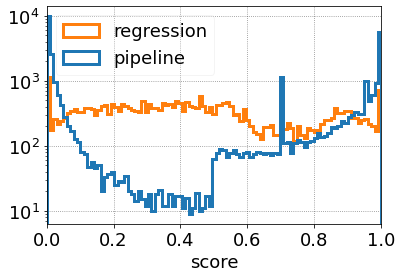

In [36]:
# Distribution of true vs predicted scores
bins = np.linspace(0, 1, 100)
yr = trained_lgbm['regression'].predict(X_validation)
yr = [0 if s<0 else 1 if s>1 else s for s in yr]
plt.hist([yS_validation, yr], bins, log=True,
         histtype='step', label=['pipeline', 'regression'], linewidth=3)
plt.legend(loc='upper left', framealpha=0.2, fontsize=18)
plt.xlabel('score', fontsize=18)
plt.xlim([0,1])
plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_score_regression_vs_pipeline.pdf', bbox_inches='tight', pad_inches=0)

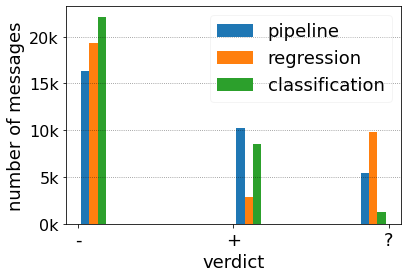

In [37]:
# Distribution of true vs predicted classes (three-class setting)
yr_v_T = ['-' if s<.5 else '?' if s<.9 else '+' for s in yr]
yc_T = trained_lgbm['threeclass'].predict(X_validation)
plt.hist([yV_T_validation, yr_v_T, yc_T], label=['pipeline', 'regression', 'classification'])
plt.legend(loc='upper right', framealpha=0.2, fontsize=18)
plt.xlabel('verdict', fontsize=18)
plt.ylabel('number of messages', fontsize=18)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=16, ticks=[t for t in range(0,20001,5000)], labels=[f'{int(t/1000)}k' for t in range(0,20001,5000)])
plt.grid(axis='y', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_verdict_regression_vs_classification.pdf', bbox_inches='tight', pad_inches=0)

regr_A: 0.758132115601151
regr_C: 0.7390529213061429
regr_T: 0.599117978230952
clas_A: 0.761791567621669
clas_C: 0.7697672963843363
clas_T: 0.6622669836106593


Text(0.5, 1.0, 'regr_T')

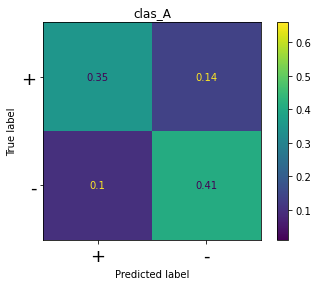

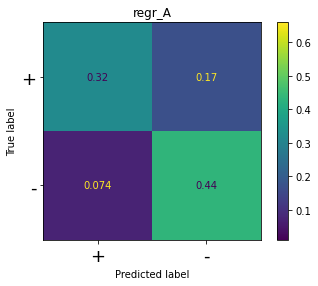

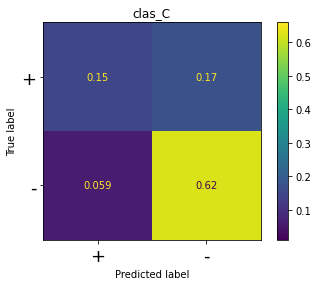

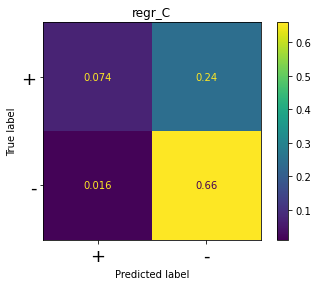

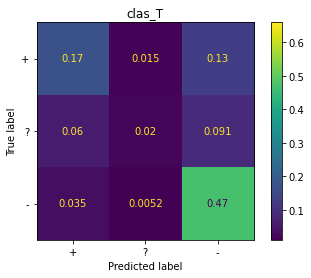

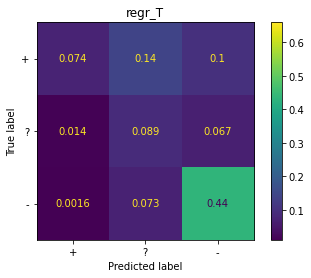

In [38]:
# Confusion matrixes for different approaches
labels_T=['+', '?', '-']
labels_B=['+', '-']
yr = trained_lgbm['regression'].predict(X_validation)
yr = [0 if s<0 else 1 if s>1 else s for s in yr]
yr_v_A = ['-' if s<.5 else '+' for s in yr]
yr_v_C = ['-' if s<.9 else '+' for s in yr]
yr_v_T = ['-' if s<.5 else '?' if s<.9 else '+' for s in yr]
yc_A = trained_lgbm['aggressive'].predict(X_validation)
yc_C = trained_lgbm['conservative'].predict(X_validation)
yc_T = trained_lgbm['threeclass'].predict(X_validation)
print(f'regr_A: {accuracy_score(yV_A_validation, yr_v_A)}')
print(f'regr_C: {accuracy_score(yV_C_validation, yr_v_C)}')
print(f'regr_T: {accuracy_score(yV_T_validation, yr_v_T)}')
print(f'clas_A: {accuracy_score(yV_A_validation, yc_A)}')
print(f'clas_C: {accuracy_score(yV_C_validation, yc_C)}')
print(f'clas_T: {accuracy_score(yV_T_validation, yc_T)}')

cfd = ConfusionMatrixDisplay(confusion_matrix(yV_A_validation, yc_A, labels=labels_B, normalize='all'), display_labels=labels_B).plot()
cfd.ax_.get_images()[0].set_clim(0.01, .66)
#cfd.im_.colorbar.remove()
#cfd.ax_.set_xlabel(None)
cfd.ax_.tick_params(axis='both', labelsize=18)
#plt.savefig(f'{figure_path}fig_confmat_baseline_aggr_clas.pdf', bbox_inches='tight', pad_inches=0)
cfd.ax_.set_title('clas_A')
cfd = ConfusionMatrixDisplay(confusion_matrix(yV_A_validation, yr_v_A, labels=labels_B, normalize='all'), display_labels=labels_B).plot()
cfd.ax_.get_images()[0].set_clim(0.01, .66)
#cfd.ax_.set_xlabel(None)
#cfd.ax_.set_ylabel(None)
cfd.ax_.tick_params(axis='both', labelsize=18)
#plt.savefig(f'{figure_path}fig_confmat_baseline_aggr_regr.pdf', bbox_inches='tight', pad_inches=0)
cfd.ax_.set_title('regr_A')

cfd = ConfusionMatrixDisplay(confusion_matrix(yV_C_validation, yc_C, labels=labels_B, normalize='all'), display_labels=labels_B).plot()
cfd.ax_.get_images()[0].set_clim(0.01, .66)
#cfd.im_.colorbar.remove()
#cfd.ax_.set_xlabel(None)
cfd.ax_.tick_params(axis='both', labelsize=18)
#plt.savefig(f'{figure_path}fig_confmat_baseline_cons_clas.pdf', bbox_inches='tight', pad_inches=0)
cfd.ax_.set_title('clas_C')
cfd = ConfusionMatrixDisplay(confusion_matrix(yV_C_validation, yr_v_C, labels=labels_B, normalize='all'), display_labels=labels_B).plot()
cfd.ax_.get_images()[0].set_clim(0.01, .66)
#cfd.ax_.set_xlabel(None)
#cfd.ax_.set_ylabel(None)
cfd.ax_.tick_params(axis='both', labelsize=18)
#plt.savefig(f'{figure_path}fig_confmat_baseline_cons_regr.pdf', bbox_inches='tight', pad_inches=0)
cfd.ax_.set_title('regr_C')

cfd = ConfusionMatrixDisplay(confusion_matrix(yV_T_validation, yc_T, labels=labels_T, normalize='all'), display_labels=labels_T).plot()
cfd.ax_.get_images()[0].set_clim(0.01, .66)
#cfd.im_.colorbar.remove()
#plt.savefig(f'{figure_path}fig_confmat_baseline_thre_clas.pdf', bbox_inches='tight', pad_inches=0)
cfd.ax_.set_title('clas_T')
cfd = ConfusionMatrixDisplay(confusion_matrix(yV_T_validation, yr_v_T, labels=labels_T, normalize='all'), display_labels=labels_T).plot()
cfd.ax_.get_images()[0].set_clim(0.01, .66)
#cfd.ax_.set_ylabel(None)
#plt.savefig(f'{figure_path}fig_confmat_baseline_thre_regr.pdf', bbox_inches='tight', pad_inches=0)
cfd.ax_.set_title('regr_T')

### 5.4.3 Observed Lack of Overfitting in Deep Trees
Train tree models with increasing depth. Show that both test and validation scores increase.

In [39]:
evaluated_trees = {'DecisionTree': {2: {'cv_scores': array([0.04665956, 0.04758158, 0.04590201, 0.0511914 , 0.03593053,
       0.0531924 , 0.0457031 , 0.05796355, 0.05052623, 0.04524867]),
                      'training_mae': 0.4155714963983755,
                      'training_score': 0.05191706690976161,
                      'validation_mae': 0.41590268079573206,
                      'validation_score': 0.049996573586486015},
                  4: {'cv_scores': array([0.08230078, 0.07316166, 0.0730169 , 0.08163034, 0.06964809,
       0.08292535, 0.07168007, 0.09578326, 0.08256774, 0.06846891]),
                      'training_mae': 0.4023464191311813,
                      'training_score': 0.08346078127486056,
                      'validation_mae': 0.40277344924939146,
                      'validation_score': 0.08109834047559727},
                  6: {'cv_scores': array([0.09658678, 0.08710666, 0.08857982, 0.0955314 , 0.08406239,
       0.09822735, 0.0907233 , 0.1108052 , 0.09699924, 0.08451551]),
                      'training_mae': 0.3965403240989864,
                      'training_score': 0.09802383972918394,
                      'validation_mae': 0.39698127016308626,
                      'validation_score': 0.09659923468934617},
                  8: {'cv_scores': array([0.11181431, 0.10123181, 0.09672103, 0.11257155, 0.09155132,
       0.10953503, 0.0977574 , 0.12603599, 0.11141733, 0.09667271]),
                      'training_mae': 0.39128156923613655,
                      'training_score': 0.11095840170667814,
                      'validation_mae': 0.390727050953178,
                      'validation_score': 0.11375836864904532},
                  10: {'cv_scores': array([0.12370885, 0.12076658, 0.11115036, 0.12663577, 0.09631853,
       0.11477057, 0.10446572, 0.1359094 , 0.12611092, 0.10779351]),
                       'training_mae': 0.38684191608238444,
                       'training_score': 0.12241397086715566,
                       'validation_mae': 0.38550010937388024,
                       'validation_score': 0.12793493348609541},
                  14: {'cv_scores': array([0.14297371, 0.14006979, 0.1227049 , 0.14145694, 0.10894397,
       0.12511785, 0.12045331, 0.15200671, 0.14467319, 0.12403873]),
                       'training_mae': 0.3818282017685871,
                       'training_score': 0.1387642144165363,
                       'validation_mae': 0.3802692809834864,
                       'validation_score': 0.14422658454816517},
                  20: {'cv_scores': array([0.16000458, 0.15641197, 0.1403343 , 0.15873651, 0.12420304,
       0.14586128, 0.13460274, 0.16675784, 0.1585201 , 0.13820573]),
                       'training_mae': 0.37494305818443,
                       'training_score': 0.15534602132168152,
                       'validation_mae': 0.3732034140600117,
                       'validation_score': 0.1589839902849155},
                  30: {'cv_scores': array([0.17508326, 0.17410269, 0.15735437, 0.1802162 , 0.14173075,
       0.16940976, 0.14557911, 0.1916038 , 0.17250582, 0.15411432]),
                       'training_mae': 0.3682500768161883,
                       'training_score': 0.17329854138928413,
                       'validation_mae': 0.366905981674557,
                       'validation_score': 0.17605964760629},
                  50: {'cv_scores': array([0.19829165, 0.19337364, 0.18512201, 0.20635739, 0.16688547,
       0.19260149, 0.1780667 , 0.21484532, 0.1952954 , 0.17801389]),
                       'training_mae': 0.358800549567528,
                       'training_score': 0.19747815055669815,
                       'validation_mae': 0.3578012845196638,
                       'validation_score': 0.19611553604078302},
                  100: {'cv_scores': array([0.22159081, 0.22412991, 0.21026486, 0.23074208, 0.19729384,
       0.23187311, 0.21469883, 0.24770055, 0.22251043, 0.20357114]),
                        'training_mae': 0.34617405264380285,
                        'training_score': 0.2287615975719779,
                        'validation_mae': 0.34577412504542077,
                        'validation_score': 0.2249460143353046},
                  200: {'cv_scores': array([0.24995666, 0.2515678 , 0.23709607, 0.26304901, 0.22970758,
       0.26856953, 0.24949469, 0.27672755, 0.25623375, 0.22864186]),
                        'training_mae': 0.331881332817999,
                        'training_score': 0.2647436431420449,
                        'validation_mae': 0.3328116440702132,
                        'validation_score': 0.25716687779217196},
                  400: {'cv_scores': array([0.27998043, 0.27570372, 0.26762414, 0.28618707, 0.25826175,
       0.29816796, 0.28054049, 0.30582535, 0.27695351, 0.24882579]),
                        'training_mae': 0.3167526777542484,
                        'training_score': 0.30142947414248855,
                        'validation_mae': 0.31929238049347214,
                        'validation_score': 0.2853640237647319}},
 'LightGBM': {2: {'cv_scores': array([0.19708319, 0.18521456, 0.18085912, 0.19610395, 0.18101343,
       0.20553967, 0.18322159, 0.22034226, 0.19560903, 0.17756656]),
                  'training_mae': 0.3674303000422762,
                  'training_score': 0.19714064765443917,
                  'validation_mae': 0.3660960102337516,
                  'validation_score': 0.20024710447905836},
              4: {'cv_scores': array([0.26070775, 0.24575677, 0.24127186, 0.26279157, 0.23929956,
       0.27081621, 0.25259799, 0.28570396, 0.25739257, 0.23462856]),
                  'training_mae': 0.34215652350102677,
                  'training_score': 0.26217244753543645,
                  'validation_mae': 0.3416026834733177,
                  'validation_score': 0.26052023170230465},
              6: {'cv_scores': array([0.28493259, 0.27271096, 0.26966263, 0.28932011, 0.26692573,
       0.29596331, 0.28054641, 0.3135994 , 0.28425934, 0.2576201 ]),
                  'training_mae': 0.330029336073484,
                  'training_score': 0.2936090253356777,
                  'validation_mae': 0.33010057519814856,
                  'validation_score': 0.28926649620138667},
              8: {'cv_scores': array([0.29817658, 0.2890831 , 0.28435241, 0.30795973, 0.28140268,
       0.31300313, 0.29822787, 0.32981995, 0.29794524, 0.27316037]),
                  'training_mae': 0.32261706606498103,
                  'training_score': 0.31311044305943403,
                  'validation_mae': 0.3233069883254885,
                  'validation_score': 0.3055685814040261},
              10: {'cv_scores': array([0.30975111, 0.29894549, 0.29551753, 0.31847914, 0.28975702,
       0.32588121, 0.31142296, 0.34018593, 0.31169853, 0.28332856]),
                   'training_mae': 0.31733836464175785,
                   'training_score': 0.3272685274325535,
                   'validation_mae': 0.3185264280467926,
                   'validation_score': 0.3175506195919976},
              14: {'cv_scores': array([0.32372456, 0.31436867, 0.31021598, 0.33496656, 0.3099719 ,
       0.33879544, 0.32641723, 0.35482042, 0.32600052, 0.2950012 ]),
                   'training_mae': 0.3090297582761142,
                   'training_score': 0.34895146676452427,
                   'validation_mae': 0.3113993599809297,
                   'validation_score': 0.3334403349708803},
              20: {'cv_scores': array([0.33562451, 0.32973155, 0.32470363, 0.34972324, 0.32304638,
       0.35261184, 0.34084984, 0.36952016, 0.33805402, 0.30543121]),
                   'training_mae': 0.3008879400714044,
                   'training_score': 0.36894247457789053,
                   'validation_mae': 0.30458965740033156,
                   'validation_score': 0.3471538908356717},
              30: {'cv_scores': array([0.34830791, 0.34431461, 0.33965826, 0.36463843, 0.3377672 ,
       0.36720875, 0.35739105, 0.3831827 , 0.35283004, 0.31510378]),
                   'training_mae': 0.2916536166604794,
                   'training_score': 0.39150812479356334,
                   'validation_mae': 0.29788997605015455,
                   'validation_score': 0.3588550674255392},
              50: {'cv_scores': array([0.35677911, 0.35822557, 0.35210399, 0.38028381, 0.35073913,
       0.37914387, 0.37156454, 0.39639557, 0.36285725, 0.32463835]),
                   'training_mae': 0.28042113733202845,
                   'training_score': 0.4174203039227218,
                   'validation_mae': 0.2896942212921344,
                   'validation_score': 0.372041083700107},
              100: {'cv_scores': array([0.36678826, 0.36722598, 0.36523083, 0.38836873, 0.36384591,
       0.38933118, 0.38573907, 0.40539984, 0.3736556 , 0.33246274]),
                    'training_mae': 0.2662297862725826,
                    'training_score': 0.44948618375001015,
                    'validation_mae': 0.2809733375973221,
                    'validation_score': 0.3817181602989397},
              200: {'cv_scores': array([0.36486383, 0.36924804, 0.36887337, 0.3900062 , 0.36882774,
       0.39027916, 0.38852247, 0.40767832, 0.37695675, 0.33292023]),
                    'training_mae': 0.25478530433815155,
                    'training_score': 0.47367528499065725,
                    'validation_mae': 0.2751038387584132,
                    'validation_score': 0.38419161934994883},
              400: {'cv_scores': array([0.3602981 , 0.36596597, 0.36726884, 0.38883985, 0.36702625,
       0.38329691, 0.38788617, 0.4053257 , 0.37332174, 0.32786375]),
                    'training_mae': 0.24397413246041072,
                    'training_score': 0.4952999152816129,
                    'validation_mae': 0.2702791232799456,
                    'validation_score': 0.383434153963608}},
 'RandomForest': {2: {'cv_scores': array([0.04808328, 0.04918019, 0.04897259, 0.05395619, 0.03831705,
       0.05703064, 0.04924568, 0.06077356, 0.0529627 , 0.04807914]),
                      'training_mae': 0.4148790161145226,
                      'training_score': 0.054611682732865985,
                      'validation_mae': 0.41513584733149256,
                      'validation_score': 0.05288766856402627},
                  4: {'cv_scores': array([0.08767505, 0.07845367, 0.08309988, 0.08664624, 0.076294  ,
       0.09118758, 0.08235422, 0.10206598, 0.0889837 , 0.0749753 ]),
                      'training_mae': 0.4019024387390719,
                      'training_score': 0.08980381959117989,
                      'validation_mae': 0.4023231334145416,
                      'validation_score': 0.08722919875749158},
                  6: {'cv_scores': array([0.10685726, 0.09656922, 0.09899509, 0.10533117, 0.09337228,
       0.11032216, 0.1007517 , 0.12234186, 0.10765737, 0.09131706]),
                      'training_mae': 0.39561389954400134,
                      'training_score': 0.10761570843847434,
                      'validation_mae': 0.39567536237184,
                      'validation_score': 0.10674429911427641},
                  8: {'cv_scores': array([0.11930278, 0.1105412 , 0.11001162, 0.12000318, 0.10176406,
       0.12076423, 0.1110101 , 0.13473988, 0.12210846, 0.10305617]),
                      'training_mae': 0.3909936133226359,
                      'training_score': 0.11978355204051172,
                      'validation_mae': 0.39055069028202255,
                      'validation_score': 0.1218573443587938},
                  10: {'cv_scores': array([0.1318828 , 0.12618975, 0.12143346, 0.132605  , 0.10533623,
       0.12682008, 0.11772345, 0.14389185, 0.13422073, 0.11480488]),
                       'training_mae': 0.3868660641178591,
                       'training_score': 0.12967539425282137,
                       'validation_mae': 0.38584416055472903,
                       'validation_score': 0.13370504636161717},
                  14: {'cv_scores': array([0.15121418, 0.14579842, 0.13652492, 0.15035065, 0.11997393,
       0.13966379, 0.13487581, 0.16200097, 0.15287295, 0.13207108]),
                       'training_mae': 0.3815303277767564,
                       'training_score': 0.1471235170470534,
                       'validation_mae': 0.3804092089161253,
                       'validation_score': 0.1506434023644725},
                  20: {'cv_scores': array([0.1700781 , 0.16595832, 0.15485982, 0.16981507, 0.13716011,
       0.15924349, 0.14897584, 0.17870921, 0.17003032, 0.14699988]),
                       'training_mae': 0.37529001684936136,
                       'training_score': 0.1648485677170628,
                       'validation_mae': 0.3739218799134493,
                       'validation_score': 0.16872278066201907},
                  30: {'cv_scores': array([0.18840144, 0.18343037, 0.17529311, 0.18952484, 0.15786825,
       0.18091791, 0.16672637, 0.20069368, 0.18819077, 0.16458315]),
                       'training_mae': 0.3679002035592491,
                       'training_score': 0.18489390059316513,
                       'validation_mae': 0.3667888832418457,
                       'validation_score': 0.18723341167044627},
                  50: {'cv_scores': array([0.20963023, 0.20589821, 0.19791427, 0.21462002, 0.18070725,
       0.20582655, 0.19207909, 0.2259394 , 0.21184185, 0.18819209]),
                       'training_mae': 0.35856420447338583,
                       'training_score': 0.2086654940388215,
                       'validation_mae': 0.35750602387034136,
                       'validation_score': 0.20904793978819136},
                  100: {'cv_scores': array([0.24287402, 0.23909787, 0.22751211, 0.24844773, 0.21585834,
       0.24717993, 0.23114389, 0.26255686, 0.24359605, 0.21896492]),
                        'training_mae': 0.34591061372486603,
                        'training_score': 0.24584976156491478,
                        'validation_mae': 0.3453556792615227,
                        'validation_score': 0.24418608485182602},
                  200: {'cv_scores': array([0.27847465, 0.2733232 , 0.26102268, 0.28312528, 0.25366768,
       0.28732127, 0.26993045, 0.30001256, 0.27787184, 0.24956954]),
                        'training_mae': 0.33183315576695965,
                        'training_score': 0.28611198873855304,
                        'validation_mae': 0.3325213810690558,
                        'validation_score': 0.28029285727946707},
                  400: {'cv_scores': array([0.31036096, 0.3036408 , 0.29497817, 0.31730405, 0.28951471,
       0.32287698, 0.30659547, 0.33403862, 0.30897033, 0.27837621]),
                        'training_mae': 0.31656184714078345,
                        'training_score': 0.32760243085615015,
                        'validation_mae': 0.31899538660343846,
                        'validation_score': 0.31320167302192914}}}

In [40]:
NUM_ESTIMATORS = 750
RAND_STATE = 27
# Fit several regression models.
models = [{
    'name': 'DecisionTree', 'type': 'regression', 'marker': 'b^',
    'model': DecisionTreeRegressor(),
    'p_vals': {'max_leaf_nodes': 0,
               'random_state': RAND_STATE}
    }, {
    'name': 'LightGBM', 'type': 'regression', 'marker': 'mo',
    'model': LGBMRegressor(),
    'p_vals': {'num_leaves': 0,
               'n_estimators': NUM_ESTIMATORS,
               'random_state': RAND_STATE}  #prevent this parameter to limit max_depth
    }, {
    'name': 'RandomForest', 'type': 'regression', 'marker': 'cX',
    'model': RandomForestRegressor(),
    'p_vals': {'max_leaf_nodes': 0,
               'n_estimators': NUM_ESTIMATORS,
               'random_state': RAND_STATE}
}]

In [41]:
# Create splits for cross-validation.
kf = KFold(n_splits=10)
leaf_cnts = [2, 4, 6, 8, 10, 14, 20, 30, 50, 100, 200, 400]

# Tune and evaluate models.
for model in models:
    clf = model.pop('model')
    params = model['p_vals']
    mname = model['name']
    mtype = model['type']
    if mname not in evaluated_trees:
        evaluated_trees[mname] = {}
    for num_leaves in leaf_cnts:
        if 'max_leaf_nodes' in params:
            params['max_leaf_nodes'] = num_leaves
        else:
            params['num_leaves'] = num_leaves
        # Skip models that have already been trained and scored.
        if (mname in evaluated_trees and
            num_leaves in evaluated_trees[mname]):
            print(f'Found stats for {mname}, num_leaves {num_leaves}')
            continue

        print(f'Training {mname}, num_leaves {num_leaves}')
        evaluated_trees[mname][num_leaves] = {}
        clf.set_params(**params)
        cv_scores = cross_val_score(clf,
                                    X = X,
                                    y = model_types[model['type']]['target'],
                                    cv = kf)
        evaluated_trees[mname][num_leaves]['cv_scores'] = cv_scores
        
        clf.fit(X, model_types[mtype]['target'])

        training_score = clf.score(X, model_types[mtype]['target'])
        evaluated_trees[mname][num_leaves]['training_score'] = training_score
        validation_score = clf.score(X_validation, model_types[mtype]['validation_target'])
        evaluated_trees[mname][num_leaves]['validation_score'] = validation_score
        
        preds = clf.predict(X)
        training_mae = mean_absolute_error(model_types[mtype]['target'], preds)
        evaluated_trees[mname][num_leaves]['training_mae'] = training_mae
        preds = clf.predict(X_validation)
        validation_mae = mean_absolute_error(model_types[mtype]['validation_target'], preds)
        evaluated_trees[mname][num_leaves]['validation_mae'] = validation_mae

Found stats for DecisionTree, num_leaves 2
Found stats for DecisionTree, num_leaves 4
Found stats for DecisionTree, num_leaves 6
Found stats for DecisionTree, num_leaves 8
Found stats for DecisionTree, num_leaves 10
Found stats for DecisionTree, num_leaves 14
Found stats for DecisionTree, num_leaves 20
Found stats for DecisionTree, num_leaves 30
Found stats for DecisionTree, num_leaves 50
Found stats for DecisionTree, num_leaves 100
Found stats for DecisionTree, num_leaves 200
Found stats for DecisionTree, num_leaves 400
Found stats for LightGBM, num_leaves 2
Found stats for LightGBM, num_leaves 4
Found stats for LightGBM, num_leaves 6
Found stats for LightGBM, num_leaves 8
Found stats for LightGBM, num_leaves 10
Found stats for LightGBM, num_leaves 14
Found stats for LightGBM, num_leaves 20
Found stats for LightGBM, num_leaves 30
Found stats for LightGBM, num_leaves 50
Found stats for LightGBM, num_leaves 100
Found stats for LightGBM, num_leaves 200
Found stats for LightGBM, num_leave

In [42]:
#pprint(evaluated_trees)

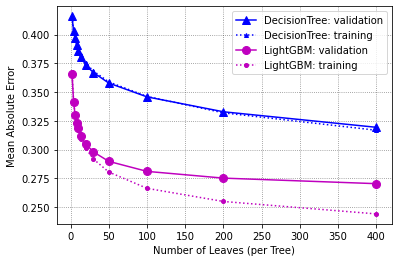

In [43]:
lgd = []
for model in models:
    mname = model['name']
    mmark = model['marker']
    if mname == 'RandomForest':
        continue
    if mname == 'LightGBM':
        vs = [scores['validation_score'] for _, scores in sorted(evaluated_trees[mname].items())]
    lgd.append(f'{mname}: validation')
    plt.plot(sorted(evaluated_trees[mname]),
             [scores['validation_mae'] for _, scores in sorted(evaluated_trees[mname].items())],
#             [scores['validation_score'] for _, scores in sorted(evaluated_trees[mname].items())],
             f'{mmark}-', markersize=8)
    lgd.append(f'{mname}: training')
    plt.plot(sorted(evaluated_trees[mname]),
             [scores['training_mae'] for _, scores in sorted(evaluated_trees[mname].items())],
#             [scores['training_score'] for _, scores in sorted(evaluated_trees[mname].items())],
             f'{mmark}:', markersize=4)
#    lgd.append(f'{mname}: average cv')
#    plt.plot(sorted(evaluated_trees[mname]),
#             [np.mean(scores['cv_scores']) for _, scores in sorted(evaluated_trees[mname].items())],
#             f'{mmark}--', markersize=4)
plt.legend(lgd, ncol=1)
#plt.plot([0,400], [max(vs),max(vs)], 'k')
plt.xlabel('Number of Leaves (per Tree)')
plt.ylabel('Mean Absolute Error')
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.xscale('log')
#plt.ylabel('$R^2$ score', usetex=True)
#plt.savefig(f'{figure_path}fig_tree_depth_vs_r2.pdf', bbox_inches='tight', pad_inches=0)
#plt.savefig(f'{figure_path}fig_tree_depth_vs_mae.pdf', bbox_inches='tight', pad_inches=0)

## 5.5 Pipeline Optimization for Application Constraints

### 5.5.1 FP Avoidance
Disproportionally weigh non-positive samples to reduce FPs

In [44]:
# Collection of parameters for comparison.
ls =      [0, 1, 2, 5, 10, 20, 50, 100, 500]
lambdas = [   1, 2, 3, 4,  5,  6,  7,   8,   9]
etas    = [  0, .2, 1]

# Determine base class weights.
penalties={'-':{'-':3, '?':6, '+':11},
           '?':{'-':4, '?':2, '+':7},
           '+':{'-':5, '?':3, '+':1}}
sum_pos = sum(penalties['+'].values())
class_weights = {cl:sum(pens.values())/sum_pos - 1
                 for cl,pens in penalties.items()}

yV_hot_A_validation = pd.Series([int(v=='+') for v in yV_A_validation])
P_A_validation = sum(yV_hot_A_validation)
N_A_validation = len(yV_hot_A_validation) - P_A_validation

roc_curves = {}
roc_marks = {}
for mtype in ['aggressive', 'conservative']:
    roc_curves[mtype] = {}
    for l in ls:
        roc_curves[mtype][l] = {'fpr_regr': [],
                                'tpr_regr': []}
    roc_marks[mtype] = {'fpr_clas': [],
                        'tpr_clas': [],
                        'fpr_regr': [],
                        'tpr_regr': []}

bmin = .05
heatmaps = {}
for e in etas:
    heatmaps[e] = np.zeros((len(lambdas),len(ls)))

In [45]:
# Train models with increasing class-weights
for col,l in enumerate(ls):
    if l>0:
        weights = [l*class_weights['-']+1 if s<.5 else
                   l*class_weights['?']+1 if s<.9 else
                   l*class_weights['+']+1 for s in yS]
        cweights = {c:cw*l+1 for c,cw in class_weights.items()}
    else:
        weights = None
        cweights = None

    print(f"Starting with {l}")
    if heatmaps[0][0][col] != 0:
        # Already processed, skipping...
        continue

    # Producing ROC curves for native classification
    for mtype in ['aggressive', 'conservative']:
        target = model_types[mtype]['target']
        clf = LGBMClassifier()
        clf.set_params(**lgbm_base_params)
        clf.fit(X, target, sample_weight=weights)
        y_pred = clf.predict(X_validation)
        validation_target = model_types[mtype]['validation_target']
        _, fpr, _, tpr = confusion_matrix(validation_target, y_pred,
                                        labels=['-', '+'],
                                        normalize='true').ravel()
        roc_marks[mtype]['fpr_clas'].append(fpr)
        roc_marks[mtype]['tpr_clas'].append(tpr)

    # Producing ROC curves for regression-classification
    clf = LGBMRegressor()
    clf.set_params(**lgbm_base_params)
    clf.fit(X, yS, sample_weight=weights)
    y_pred = clf.predict(X_validation)
    for mtype in model_types:
        if mtype == 'aggressive':
            y_clas = ['-' if s<.5 else '+' for s in y_pred]
        elif mtype == 'conservative':
            y_clas = ['-' if s<.9 else '+' for s in y_pred]
        else:
            continue
        validation_target = model_types[mtype]['validation_target']
        _, fpr, _, tpr = confusion_matrix(validation_target, y_clas,
                                        labels=['-', '+'],
                                        normalize='true').ravel()
        roc_marks[mtype]['fpr_regr'].append(fpr)
        roc_marks[mtype]['tpr_regr'].append(tpr)

        roc_p_fpr, roc_p_tpr, _ = roc_curve([int(v=='+') for v in validation_target],
                                             y_pred, pos_label=1)
        roc_curves[mtype][l]['fpr_regr'] = roc_p_fpr
        roc_curves[mtype][l]['tpr_regr'] = roc_p_tpr

    # Producing heatmaps for regression models
    for e in etas:
        for row,lmbda in enumerate(lambdas):
            _, best_valid_util = max_util_vals(yV_hot_A_validation, y_pred,
                                               bmin, e, lmbda,
                                               N_A_validation, P_A_validation, pos_label=1)
            utility_val = best_valid_util[0]
            heatmaps[e][row][col] = utility_val

Starting with 0
Starting with 1
Starting with 2
Starting with 5
Starting with 10
Starting with 20
Starting with 50
Starting with 100
Starting with 500


Text(0, 0.5, 'TP rate')

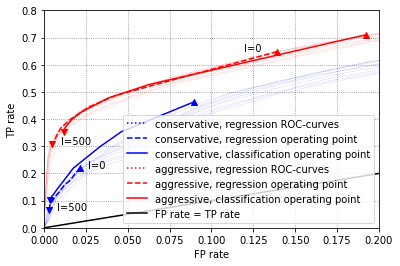

In [46]:
# ROC curves
lgd = []
for mtype in ['conservative', 'aggressive']:
    plt.plot(100, 100,
             color=model_types[mtype]['color'],
             linestyle=':')
    lgd.append(f'{mtype}, regression ROC-curves')
    plt.plot(100, 100,
             color=model_types[mtype]['color'],
             linestyle='dashed')
    lgd.append(f'{mtype}, regression operating point')
    plt.plot(100, 100,
             color=model_types[mtype]['color'],
             linestyle='solid')
    lgd.append(f'{mtype}, classification operating point')
plt.plot([0,1],[0,1], 'k')
lgd.append('FP rate = TP rate')
             
for mtype in ['aggressive', 'conservative']:
    for l in ls:
        plt.plot(roc_curves[mtype][l]['fpr_regr'],
                 roc_curves[mtype][l]['tpr_regr'],
                 color=model_types[mtype]['color'],
                 linewidth=.2, linestyle=':')
    plt.plot(roc_marks[mtype]['fpr_regr'],
             roc_marks[mtype]['tpr_regr'],
             color=model_types[mtype]['color'], linestyle='dashed')
    plt.plot(roc_marks[mtype]['fpr_clas'],
             roc_marks[mtype]['tpr_clas'],
             color=model_types[mtype]['color'], linestyle='solid')

    plt.scatter(roc_marks[mtype]['fpr_clas'][0],
                roc_marks[mtype]['tpr_clas'][0],
                c=model_types[mtype]['color'],
                marker='^')
    plt.scatter(roc_marks[mtype]['fpr_regr'][0],
                roc_marks[mtype]['tpr_regr'][0],
                c=model_types[mtype]['color'],
                marker='^')
    if mtype == 'aggressive':
        plt.annotate('l=0', (roc_marks[mtype]['fpr_regr'][0]-.02,
                             roc_marks[mtype]['tpr_regr'][0]))
    else:
        plt.annotate('l=0', (roc_marks[mtype]['fpr_regr'][0]+.005,
                             roc_marks[mtype]['tpr_regr'][0]))
    plt.scatter(roc_marks[mtype]['fpr_clas'][-1],
                roc_marks[mtype]['tpr_clas'][-1],
                c=model_types[mtype]['color'],
                marker='v')
    plt.scatter(roc_marks[mtype]['fpr_regr'][-1],
                roc_marks[mtype]['tpr_regr'][-1],
                c=model_types[mtype]['color'],
                marker='v')
    plt.annotate('l=500', (roc_marks[mtype]['fpr_regr'][-1]+.005,
                           roc_marks[mtype]['tpr_regr'][-1]))

plt.legend(lgd)
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)

plt.xlim([0,.2])
plt.ylim([0,.8])
plt.xlabel('FP rate')
plt.ylabel('TP rate')
#plt.savefig(f'{figure_path}fig_roc_l_classweight.pdf', bbox_inches='tight', pad_inches=0)

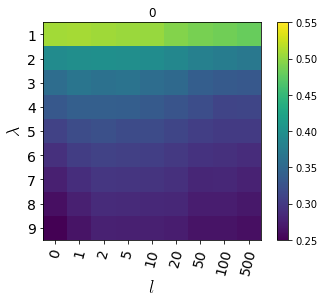

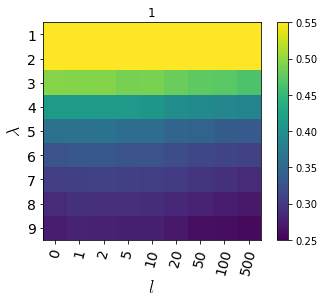

In [47]:
for e in [0,1]:
    plt.imshow(heatmaps[e], cmap='viridis', vmin=.25, vmax=.55)
    plt.colorbar()
    plt.xlabel(r'$l$', fontsize=18, usetex=True)
    plt.ylabel('$\lambda$', fontsize=18, usetex=True)
    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(range(len(ls)), ls, rotation=75)
    plt.yticks(range(len(lambdas)), lambdas)
#    plt.savefig(f'{figure_path}fig_classweight_e{e}.pdf', bbox_inches='tight', pad_inches=0)
    plt.title(f'{e}')
    plt.show()

### 5.5.2 Reducing the Number of Features

#### 5.5.2.1 Cost Efficient Gradient Boosting
Penalize first time a feature is used in an ensamble.

In [48]:
# Caching and serving huge lists of domains is expensive.
# The number of domains associated with a given feature is unknown.
# We approximate it with the number of associated domains present in the data,
# and set feature cost accordingly.
#
# dkim/dmarc/spf are assumed to always happen for a message and are assigned cost 0.
#
# While prevalence is determined accross all contexts,
# our modeling treats each feature separately per context. Depending on the actual SDR
# implementation this might not be accurate: a feature, once present, might be assumed
# free to use for all other contexts. Beyond the scope of this research.
#
fid_prevalence = {}
for field in ['envFrom', 'helo', 'rdns', 'headerFrom', 'headerReplyto', 'listUnsub']:
    for fid in range(70):
        if fid not in fid_prevalence:
            fid_prevalence[fid] = 0
        if f'{field}.feature.{fid}' in fullDF.columns:
            fid_prevalence[fid] += len(set(fullDF[fullDF[f'{field}.feature.{fid}']==1][f'{field}.domain.registered']))
#{k: v for k, v in sorted(fid_prevalence.items(), key=lambda item: item[1])}
feature_cost_cachesize = [0 if c.split('.')[-1] in ['align', 'pass'] else
                          fid_prevalence[int(c.split('.')[-1])]
                          for c in list(X.columns)]
max_prevalence = max(feature_cost_cachesize)
feature_cost_cachesize = [c/max_prevalence for c in feature_cost_cachesize]

In [49]:
models = [{
    'name': 'base',
    'alpha': 0,
    'gamma': 0,
    'model': LGBMRegressor(),
    'p_vals': lgbm_base_params
}]

gammas = [0, 1, 50, 100, 500, 1000, 5000, 10000]
alphas = [0.0, 0.0000001, 0.0000005, 0.000001, 0.000005]
for gamma in gammas:
    for alpha in alphas:
        cegb_params = {
            'cegb_penalty_feature_coupled': [c*gamma for c in feature_cost_cachesize],
            'cegb_penalty_split': alpha}
        cegb_params.update(lgbm_base_params)
        models.append({
            'name': f'cegb_g{gamma:05d}_a{int(alpha*10000000):07d}',
            'alpha': alpha,
            'gamma': gamma,
            'model': LGBMRegressor(),
            'p_vals': cegb_params})

In [50]:
evaluated_cegb = {'base': {'accuracy': 0.7566620793194044,
          'alpha': 0,
          'auc': 0.8439447186938875,
          'b_fpr': 0.025072028443572612,
          'b_rho': 0.6906025938325131,
          'b_tcr': 1.4379247015610652,
          'b_tpr': 0.43514911552461844,
          'b_utility': 0.2652348594550214,
          'feature_cost': 13.737520502327731,
          'fscore': 0.722934472934473,
          'gamma': 0,
          'num_features': 194,
          'precision': 0.8171644795105064,
          'r2': 0.3734761057883763,
          'recall': 0.6481895395619133,
          'support': 15659,
          't_fit': 2.0834739208221436,
          't_fpr': 0.956721633053393,
          't_rho': 0.004831094842018533,
          't_tcr': 1.0001277383917737,
          't_tpr': 0.9968069480809758,
          't_train': 1.089669942855835,
          't_utility': 0.8787316512268178,
          't_val': 0.2944157123565674},
 'cegb_g00000_a0000000': {'accuracy': 0.7562241961716502,
                          'alpha': 0.0,
                          'auc': 0.844725817527087,
                          'b_fpr': 0.02593023968613989,
                          'b_rho': 0.6819266931165203,
                          'b_tcr': 1.4440243452600514,
                          'b_tpr': 0.4425569959767546,
                          'b_utility': 0.2687366922380603,
                          'feature_cost': 13.740171308338434,
                          'fscore': 0.7217621019563044,
                          'gamma': 0,
                          'num_features': 194,
                          'precision': 0.8183437221727515,
                          'r2': 0.37485370423415376,
                          'recall': 0.6455712369883134,
                          'support': 15659,
                          't_fit': 2.2495288848876953,
                          't_fpr': 0.9562925274321094,
                          't_rho': -5.609276368444358e-06,
                          't_tcr': 1.000063865116873,
                          't_tpr': 0.9962960597739319,
                          't_train': 1.1333611011505127,
                          't_utility': 0.878303020659074,
                          't_val': 0.32342100143432617},
 'cegb_g00000_a0000001': {'accuracy': 0.7515013136494433,
                          'alpha': 1e-07,
                          'auc': 0.8413276296874979,
                          'b_fpr': 0.02464292282228897,
                          'b_rho': 0.6834503795095059,
                          'b_tcr': 1.4320073159579334,
                          'b_tpr': 0.4300402324541797,
                          'b_utility': 0.2624374205966526,
                          'feature_cost': 13.731224838052311,
                          'fscore': 0.712481453334781,
                          'gamma': 0,
                          'num_features': 192,
                          'precision': 0.8221145815934525,
                          'r2': 0.36875582073197355,
                          'recall': 0.6286480618174851,
                          'support': 15659,
                          't_fit': 1.8730640411376953,
                          't_fpr': 0.956721633053393,
                          't_rho': 0.012801742487399563,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.9967430870425953,
                          't_train': 0.8487160205841064,
                          't_utility': 0.8786971154920528,
                          't_val': 0.23171687126159668},
 'cegb_g00000_a0000005': {'accuracy': 0.7383022644814212,
                          'alpha': 5e-07,
                          'auc': 0.8297044607211299,
                          'b_fpr': 0.02127137865506038,
                          'b_rho': 0.6755079645690966,
                          'b_tcr': 1.41633502170767,
                          'b_tpr': 0.40475126125550803,
                          'b_utility': 0.2515207813590196,
                          'feature_cost': 13.678473798439331,
                          'fscore': 0.6895476976735557,
                          'gamma': 0,
                          'num_features': 182,
                          'precision': 0.8228834573149132,
                          'r2': 0.34704855995551465,
                          'recall': 0.593396768631458,
                          'support': 15659,
                          't_fit': 1.316450834274292,
                          't_fpr': 0.9578250475081224,
                          't_rho': 0.05292500934257019,
                          't_tcr': 1.0001277383917735,
                          't_tpr': 0.9979564467718245,
                          't_train': 0.505526065826416,
                          't_utility': 0.879745037940192,
                          't_val': 0.12167716026306152},
 'cegb_g00000_a0000010': {'accuracy': 0.7338921556361817,
                          'alpha': 1e-06,
                          'auc': 0.8244570920157233,
                          'b_fpr': 0.023784711579721694,
                          'b_rho': 0.6639797170835396,
                          'b_tcr': 1.3946384039900248,
                          'b_tpr': 0.406858675522064,
                          'b_utility': 0.24718599466307717,
                          'feature_cost': 13.653142033499554,
                          'fscore': 0.6801744229757162,
                          'gamma': 0,
                          'num_features': 179,
                          'precision': 0.826738554326967,
                          'r2': 0.33711022465540397,
                          'recall': 0.5777508142282394,
                          'support': 15659,
                          't_fit': 1.4646940231323242,
                          't_fpr': 0.9575185434929198,
                          't_rho': 0.06705149555597802,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.9975732805415416,
                          't_train': 0.5306110382080078,
                          't_utility': 0.8794290058961564,
                          't_val': 0.12418627738952637},
 'cegb_g00000_a0000050': {'accuracy': 0.7174402602276992,
                          'alpha': 5e-06,
                          'auc': 0.7988140841145434,
                          'b_fpr': 0.02586893888309937,
                          'b_rho': 0.6331184383300356,
                          'b_tcr': 1.3470107526881723,
                          'b_tpr': 0.3923622198096941,
                          'b_utility': 0.2314913125618162,
                          'feature_cost': 13.544094501234277,
                          'fscore': 0.6517079188834914,
                          'gamma': 0,
                          'num_features': 160,
                          'precision': 0.8222589746084249,
                          'r2': 0.29480543026884365,
                          'recall': 0.5397534963918513,
                          'support': 15659,
                          't_fit': 1.2139761447906494,
                          't_fpr': 0.9560473242199473,
                          't_rho': 0.12066925933892057,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.99604061562041,
                          't_train': 0.4080190658569336,
                          't_utility': 0.8780778236116574,
                          't_val': 0.08893084526062012},
 'cegb_g00001_a0000000': {'accuracy': 0.7555673714500187,
                          'alpha': 0.0,
                          'auc': 0.843959275628309,
                          'b_fpr': 0.02586893888309937,
                          'b_rho': 0.6857329589514503,
                          'b_tcr': 1.4325313329064133,
                          'b_tpr': 0.43668178044575007,
                          'b_utility': 0.2645043394706111,
                          'feature_cost': 13.713878626219778,
                          'fscore': 0.7211617368965639,
                          'gamma': 1,
                          'num_features': 192,
                          'precision': 0.8171086675291074,
                          'r2': 0.3729918045193409,
                          'recall': 0.645379653873172,
                          'support': 15659,
                          't_fit': 2.2591867446899414,
                          't_fpr': 0.9569668362655551,
                          't_rho': 0.0008254178132062693,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9971262532728782,
                          't_train': 1.1141648292541504,
                          't_utility': 0.8789913840089995,
                          't_val': 0.32895994186401367},
 'cegb_g00001_a0000001': {'accuracy': 0.7511572626047792,
                          'alpha': 1e-07,
                          'auc': 0.8415899950888504,
                          'b_fpr': 0.024152516397964813,
                          'b_rho': 0.682158762583545,
                          'b_tcr': 1.439643283993748,
                          'b_tpr': 0.4311897311450284,
                          'b_utility': 0.2644457775481703,
                          'feature_cost': 13.681273712288137,
                          'fscore': 0.7119061413673233,
                          'gamma': 1,
                          'num_features': 189,
                          'precision': 0.8221125700426528,
                          'r2': 0.3689550309767936,
                          'recall': 0.6277540072801584,
                          'support': 15659,
                          't_fit': 1.8314051628112793,
                          't_fpr': 0.9573346410837982,
                          't_rho': 0.009509791538790873,
                          't_tcr': 1.000127738391774,
                          't_tpr': 0.9974455584647807,
                          't_train': 0.8621921539306641,
                          't_utility': 0.8792946438453592,
                          't_val': 0.23394513130187988},
 'cegb_g00001_a0000005': {'accuracy': 0.7383648192168147,
                          'alpha': 5e-07,
                          'auc': 0.828805432515608,
                          'b_fpr': 0.026236743701342487,
                          'b_rho': 0.6529777093981083,
                          'b_tcr': 1.40288478767246,
                          'b_tpr': 0.4238457117312727,
                          'b_utility': 0.25407884618723353,
                          'feature_cost': 13.673735482695202,
                          'fscore': 0.6884195627071926,
                          'gamma': 1,
                          'num_features': 181,
                          'precision': 0.8259742581337147,
                          'r2': 0.34541750888247136,
                          'recall': 0.5901398556740532,
                          'support': 15659,
                          't_fit': 1.3648531436920166,
                          't_fpr': 0.9577024459020413,
                          't_rho': 0.044812257127104876,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.997764863656683,
                          't_train': 0.5309369564056396,
                          't_utility': 0.8795979036817188,
                          't_val': 0.12647795677185059},
 'cegb_g00001_a0000010': {'accuracy': 0.7349243087701739,
                          'alpha': 1e-06,
                          'auc': 0.825168489029002,
                          'b_fpr': 0.031202108747624593,
                          'b_rho': 0.6350883451690753,
                          'b_tcr': 1.3758896406291188,
                          'b_tpr': 0.4357238648700428,
                          'b_utility': 0.2512615910720846,
                          'feature_cost': 13.666081280339297,
                          'fscore': 0.6821914726065923,
                          'gamma': 1,
                          'num_features': 179,
                          'precision': 0.8263081395348837,
                          'r2': 0.33823916111703367,
                          'recall': 0.580880005108883,
                          'support': 15659,
                          't_fit': 1.298482894897461,
                          't_fpr': 0.9571507386746766,
                          't_rho': 0.07073841133813717,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.9971901143112587,
                          't_train': 0.4712529182434082,
                          't_utility': 0.8790912103250317,
                          't_val': 0.11116814613342285},
 'cegb_g00001_a0000050': {'accuracy': 0.7205054422619792,
                          'alpha': 5e-06,
                          'auc': 0.8017079173363584,
                          'b_fpr': 0.02482682523141053,
                          'b_rho': 0.636987067504989,
                          'b_tcr': 1.3531800898721051,
                          'b_tpr': 0.3903186665815186,
                          'b_utility': 0.232417334570329,
                          'feature_cost': 13.52547258900909,
                          'fscore': 0.6579914268218005,
                          'gamma': 1,
                          'num_features': 164,
                          'precision': 0.8210908396217403,
                          'r2': 0.2985379189345827,
                          'recall': 0.548949485918641,
                          'support': 15659,
                          't_fit': 1.1779956817626953,
                          't_fpr': 0.9559860234169067,
                          't_rho': 0.1211646947217031,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.9959767545820295,
                          't_train': 0.4009699821472168,
                          't_utility': 0.8780215243498033,
                          't_val': 0.08699798583984375},
 'cegb_g00050_a0000000': {'accuracy': 0.7227261353684474,
                          'alpha': 0.0,
                          'auc': 0.8131507854479059,
                          'b_fpr': 0.023846012382762214,
                          'b_rho': 0.6775738711554034,
                          'b_tcr': 1.3855069899132897,
                          'b_tpr': 0.4024522638738106,
                          'b_utility': 0.24375970574131028,
                          'feature_cost': 6.039960900611342,
                          'fscore': 0.663401298553366,
                          'gamma': 50,
                          'num_features': 155,
                          'precision': 0.8181307360929013,
                          'r2': 0.31980201754825544,
                          'recall': 0.5578900312919088,
                          'support': 15659,
                          't_fit': 2.17761492729187,
                          't_fpr': 0.956844234659474,
                          't_rho': 0.020126212365956585,
                          't_tcr': 1.0001277383917737,
                          't_tpr': 0.9969346701577367,
                          't_train': 1.1015911102294922,
                          't_utility': 0.878844249750526,
                          't_val': 0.32053089141845703},
 'cegb_g00050_a0000001': {'accuracy': 0.7186913549355686,
                          'alpha': 1e-07,
                          'auc': 0.8086878685444581,
                          'b_fpr': 0.020780972230736224,
                          'b_rho': 0.6885170471614857,
                          'b_tcr': 1.3846493942877358,
                          'b_tpr': 0.3860399770100262,
                          'b_utility': 0.23873511616552984,
                          'feature_cost': 6.001060322404281,
                          'fscore': 0.6561400825814345,
                          'gamma': 50,
                          'num_features': 149,
                          'precision': 0.817471658569115,
                          'r2': 0.31392593340386465,
                          'recall': 0.5479915703429338,
                          'support': 15659,
                          't_fit': 1.4640889167785645,
                          't_fpr': 0.9572120394777172,
                          't_rho': 0.0535172552245454,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.9972539753496392,
                          't_train': 0.5770602226257324,
                          't_utility': 0.8791475095868857,
                          't_val': 0.14921808242797852},
 'cegb_g00050_a0000005': {'accuracy': 0.7101213561866633,
                          'alpha': 5e-07,
                          'auc': 0.7955561826870725,
                          'b_fpr': 0.023478207564519096,
                          'b_rho': 0.6567455739762234,
                          'b_tcr': 1.3479383661874837,
                          'b_tpr': 0.3804202056325436,
                          'b_utility': 0.2282124141656071,
                          'feature_cost': 5.922298248811279,
                          'fscore': 0.6385335413416537,
                          'gamma': 50,
                          'num_features': 141,
                          'precision': 0.8201583007714658,
                          'r2': 0.29274117349985485,
                          'recall': 0.5227664601826426,
                          'support': 15659,
                          't_fit': 1.267502784729004,
                          't_fpr': 0.956844234659474,
                          't_rho': 0.0934186940622237,
                          't_tcr': 1.0005750798722044,
                          't_tpr': 0.9973816974264001,
                          't_train': 0.4274461269378662,
                          't_utility': 0.8790859998938818,
                          't_val': 0.10051202774047852},
 'cegb_g00050_a0000010': {'accuracy': 0.7121856624546479,
                          'alpha': 1e-06,
                          'auc': 0.7947031721672102,
                          'b_fpr': 0.020658370624655184,
                          'b_rho': 0.6711844443024341,
                          'b_tcr': 1.352245250431779,
                          'b_tpr': 0.3680950252251102,
                          'b_utility': 0.22565619793588632,
                          'feature_cost': 5.92244735664938,
                          'fscore': 0.6436096049573974,
                          'gamma': 50,
                          'num_features': 139,
                          'precision': 0.8177344749532527,
                          'r2': 0.2917844471543638,
                          'recall': 0.5306213679034422,
                          'support': 15659,
                          't_fit': 1.2535927295684814,
                          't_fpr': 0.9567829338564335,
                          't_rho': 0.09649985245483614,
                          't_tcr': 1.0001277383917737,
                          't_tpr': 0.9968708091193563,
                          't_train': 0.4057590961456299,
                          't_utility': 0.8787879504886721,
                          't_val': 0.09207010269165039},
 'cegb_g00050_a0000050': {'accuracy': 0.7047103715751283,
                          'alpha': 5e-06,
                          'auc': 0.7845191334079405,
                          'b_fpr': 0.016919021639183473,
                          'b_rho': 0.6716167562590771,
                          'b_tcr': 1.3539991353220924,
                          'b_tpr': 0.34957532409476977,
                          'b_utility': 0.22064597769296299,
                          'feature_cost': 5.858612634404148,
                          'fscore': 0.6263801495904072,
                          'gamma': 50,
                          'num_features': 128,
                          'precision': 0.8235171696149844,
                          'r2': 0.2749219866161253,
                          'recall': 0.5053962577431509,
                          'support': 15659,
                          't_fit': 1.1598479747772217,
                          't_fpr': 0.9547600073560963,
                          't_rho': 0.12741186315489633,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9948272558911808,
                          't_train': 0.38939499855041504,
                          't_utility': 0.8769646105822511,
                          't_val': 0.08585810661315918},
 'cegb_g00100_a0000000': {'accuracy': 0.7078381083448017,
                          'alpha': 0.0,
                          'auc': 0.7950960625941055,
                          'b_fpr': 0.020413167412493105,
                          'b_rho': 0.6893032491031236,
                          'b_tcr': 1.3680761838196749,
                          'b_tpr': 0.37537518360048533,
                          'b_utility': 0.2316551427306991,
                          'feature_cost': 3.2720058317732246,
                          'fscore': 0.6336144342027848,
                          'gamma': 100,
                          'num_features': 133,
                          'precision': 0.8211671411142741,
                          'r2': 0.2930744975382428,
                          'recall': 0.5158056069991698,
                          'support': 15659,
                          't_fit': 2.3571701049804688,
                          't_fpr': 0.9570894378716361,
                          't_rho': 0.03756756027609346,
                          't_tcr': 1.0001277383917735,
                          't_tpr': 0.9971901143112587,
                          't_train': 1.238598108291626,
                          't_utility': 0.8790694467979426,
                          't_val': 0.3493969440460205},
 'cegb_g00100_a0000001': {'accuracy': 0.7053359189290629,
                          'alpha': 1e-07,
                          'auc': 0.79236403311399,
                          'b_fpr': 0.020413167412493105,
                          'b_rho': 0.6651267458259947,
                          'b_tcr': 1.363193174893358,
                          'b_tpr': 0.3727568810268855,
                          'b_utility': 0.22970480540611612,
                          'feature_cost': 3.2422339667655207,
                          'fscore': 0.6262842635566662,
                          'gamma': 100,
                          'num_features': 132,
                          'precision': 0.8265968586387434,
                          'r2': 0.2896188739434472,
                          'recall': 0.5041190369755412,
                          'support': 15659,
                          't_fit': 1.4793798923492432,
                          't_fpr': 0.9570281370685956,
                          't_rho': 0.07052056479158093,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9971901143112587,
                          't_train': 0.5570049285888672,
                          't_utility': 0.8790476832708535,
                          't_val': 0.13188910484313965},
 'cegb_g00100_a0000005': {'accuracy': 0.7025835105717503,
                          'alpha': 5e-07,
                          'auc': 0.7851918920071438,
                          'b_fpr': 0.01826763930607491,
                          'b_rho': 0.6683167651562,
                          'b_tcr': 1.3501465769960337,
                          'b_tpr': 0.35449262405006704,
                          'b_utility': 0.22114050026067336,
                          'feature_cost': 3.208154541990425,
                          'fscore': 0.6200503456267232,
                          'gamma': 100,
                          'num_features': 125,
                          'precision': 0.8282450896669513,
                          'r2': 0.27873830659057564,
                          'recall': 0.4954977967941759,
                          'support': 15659,
                          't_fit': 1.2470059394836426,
                          't_fpr': 0.9569668362655551,
                          't_rho': 0.10958160715058161,
                          't_tcr': 1.0003194071802735,
                          't_tpr': 0.9972539753496392,
                          't_train': 0.437697172164917,
                          't_utility': 0.8790604554785296,
                          't_val': 0.09984087944030762},
 'cegb_g00100_a0000010': {'accuracy': 0.700143875891405,
                          'alpha': 1e-06,
                          'auc': 0.7832578964949074,
                          'b_fpr': 0.017102924048305032,
                          'b_rho': 0.6671137726243543,
                          'b_tcr': 1.3564622314622317,
                          'b_tpr': 0.3518743214764672,
                          'b_utility': 0.2219264272660444,
                          'feature_cost': 2.8914991964744288,
                          'fscore': 0.6184278606965173,
                          'gamma': 100,
                          'num_features': 125,
                          'precision': 0.8207268117473061,
                          'r2': 0.2749657878649229,
                          'recall': 0.4961364071779807,
                          'support': 15659,
                          't_fit': 1.2219007015228271,
                          't_fpr': 0.9567829338564335,
                          't_rho': 0.1155447061617444,
                          't_tcr': 1.0002555094219099,
                          't_tpr': 0.9969985311961173,
                          't_train': 0.4170198440551758,
                          't_utility': 0.8788570219582021,
                          't_val': 0.09245181083679199},
 'cegb_g00100_a0000050': {'accuracy': 0.6975165770048792,
                          'alpha': 5e-06,
                          'auc': 0.7764243719575357,
                          'b_fpr': 0.01740942806350763,
                          'b_rho': 0.6552849042689497,
                          'b_tcr': 1.3421616525242137,
                          'b_tpr': 0.3456159397151798,
                          'b_utility': 0.21654457580774647,
                          'feature_cost': 2.839112642687918,
                          'fscore': 0.6157574794389923,
                          'gamma': 100,
                          'num_features': 116,
                          'precision': 0.8148264984227129,
                          'r2': 0.26258923145201984,
                          'recall': 0.494859186410371,
                          'support': 15659,
                          't_fit': 1.1728360652923584,
                          't_fpr': 0.9560473242199473,
                          't_rho': 0.14237979143581656,
                          't_tcr': 1.0000638651168732,
                          't_tpr': 0.99604061562041,
                          't_train': 0.4031500816345215,
                          't_utility': 0.8780778236116574,
                          't_val': 0.08571815490722656},
 'cegb_g00500_a0000000': {'accuracy': 0.6840673088952833,
                          'alpha': 0.0,
                          'auc': 0.7618564704117222,
                          'b_fpr': 0.020474468215533625,
                          'b_rho': 0.6757137634609279,
                          'b_tcr': 1.321992401857324,
                          'b_tpr': 0.35021393447857463,
                          'b_utility': 0.21276886282138419,
                          'feature_cost': 0.7410493878294868,
                          'fscore': 0.5689044428321455,
                          'gamma': 500,
                          'num_features': 87,
                          'precision': 0.8575656201749872,
                          'r2': 0.25156724471229097,
                          'recall': 0.4256338208059263,
                          'support': 15659,
                          't_fit': 2.323730945587158,
                          't_fpr': 0.9570894378716361,
                          't_rho': 0.06971822108106084,
                          't_tcr': 1.000063865116873,
                          't_tpr': 0.9971262532728782,
                          't_train': 1.217998743057251,
                          't_utility': 0.8790349110631774,
                          't_val': 0.360382080078125},
 'cegb_g00500_a0000001': {'accuracy': 0.6830351557612911,
                          'alpha': 1e-07,
                          'auc': 0.7601163383465624,
                          'b_fpr': 0.016122111199656716,
                          'b_rho': 0.700684169888485,
                          'b_tcr': 1.3349531116794544,
                          'b_tpr': 0.33488728526725847,
                          'b_utility': 0.21157724185141982,
                          'feature_cost': 0.7392600937722625,
                          'fscore': 0.5675883256528418,
                          'gamma': 500,
                          'num_features': 85,
                          'precision': 0.8552140928378552,
                          'r2': 0.24813108372421921,
                          'recall': 0.42473976626859955,
                          'support': 15659,
                          't_fit': 1.2402188777923584,
                          't_fpr': 0.9539630969165696,
                          't_rho': 0.1058646020806164,
                          't_tcr': 1.001983619145124,
                          't_tpr': 0.995785171466888,
                          't_train': 0.4829270839691162,
                          't_utility': 0.8771997207515705,
                          't_val': 0.11389994621276855},
 'cegb_g00500_a0000005': {'accuracy': 0.6825972726135369,
                          'alpha': 5e-07,
                          'auc': 0.7582618079981885,
                          'b_fpr': 0.017041623245264512,
                          'b_rho': 0.686237986869834,
                          'b_tcr': 1.3312080251636487,
                          'b_tpr': 0.3375694488792388,
                          'b_utility': 0.21141493969749875,
                          'feature_cost': 0.7376033400155734,
                          'fscore': 0.5667691256830601,
                          'gamma': 500,
                          'num_features': 84,
                          'precision': 0.8548615582743078,
                          'r2': 0.24557722229209977,
                          'recall': 0.42390957276965324,
                          'support': 15659,
                          't_fit': 1.18752121925354,
                          't_fpr': 0.9558021210077852,
                          't_rho': 0.12523608879105988,
                          't_tcr': 1.0000638651168734,
                          't_tpr': 0.995785171466888,
                          't_train': 0.4461171627044678,
                          't_utility': 0.8778526265642409,
                          't_val': 0.09551477432250977},
 'cegb_g00500_a0000010': {'accuracy': 0.681752783685725,
                          'alpha': 1e-06,
                          'auc': 0.7565364051156994,
                          'b_fpr': 0.015693005578373078,
                          'b_rho': 0.6843570126132906,
                          'b_tcr': 1.3342706203135655,
                          'b_tpr': 0.3322689826936586,
                          'b_utility': 0.2106350019115567,
                          'feature_cost': 0.7525306913633426,
                          'fscore': 0.561025065792312,
                          'gamma': 500,
                          'num_features': 85,
                          'precision': 0.8646276595744681,
                          'r2': 0.24322920326353892,
                          'recall': 0.4152244715499074,
                          'support': 15659,
                          't_fit': 1.1471140384674072,
                          't_fpr': 0.9548826089621774,
                          't_rho': 0.13440150230885262,
                          't_tcr': 1.0003194071802735,
                          't_tpr': 0.9950827000447027,
                          't_train': 0.42498302459716797,
                          't_utility': 0.8771462805754896,
                          't_val': 0.0935051441192627},
 'cegb_g00500_a0000050': {'accuracy': 0.6805016889778557,
                          'alpha': 5e-06,
                          'auc': 0.7523756370870635,
                          'b_fpr': 0.014773493532765278,
                          'b_rho': 0.6745350515607983,
                          'b_tcr': 1.3251248201743253,
                          'b_tpr': 0.3223066607063031,
                          'b_utility': 0.2053744149190763,
                          'feature_cost': 0.714309382196524,
                          'fscore': 0.5588806840264283,
                          'gamma': 500,
                          'num_features': 79,
                          'precision': 0.8630301413710323,
                          'r2': 0.23555169962333922,
                          'recall': 0.4132447793601124,
                          'support': 15659,
                          't_fit': 1.143416166305542,
                          't_fpr': 0.9499172439158953,
                          't_rho': 0.1513208693831864,
                          't_tcr': 1.0028178033941724,
                          't_tpr': 0.9924005364327224,
                          't_train': 0.41278600692749023,
                          't_utility': 0.8739329340211449,
                          't_val': 0.08884310722351074},
 'cegb_g01000_a0000000': {'accuracy': 0.6718065807581634,
                          'alpha': 0.0,
                          'auc': 0.753882895391442,
                          'b_fpr': 0.01722552565438607,
                          'b_rho': 0.7088395786839388,
                          'b_tcr': 1.302853814793244,
                          'b_tpr': 0.3221789386295421,
                          'b_utility': 0.19951872002888538,
                          'feature_cost': 0.5058069219171956,
                          'fscore': 0.5438024433720272,
                          'gamma': 1000,
                          'num_features': 75,
                          'precision': 0.8518114955053119,
                          'r2': 0.23876489003201484,
                          'recall': 0.39938693403154735,
                          'support': 15659,
                          't_fit': 2.557328939437866,
                          't_fpr': 0.9561699258260283,
                          't_rho': 0.08055944293877318,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9962960597739319,
                          't_train': 1.387660026550293,
                          't_utility': 0.8782594936048959,
                          't_val': 0.3984200954437256},
 'cegb_g01000_a0000001': {'accuracy': 0.6683035155761291,
                          'alpha': 1e-07,
                          'auc': 0.7512587618231346,
                          'b_fpr': 0.015263899957089438,
                          'b_rho': 0.7159030215918697,
                          'b_tcr': 1.3056783123488702,
                          'b_tpr': 0.31362155948655723,
                          'b_utility': 0.19775289200900267,
                          'feature_cost': 0.48761576566874865,
                          'fscore': 0.5545053560176434,
                          'gamma': 1000,
                          'num_features': 73,
                          'precision': 0.8102136017677388,
                          'r2': 0.2354504336637765,
                          'recall': 0.42148285331119484,
                          'support': 15659,
                          't_fit': 1.2859079837799072,
                          't_fpr': 0.9561086250229878,
                          't_rho': 0.10852697975472252,
                          't_tcr': 1.0005750798722044,
                          't_tpr': 0.9966153649658344,
                          't_train': 0.4810628890991211,
                          't_utility': 0.8784104087516323,
                          't_val': 0.11032605171203613},
 'cegb_g01000_a0000005': {'accuracy': 0.6679907418991617,
                          'alpha': 5e-07,
                          'auc': 0.7491438978198018,
                          'b_fpr': 0.016489916017899835,
                          'b_rho': 0.6915839251678012,
                          'b_tcr': 1.2988553417385533,
                          'b_tpr': 0.3159844179066352,
                          'b_utility': 0.19663267427937436,
                          'feature_cost': 0.5010851737106313,
                          'fscore': 0.5519395551053142,
                          'gamma': 1000,
                          'num_features': 74,
                          'precision': 0.8139940239043825,
                          'r2': 0.23178365219058494,
                          'recall': 0.4175234689316048,
                          'support': 15659,
                          't_fit': 1.1662077903747559,
                          't_fpr': 0.9544535033408937,
                          't_rho': 0.13123620682198708,
                          't_tcr': 1.0009588340577857,
                          't_tpr': 0.9952742831598442,
                          't_train': 0.447235107421875,
                          't_utility': 0.8770975430901617,
                          't_val': 0.09593605995178223},
 'cegb_g01000_a0000010': {'accuracy': 0.6698048292255724,
                          'alpha': 1e-06,
                          'auc': 0.7468713953506133,
                          'b_fpr': 0.020229265003371546,
                          'b_rho': 0.6644639942532895,
                          'b_tcr': 1.2783900726589925,
                          'b_tpr': 0.3231368542052494,
                          'b_utility': 0.19317557638142518,
                          'feature_cost': 0.48418628539240216,
                          'fscore': 0.5370346007104327,
                          'gamma': 1000,
                          'num_features': 74,
                          'precision': 0.8570828667413214,
                          'r2': 0.22884418689073782,
                          'recall': 0.3910211380037039,
                          'support': 15659,
                          't_fit': 1.195986032485962,
                          't_fpr': 0.9530435848709619,
                          't_rho': 0.14402217313323917,
                          't_tcr': 1.0023042949497536,
                          't_tpr': 0.9951465610830832,
                          't_train': 0.44045424461364746,
                          't_utility': 0.8765279104975843,
                          't_val': 0.09273386001586914},
 'cegb_g01000_a0000050': {'accuracy': 0.6662704866758413,
                          'alpha': 5e-06,
                          'auc': 0.7445424972387529,
                          'b_fpr': 0.013547477471954882,
                          'b_rho': 0.6890387425009898,
                          'b_tcr': 1.2978864484044759,
                          'b_tpr': 0.3000830193498946,
                          'b_utility': 0.19170061050369708,
                          'feature_cost': 0.49159197468480265,
                          'fscore': 0.5487608897910852,
                          'gamma': 1000,
                          'num_features': 72,
                          'precision': 0.8123200200325529,
                          'r2': 0.22461257849206084,
                          'recall': 0.4143304170125806,
                          'support': 15659,
                          't_fit': 1.1918280124664307,
                          't_fpr': 0.9542083001287317,
                          't_rho': 0.15654578858492949,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9942525065457565,
                          't_train': 0.42222023010253906,
                          't_utility': 0.876457917225564,
                          't_val': 0.09010195732116699},
 'cegb_g05000_a0000000': {'accuracy': 0.6451269861128487,
                          'alpha': 0.0,
                          'auc': 0.7169007989488411,
                          'b_fpr': 0.009562925274321094,
                          'b_rho': 0.700532796424674,
                          'b_tcr': 1.2266175779414068,
                          'b_tpr': 0.234561593971518,
                          'b_utility': 0.1522555124727687,
                          'feature_cost': 0.2005169071720871,
                          'fscore': 0.5940608228980322,
                          'gamma': 5000,
                          'num_features': 45,
                          'precision': 0.6754535839231959,
                          'r2': 0.1830085074012926,
                          'recall': 0.5301743406347788,
                          'support': 15659,
                          't_fit': 2.444265842437744,
                          't_fpr': 0.9546987065530559,
                          't_rho': 0.12058021231186605,
                          't_tcr': 1.000447227191413,
                          't_tpr': 0.9950188390063223,
                          't_train': 1.3351550102233887,
                          't_utility': 0.8770464542594573,
                          't_val': 0.4017488956451416},
 'cegb_g05000_a0000001': {'accuracy': 0.6444076066558239,
                          'alpha': 1e-07,
                          'auc': 0.7161036360090398,
                          'b_fpr': 0.00723349475878134,
                          'b_rho': 0.7288168753919686,
                          'b_tcr': 1.2307631847834632,
                          'b_tpr': 0.22517402132958683,
                          'b_utility': 0.15073536828600115,
                          'feature_cost': 0.19982107059427764,
                          'fscore': 0.5912930941510588,
                          'gamma': 5000,
                          'num_features': 44,
                          'precision': 0.6764270439216976,
                          'r2': 0.1824781055025393,
                          'recall': 0.525193179641101,
                          'support': 15659,
                          't_fit': 1.1891350746154785,
                          't_fpr': 0.9546987065530559,
                          't_rho': 0.13819366304336672,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9947633948528003,
                          't_train': 0.4358351230621338,
                          't_utility': 0.8769083113203968,
                          't_val': 0.09390807151794434},
 'cegb_g05000_a0000005': {'accuracy': 0.6408732641060928,
                          'alpha': 5e-07,
                          'auc': 0.7158416170615522,
                          'b_fpr': 0.009133819653037455,
                          'b_rho': 0.6713887821427743,
                          'b_tcr': 1.2250821467688935,
                          'b_tpr': 0.23130468101411328,
                          'b_utility': 0.1508375805025195,
                          'feature_cost': 0.2005169071720871,
                          'fscore': 0.5704773305401766,
                          'gamma': 5000,
                          'num_features': 45,
                          'precision': 0.6886119389506006,
                          'r2': 0.18192352438155301,
                          'recall': 0.486940417651191,
                          'support': 15659,
                          't_fit': 1.1304230690002441,
                          't_fpr': 0.9534113896892049,
                          't_rho': 0.14575298611427964,
                          't_tcr': 1.000447227191413,
                          't_tpr': 0.993677757200332,
                          't_train': 0.41029810905456543,
                          't_utility': 0.8758641697605207,
                          't_val': 0.08700966835021973},
 'cegb_g05000_a0000010': {'accuracy': 0.6410609283122732,
                          'alpha': 1e-06,
                          'auc': 0.715533872076009,
                          'b_fpr': 0.008214307607429657,
                          'b_rho': 0.7163676194695207,
                          'b_tcr': 1.2257534246575343,
                          'b_tpr': 0.22696213040424038,
                          'b_utility': 0.1497630833774367,
                          'feature_cost': 0.19859507281432767,
                          'fscore': 0.5711509715994021,
                          'gamma': 5000,
                          'num_features': 43,
                          'precision': 0.6884064498693812,
                          'r2': 0.18101931741343846,
                          'recall': 0.4880260553036592,
                          'support': 15659,
                          't_fit': 1.0964133739471436,
                          't_fpr': 0.950591552749341,
                          't_rho': 0.1470369511298089,
                          't_tcr': 1.0028178033941724,
                          't_tpr': 0.9931030078549077,
                          't_train': 0.4061288833618164,
                          't_utility': 0.8745522259015402,
                          't_val': 0.08930325508117676},
 'cegb_g05000_a0000050': {'accuracy': 0.6430314024771675,
                          'alpha': 5e-06,
                          'auc': 0.7133262680494292,
                          'b_fpr': 0.008030405198308098,
                          'b_rho': 0.6797871737314932,
                          'b_tcr': 1.2220227875760885,
                          'b_tpr': 0.22351363433169424,
                          'b_utility': 0.14762638814966034,
                          'feature_cost': 0.1969714541327723,
                          'fscore': 0.589976648104904,
                          'gamma': 5000,
                          'num_features': 41,
                          'precision': 0.6743593955321945,

                          'r2': 0.17779019344263935,
                          'recall': 0.5243629861421547,
                          'support': 15659,
                          't_fit': 1.1106071472167969,
                          't_fpr': 0.952124072825354,
                          't_rho': 0.15900080926267016,
                          't_tcr': 1.0003194071802735,
                          't_tpr': 0.992208953317581,
                          't_train': 0.4482722282409668,
                          't_utility': 0.874612813792054,
                          't_val': 0.09603595733642578},
 'cegb_g10000_a0000000': {'accuracy': 0.6235143250344051,
                          'alpha': 0.0,
                          'auc': 0.6922536658312797,
                          'b_fpr': 0.00717219395574082,
                          'b_rho': 0.7251839614945739,
                          'b_tcr': 1.1171434686452166,
                          'b_tpr': 0.14221853247333802,
                          'b_utility': 0.08908698745095042,
                          'feature_cost': 0.06678374393213936,
                          'fscore': 0.5619564030714364,
                          'gamma': 10000,
                          'num_features': 35,
                          'precision': 0.6532148900169205,
                          'r2': 0.14335822923020491,
                          'recall': 0.4930710773357175,
                          'support': 15659,
                          't_fit': 2.6361119747161865,
                          't_fpr': 0.9545148041439343,
                          't_rho': 0.13834799584921434,
                          't_tcr': 1.0009588340577857,
                          't_tpr': 0.9953381441982246,
                          't_train': 1.3397953510284424,
                          't_utility': 0.8771538423520158,
                          't_val': 0.38521909713745117},
 'cegb_g10000_a0000001': {'accuracy': 0.6232015513574377,
                          'alpha': 1e-07,
                          'auc': 0.6916683623658606,
                          'b_fpr': 0.00747869797094342,
                          'b_rho': 0.7151113162782464,
                          'b_tcr': 1.116187896500107,
                          'b_tpr': 0.1430487259722843,
                          'b_utility': 0.08898531752993813,
                          'feature_cost': 0.06678374393213936,
                          'fscore': 0.5618476086561193,
                          'gamma': 10000,
                          'num_features': 35,
                          'precision': 0.6525853328827307,
                          'r2': 0.14295804456672057,
                          'recall': 0.4932626604508589,
                          'support': 15659,
                          't_fit': 1.1367509365081787,
                          't_fpr': 0.9534726904922455,
                          't_rho': 0.15113693992603267,
                          't_tcr': 1.0010228217093908,
                          't_tpr': 0.9943163675841369,
                          't_train': 0.42287731170654297,
                          't_utility': 0.876231290635261,
                          't_val': 0.09309697151184082},
 'cegb_g10000_a0000005': {'accuracy': 0.6228887776804705,
                          'alpha': 5e-07,
                          'auc': 0.6912645987682363,
                          'b_fpr': 0.006130080304051983,
                          'b_rho': 0.7289198520604304,
                          'b_tcr': 1.1179410294852576,
                          'b_tpr': 0.1374289545948017,
                          'b_utility': 0.08796753372880303,
                          'feature_cost': 0.06678374393213936,
                          'fscore': 0.559883190363205,
                          'gamma': 10000,
                          'num_features': 35,
                          'precision': 0.6534594410361282,
                          'r2': 0.14212335060009296,
                          'recall': 0.4897503033399323,
                          'support': 15659,
                          't_fit': 1.1168878078460693,
                          't_fpr': 0.9516949672040703,
                          't_rho': 0.15925765346039927,
                          't_tcr': 1.0017913121361397,
                          't_tpr': 0.9932307299316687,
                          't_train': 0.40862393379211426,
                          't_utility': 0.8750130408586726,
                          't_val': 0.08649802207946777},
 'cegb_g10000_a0000010': {'accuracy': 0.6230451645189541,
                          'alpha': 1e-06,
                          'auc': 0.6912609463224073,
                          'b_fpr': 0.00729479556182186,
                          'b_rho': 0.7184224791469429,
                          'b_tcr': 1.115233957695321,
                          'b_tpr': 0.14132447793601124,
                          'b_utility': 0.08813299078420421,
                          'feature_cost': 0.06678374393213936,
                          'fscore': 0.5605950123960916,
                          'gamma': 10000,
                          'num_features': 35,
                          'precision': 0.6532415668281077,
                          'r2': 0.14197749028361484,
                          'recall': 0.4909636630691615,
                          'support': 15659,
                          't_fit': 1.1094703674316406,
                          't_fpr': 0.9530435848709619,
                          't_rho': 0.15644809110124536,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9930391468165273,
                          't_train': 0.3978850841522217,
                          't_utility': 0.8753882312503356,
                          't_val': 0.08589482307434082},
 'cegb_g10000_a0000050': {'accuracy': 0.6223883397973227,
                          'alpha': 5e-06,
                          'auc': 0.689381430191071,
                          'b_fpr': 0.007723901183105499,
                          'b_rho': 0.6954578066750722,
                          'b_tcr': 1.1129353233830845,
                          'b_tpr': 0.14170764416629414,
                          'b_utility': 0.08741030861771595,
                          'feature_cost': 0.06547490846435494,
                          'fscore': 0.5589449457494611,
                          'gamma': 10000,
                          'num_features': 33,
                          'precision': 0.653064708895339,
                          'r2': 0.13935367774435037,
                          'recall': 0.4885369436107031,
                          'support': 15659,
                          't_fit': 1.0287437438964844,
                          't_fpr': 0.9531048856740023,
                          't_rho': 0.16240615275068884,
                          't_tcr': 1.0001916198262646,
                          't_tpr': 0.9931030078549077,
                          't_train': 0.38756561279296875,
                          't_utility': 0.8754445305121897,
                          't_val': 0.08073687553405762}}


In [51]:
# Train models over a grid of alpha and gamma values and compute various measures for comparison.
yV_hot_A_validation = pd.Series([1 if v=='+' else 0 for v in yV_A_validation])
P_A_validation = sum(yV_hot_A_validation)
N_A_validation = len(yV_hot_A_validation) - P_A_validation

# Balanced application constraints.
b_lambda = 5
b_eta = .5
base_bmin = .05

# Throughput optimization.
t_lambda = 1
t_eta = .9

# Train a basic model without CEGB for reference:
clf = LGBMRegressor()
clf.set_params(**lgbm_base_params)

clf.fit(X, yS)
t0 = time()
y_val = clf.predict(X_validation)
base_t_val = time()-t0

print(f'{"name":20s} | {"#_f":3s} | {"$_f":6s} | {"t_fit":5s} | {"t_trn":5s} | {"t_val":5s} | {"r2_val":6s} | {"utility":7s} ')
for model in models:
    name = model['name']
    if name in evaluated_cegb:
        continue

    evaluated_cegb[name] = {'alpha': model['alpha'],
                            'gamma': model['gamma']}

    clf = model.pop('model')
    if 'p_vals' in model:
        clf.set_params(**model['p_vals'])

    t0 = time()
    clf.fit(X, yS)
    t_fit = time()-t0

    evaluated_cegb[name]['t_fit'] = t_fit
    num_features = sum([1 if c>0 else 0 for c in clf.feature_importances_])
    evaluated_cegb[name]['num_features'] = num_features
    feature_cost = sum([feature_cost_cachesize[i] if c>0 else 0 for (i,c) in enumerate(clf.feature_importances_)])
    evaluated_cegb[name]['feature_cost'] = feature_cost

    t0 = time()
    y_train = clf.predict(X)
    t_train = time()-t0
    evaluated_cegb[name]['t_train'] = t_train
   
    t0 = time()
    y_val = clf.predict(X_validation)
    t_val = time()-t0
    evaluated_cegb[name]['t_val'] = t_val
    
    roc_p_fpr, roc_p_tpr, roc_p_thresholds = roc_curve(yV_hot_A_validation, y_val, pos_label=1)
    # Best fpr/tpr for qualifying section of the ROC-curve:
    bmin = base_bmin*(t_val/base_t_val)
    util = [(True, roc_utility(fpr, tpr, t_eta, t_lambda, N_A_validation, P_A_validation),
             thr, fpr, tpr, roc_tcr(fpr, tpr, t_lambda, N_A_validation, P_A_validation))
            if (tpr>tpr_thresh_throughput(fpr, bmin, N_A_validation, P_A_validation) and
                tpr>tpr_thresh_accuracy(fpr, t_lambda, N_A_validation, P_A_validation))
            else (False, roc_utility(fpr, tpr, t_eta, t_lambda, N_A_validation, P_A_validation),
                  thr, fpr, tpr, roc_tcr(fpr, tpr, t_lambda, N_A_validation, P_A_validation))
            for (thr, fpr, tpr) in zip(roc_p_thresholds, roc_p_fpr, roc_p_tpr)]
    best_util = (nan, nan, nan, nan, nan)
    best_valid_util = (nan, nan, nan, nan, nan)
    for u in util:
        valid = u[0]
        values = u[1:]
        if values[0]>best_util[0] or best_util[0] is nan:
            best_util = values
        if valid:
            if values[0]>best_valid_util[0] or best_valid_util[0] is nan:
                best_valid_util = values
    val_u_t = best_valid_util[0]
    evaluated_cegb[name]['t_utility'] = val_u_t
    evaluated_cegb[name]['t_rho'] = best_valid_util[1]
    evaluated_cegb[name]['t_fpr'] = best_valid_util[2]
    evaluated_cegb[name]['t_tpr'] = best_valid_util[3]
    evaluated_cegb[name]['t_tcr'] = best_valid_util[4]

    util = [(True, roc_utility(fpr, tpr, b_eta, b_lambda, N_A_validation, P_A_validation),
             thr, fpr, tpr, roc_tcr(fpr, tpr, b_lambda, N_A_validation, P_A_validation))
            if (tpr>tpr_thresh_throughput(fpr, bmin, N_A_validation, P_A_validation) and
                tpr>tpr_thresh_accuracy(fpr, b_lambda, N_A_validation, P_A_validation))
            else (False, roc_utility(fpr, tpr, b_eta, b_lambda, N_A_validation, P_A_validation),
                  thr, fpr, tpr, roc_tcr(fpr, tpr, b_lambda, N_A_validation, P_A_validation))
            for (thr, fpr, tpr) in zip(roc_p_thresholds, roc_p_fpr, roc_p_tpr)]
    best_util = (nan, nan, nan, nan, nan)
    best_valid_util = (nan, nan, nan, nan, nan)
    for u in util:
        valid = u[0]
        values = u[1:]
        if values[0]>best_util[0] or best_util[0] is nan:
            best_util = values
        if valid:
            if values[0]>best_valid_util[0] or best_valid_util[0] is nan:
                best_valid_util = values
    val_u_b = best_valid_util[0]
    evaluated_cegb[name]['b_utility'] = val_u_b
    evaluated_cegb[name]['b_rho'] = best_valid_util[1]
    evaluated_cegb[name]['b_fpr'] = best_valid_util[2]
    evaluated_cegb[name]['b_tpr'] = best_valid_util[3]
    evaluated_cegb[name]['b_tcr'] = best_valid_util[4]
    
    evaluated_cegb[name]['auc'] = roc_auc_score(yV_hot_A_validation, y_val)
    y_val_A = [0 if s<.5 else 1 for s in y_val]
    evaluated_cegb[name]['accuracy'] = accuracy_score(yV_hot_A_validation, y_val_A)
    val_p, val_r, val_f, val_s = precision_recall_fscore_support(yV_hot_A_validation, y_val_A,
                                                                    labels=[1])
    evaluated_cegb[name]['precision'] = val_p[0]
    evaluated_cegb[name]['recall'] = val_r[0]
    evaluated_cegb[name]['fscore'] = val_f[0]
    evaluated_cegb[name]['support'] = val_s[0]
    r2_val = r2_score(yS_validation, y_val)
    evaluated_cegb[name]['r2'] = r2_val

    print(f'{name:20s} | {num_features:3d} | {feature_cost:6.3f} | {t_fit:5.3f} | {t_train:5.3f} | {r2_val:5.4f} | {t_val:6.3f}  | {val_u_t:7.4f}')


name                 | #_f | $_f    | t_fit | t_trn | t_val | r2_val | utility 


In [52]:
#pprint(evaluated_cegb)

In [53]:
# Visualize results in a heatmap.
heatmaps = {}
for measure in ['b_utility', 't_utility', 'feature_cost', 't_train', 'accuracy']:
    hm = np.zeros((len(gammas), len(alphas)))
    for mname, mstats in evaluated_cegb.items():
        if mname == 'base':
            continue
        row = gammas.index(mstats['gamma'])
        col = alphas.index(mstats['alpha'])
        hm[row][col] = mstats[measure]
    heatmaps[measure] = hm
heatmaps['util_minus_cost'] = heatmaps['b_utility'] - .01*heatmaps['feature_cost']

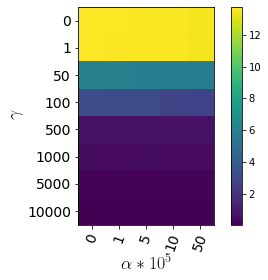

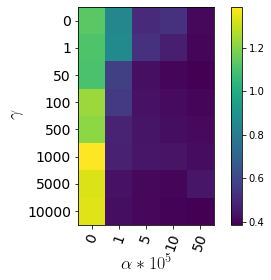

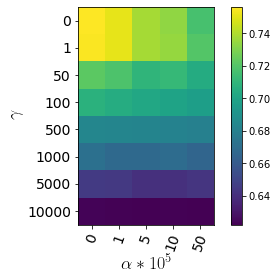

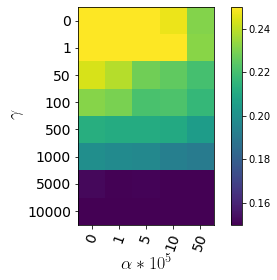

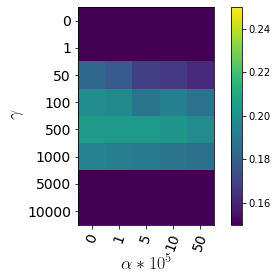

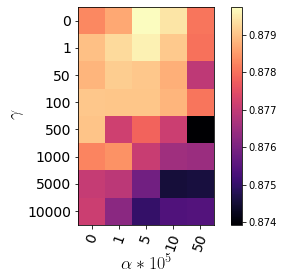

In [54]:
for measure in ['feature_cost', 't_train', 'accuracy']:
    hm = heatmaps[measure]
    plt.imshow(hm, cmap='viridis')
    plt.colorbar()
    plt.xlabel(r'$\alpha * 10^{5}$', fontsize=18, usetex=True)
    plt.ylabel('$\gamma$', fontsize=18, usetex=True)

    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(range(len(alphas)), [int(a*10**7) for a in alphas], rotation=70)
    plt.yticks(range(len(gammas)), gammas)
#    plt.savefig(f'{figure_path}fig_cgeb_{measure}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

for measure in ['b_utility', 'util_minus_cost']:
    hm = heatmaps[measure]
    plt.imshow(hm, cmap='viridis', vmin=.15, vmax=.25)
    plt.colorbar()
    plt.xlabel(r'$\alpha * 10^{5}$', fontsize=18, usetex=True)
    plt.ylabel('$\gamma$', fontsize=18, usetex=True)

    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(range(len(alphas)), [int(a*10**7) for a in alphas], rotation=70)
    plt.yticks(range(len(gammas)), gammas)
#    plt.savefig(f'{figure_path}fig_cgeb_{measure}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

for measure in ['t_utility']:
    hm = heatmaps[measure]
    plt.imshow(hm, cmap='magma')
    plt.colorbar()
    plt.xlabel(r'$\alpha * 10^{5}$', fontsize=18, usetex=True)
    plt.ylabel('$\gamma$', fontsize=18, usetex=True)

    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(range(len(alphas)), [int(a*10**7) for a in alphas], rotation=70)
    plt.yticks(range(len(gammas)), gammas)
#    plt.savefig(f'{figure_path}fig_cgeb_{measure}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

#### 5.5.2.2 Reducing SDR Contexts
Limit to envelope phase and review effect on utility.

In [55]:
# Compute utility over grid of lambda/eta and investigate trade-off between full and envelope
etas = [e/20 for e in range(21)]
lambdas = [l/10 for l in range(8,49,2)]
base_bmin = .20

# Two models: one full, one envelope
clf = LGBMRegressor()
clf.set_params(**lgbm_base_params)
clf.fit(X, yS)
t0 = time()
y_base = clf.predict(X_validation)
base_t_val = time()-t0

Xenv = X.filter(regex='(rdns|helo|envFrom)\.feature\.|(spf)\.(align|pass)', axis=1)
Xenv_validation = X_validation.filter(regex='(rdns|helo|envFrom)\.feature\.|(spf)\.(align|pass)', axis=1)

clf = LGBMRegressor()
clf.set_params(**lgbm_base_params)
clf.fit(Xenv, yS)
t0 = time()
y_envp = clf.predict(Xenv_validation)
envp_t_val = time()-t0
envp_bmin = base_bmin*(envp_t_val/base_t_val)

models = [{'name':'full', 'preds':y_base, 'bmin':base_bmin},
          {'name':'envp', 'preds':y_envp, 'bmin':envp_bmin}]

In [56]:
heatmaps = {}
# Visualize results in a heatmap.
for model in models:
    mname = model['name']
    preds = model['preds']
    bmin = model['bmin']
    hm_utl = -1*np.ones((len(etas), len(lambdas)))
    hm_fpr = -1*np.ones((len(etas), len(lambdas)))
    hm_tpr = -1*np.ones((len(etas), len(lambdas)))
    hm_tcr = -1*np.ones((len(etas), len(lambdas)))
    for col, e in enumerate(etas):
        for row, l in enumerate(lambdas):
            _, best_valid_util = max_util_vals(yV_hot_A_validation, preds,
                                           bmin, e, l,
                                           N_A_validation, P_A_validation, pos_label=1)
            hm_utl[row][col] = best_valid_util[0]
            hm_fpr[row][col] = best_valid_util[2]
            hm_tpr[row][col] = best_valid_util[3]
            hm_tcr[row][col] = best_valid_util[4]

    heatmaps[f'{mname}_utl'] = hm_utl
    heatmaps[f'{mname}_fpr'] = hm_fpr
    heatmaps[f'{mname}_tpr'] = hm_tpr
    heatmaps[f'{mname}_tcr'] = hm_tcr

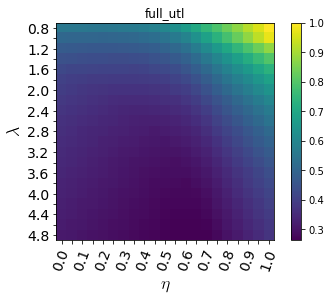

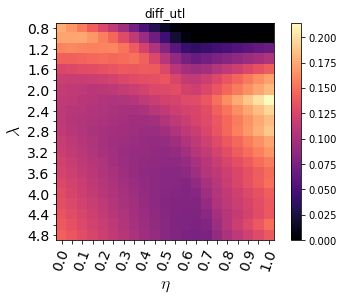

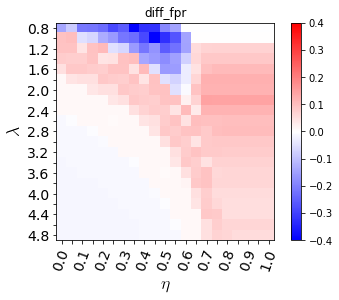

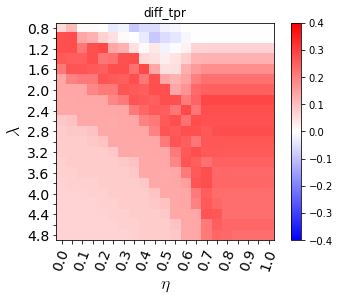

In [57]:
heatmaps['diff_utl'] = heatmaps['full_utl'] - heatmaps['envp_utl']
heatmaps['diff_fpr'] = heatmaps['full_fpr'] - heatmaps['envp_fpr']
heatmaps['diff_tpr'] = heatmaps['full_tpr'] - heatmaps['envp_tpr']

eta_ticks = [str(v)  if not i%2 else '' for i,v in enumerate(etas)]
lambda_ticks = [str(v)  if not i%2 else '' for i,v in enumerate(lambdas)]

for hm_name, hm in heatmaps.items():
    if hm_name not in ['full_utl', 'diff_utl', 'diff_fpr', 'diff_tpr']:
        continue
    if hm_name == 'diff_utl':
        plt.imshow(hm, cmap='magma')
    elif hm_name.endswith('_utl'):
        plt.imshow(hm, cmap='viridis')
    else:
        plt.imshow(hm, cmap='bwr', vmin=-.4, vmax=.4)
    plt.colorbar()
    plt.xlabel(r'$\eta$', fontsize=18, usetex=True)
    plt.ylabel('$\lambda$', fontsize=18, usetex=True)
    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(range(len(etas)), eta_ticks, rotation=70)
    plt.yticks(range(len(lambdas)), lambda_ticks)
#    plt.savefig(f'{figure_path}fig_sdrphase_{hm_name}_{int(100*base_bmin):2d}pct.pdf', bbox_inches='tight', pad_inches=0)
    plt.title(f'{hm_name}')
    plt.show()

In [58]:
yV_hot_C_validation = pd.Series([1 if v=='+' else 0 for v in yV_C_validation])
P_C_validation = sum(yV_hot_C_validation)
N_C_validation = len(yV_hot_C_validation) - P_C_validation
heatmaps_cons = {}
# Visualize results in a heatmap.
for model in models:
    mname = model['name']
    preds = model['preds']
    bmin = model['bmin']
    hm_utl = np.zeros((len(etas), len(lambdas)))
    hm_tpr = np.zeros((len(etas), len(lambdas)))
    hm_tcr = np.zeros((len(etas), len(lambdas)))
    for col, e in enumerate(etas):
        for row, l in enumerate(lambdas):
            _, best_valid_util = max_util_vals(yV_hot_C_validation, preds,
                                           bmin, e, l,
                                           N_C_validation, P_C_validation, pos_label=1)
            hm_utl[row][col] = best_valid_util[0]
            hm_tpr[row][col] = best_valid_util[3]
            hm_tcr[row][col] = best_valid_util[4]

    heatmaps_cons[f'{mname}_utl'] = hm_utl
    heatmaps_cons[f'{mname}_tpr'] = hm_tpr
    heatmaps_cons[f'{mname}_tcr'] = hm_tcr

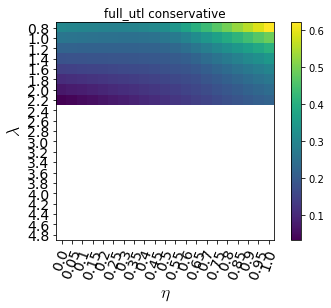

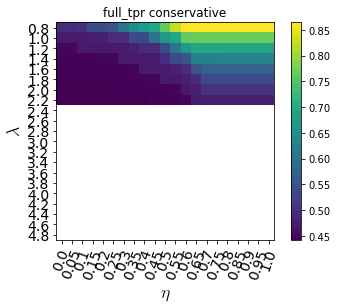

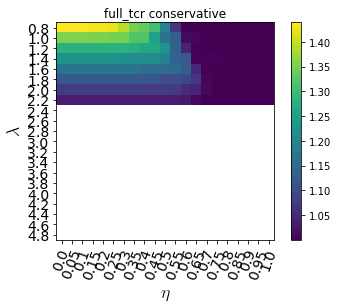

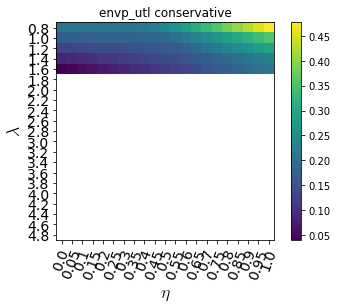

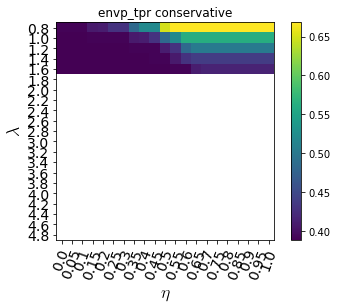

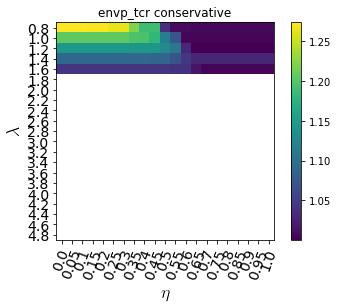

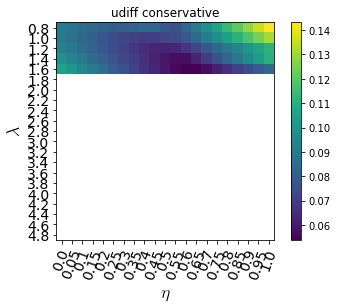

In [59]:
heatmaps_cons['udiff'] = heatmaps_cons['full_utl'] - heatmaps_cons['envp_utl']

for hm_name, hm in heatmaps_cons.items():
#    if hm_name != 'udiff':
#        continue
    plt.imshow(hm, cmap='viridis')#'bwr', vmin=-.2, vmax=.2)
    plt.colorbar()
    plt.xlabel(r'$\eta$', fontsize=18, usetex=True)
    plt.ylabel('$\lambda$', fontsize=18, usetex=True)
    plt.tick_params(axis='both', labelsize=14)
    plt.xticks(range(len(etas)), etas, rotation=70)
    plt.yticks(range(len(lambdas)), lambdas)
#    plt.savefig(f'{figure_path}fig_sdrphase_cons_{hm_name}_{int(100*base_bmin):2d}pct.pdf', bbox_inches='tight', pad_inches=0)
    plt.title(f'{hm_name} conservative')
    plt.show()


## 5.6 Model Interpretation

### 5.6.1 Improving Ground Truth

In [60]:
# (Re-) train a model
rgbm = LGBMRegressor()
rgbm.set_params(**lgbm_base_params)
rgbm.fit(X, yS)
preds = rgbm.predict(X)
shap_tree_explainer = shap.TreeExplainer(rgbm)
shap_values = shap_tree_explainer.shap_values(X)

# Select samples that were assigned a positive verdict
# sum(pos_idx) 9455 for .9, 1660 for .99, 1301 for .999
pos_idx = preds >= .999
pos_pred = preds[pos_idx]
pos_orig = yS[pos_idx]
pos_X = X[pos_idx]
pos_shap = shap_values[pos_idx]

# Form 10 clusters
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=RAND_STATE).fit(pos_shap)

# Compute purity of clusters as the fraction of cluster members that were assigned a positive pipeline verdict
pos_pure = np.zeros(len(pos_orig))
for c in range(n_clusters):
    c_idx = kmeans.labels_ == c
    member_cnt = sum(c_idx)
    frac_lge_90 = sum([s>=.9 for s in pos_orig[c_idx]])/member_cnt
    pos_pure[c_idx] = frac_lge_90
    print(f'Cluster {c:3d}: {member_cnt:3d} members ({100*frac_lge_90:5.2f}% with positive pipeline verdict)')

Cluster   0: 137 members (93.43% with positive pipeline verdict)
Cluster   1:  82 members (95.12% with positive pipeline verdict)
Cluster   2: 147 members (93.88% with positive pipeline verdict)
Cluster   3: 488 members (92.21% with positive pipeline verdict)
Cluster   4:  76 members (89.47% with positive pipeline verdict)
Cluster   5:  41 members (95.12% with positive pipeline verdict)
Cluster   6: 167 members (95.21% with positive pipeline verdict)
Cluster   7:  67 members (100.00% with positive pipeline verdict)
Cluster   8:  30 members (93.33% with positive pipeline verdict)
Cluster   9:  66 members (96.97% with positive pipeline verdict)


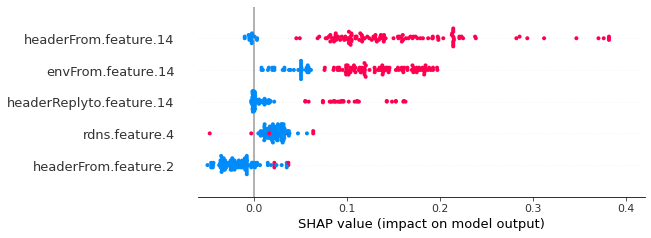

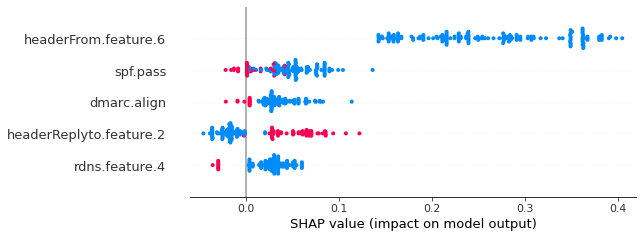

In [61]:
# Create and save summary plots for some clusters
## Not required for saving the graphs "show=False", but consider for inline visualization
#shap.initjs()
for c in [0,6]:
    c_idx = kmeans.labels_ == c
    shap.summary_plot(pos_shap[c_idx], pos_X[c_idx],
                           color_bar=False, show=False, max_display=5)
    plt.xlim(-.06,.42)
#    plt.savefig(f'{figure_path}fig_shap_cluster_{c}.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [62]:
# Print out details for features relevant to selected clusters
yV_hot_A = pd.Series([1 if v=='+' else 0 for v in yV_A])
print(f"{'Feature':25s}& {'prevalence':11s}& {'spam correlation':17s}& {'spam precision':15s}\\\\")
for fn in ['headerFrom.feature.14', 'envFrom.feature.14', 'headerReplyto.feature.14',
           'rdns.feature.4', 'headerFrom.feature.2',
           'headerFrom.feature.6', 'spf.pass', 'dmarc.align', 'headerReplyto.feature.4']:
    prev_A = sum(X[fn])/len(X[fn])
    corr_A = X[fn].corr(yV_hot_A)
    prec_A = precision_score(yV_hot_A, X[fn])
    print(f'{fn:25s}& {prev_A:10.2f} & {corr_A:16.2f} & {prec_A:14.2f} \\\\')

Feature                  & prevalence & spam correlation & spam precision \\
headerFrom.feature.14    &       0.05 &             0.23 &           1.00 \\
envFrom.feature.14       &       0.05 &             0.23 &           1.00 \\
headerReplyto.feature.14 &       0.02 &             0.15 &           1.00 \\
rdns.feature.4           &       0.20 &            -0.15 &           0.35 \\
headerFrom.feature.2     &       0.43 &            -0.12 &           0.44 \\
headerFrom.feature.6     &       0.08 &             0.09 &           0.66 \\
spf.pass                 &       0.80 &            -0.05 &           0.50 \\
dmarc.align              &       0.77 &            -0.01 &           0.51 \\
headerReplyto.feature.4  &       0.04 &             0.05 &           0.62 \\


### 5.6.2 Correlation Of Model Interpretation Measures and Features

In [63]:
# Feature Power implementation
# Also published in package (see import in first cell): 
#   sys.path.insert(0, os.path.abspath('./packages/feature_power'))
#   from feature_power import regrGBM_FP_agg
# Copied in here verbatim to ease review.

from copy import deepcopy
from functools import lru_cache
from gmpy import fac


class FifoList:
    """Fifo, by courtesy of:
https://www.oreilly.com/library/view/python-cookbook/0596001673/ch17s15.html"""

    def __init__(self):
        self.data = {}
        self.nextin = 0
        self.nextout = 0

    def append(self, data):
        self.data[self.nextin] = data
        self.nextin += 1

    def pop(self):
        # Raises KeyError for empty Fifo.
        result = self.data[self.nextout]
        del self.data[self.nextout]
        self.nextout += 1
        return result

    def tolist(self):
        return [self.data[_id] for _id in range(self.nextout, self.nextin)
                if _id in self.data]


def _adjust_response(response,
                     discrimination_threshold,
                     f_0,
                     num_trees):
    return response - discrimination_threshold / num_trees - f_0


def _agg_coalition_space(jgbm,
                         method,
                         first_tree_default_prediction,
                         discrimination_threshold):
    if method not in ['pathPow', 'cumNodePow', 'strictNodePow']:
        raise ValueError('_agg_coalition_space: unknown method')
    # pathPow (root-to-leaf only):
    # coalition: list of internal nodes
    # value: abs of leaf
    # nodePow (root-to-internal):
    # coalition: list of internal nodes
    # value: 1
    trees = jgbm['tree_info']
    num_trees = len(trees)
    gbm_coalitions = []
    gbm_coalition_values = []

    for tree in trees:
        # Prepare data structures.
        subtree_fifo = FifoList()
        tree_number = int(tree['tree_index'])
        tree = deepcopy(tree['tree_structure'])
        f_0 = 0
        if tree_number == 0:
            f_0 = first_tree_default_prediction
        tree_coalitions = []
        tree_coalition_values = []
        while tree:
            coalition = tree.pop('path', [])
            left = tree.pop('left_child', None)
            right = tree.pop('right_child', None)
            internal_node = left and right
            if internal_node:
                split_var_id = tree['split_feature']
                coalition.append(split_var_id)
                if method in ['cumNodePow', 'strictNodePow']:
                    tree_coalitions.append(coalition)
                left['path'] = deepcopy(coalition)
                right['path'] = deepcopy(coalition)
                subtree_fifo.append(left)
                subtree_fifo.append(right)
            else:  # leaf node
                if method == 'pathPow':
                    coalition_value = abs(
                        _adjust_response(tree['leaf_value'],
                                         discrimination_threshold,
                                         f_0,
                                         num_trees))
                    tree_coalitions.append(coalition)
                    tree_coalition_values.append(coalition_value)
            try:
                tree = subtree_fifo.pop()
            except KeyError:
                tree = None

            gbm_coalitions.extend(tree_coalitions)
            if method == 'pathPow':
                gbm_coalition_values.extend(tree_coalition_values)

    # Combine coalitions and values of characteristic functions (summed over all leaves).
    if method == 'pathPow':
        return [(c, v) for c, v in zip(gbm_coalitions, gbm_coalition_values)]
    else:  # nodePow
        return [(c, 1) for c in gbm_coalitions]

    
@lru_cache(1000)  # set to max_tree_depth for full caching
def _coalition_quotient_numerator(coalition_size, num_features, inclusion):
    if inclusion:
        numerator = _lru_fac(coalition_size - 1) * _lru_fac(num_features - coalition_size)
    else:
        numerator = _lru_fac(coalition_size) * _lru_fac(num_features - coalition_size - 1)
    return numerator


@lru_cache(1000)  # set to num_features for full caching
def _lru_fac(x):
    return fac(x)


def _has_same_sign(x, y):
    if x == y == 0:
        return True
    return x * y > 0


def _split_coalition_space(method, coalition_space, feature_id):
    # pathPow
    # In paper: p_pp = [n0,...,ni, leaf_val]
    #           s = d(p_pp) # edges
    # In code:  p_pp = (p=[no,...ni], leaf_val)
    #           s = len(p)
    #
    # nodePow
    # In paper: p_np = [n0,...,ni]
    #           s = d(p_pp)+1 # edges
    # In code:  p_np = (p=[no,...ni], func_over_T_ni)
    #           s = len(p)
    if method == 'pathPow':
        # inclusion: feature in path?
        # inc,exc: s = length of path
        coalition_space_inc = [(len(coalition), value)
                               for coalition, value in coalition_space
                               if feature_id in coalition]
        coalition_space_exc = [(len(coalition), value)
                               for coalition, value in coalition_space
                               if feature_id not in coalition]
    elif method == 'cumNodePow':
        # inclusion: feature in path?
        # inc: s = length up to and including first mention of feature (index + 1)
        # exc: s = length of path
        coalition_space_inc = [(coalition.index(feature_id) + 1, value)
                               for coalition, value in coalition_space
                               if feature_id in coalition]
        coalition_space_exc = [(len(coalition), value)
                               for coalition, value in coalition_space
                               if feature_id not in coalition]
    elif method == 'strictNodePow':
        # inclusion: path ends in feature?
        # inc: s = length up to and including first mention of feature (index + 1)
        # exc: s = length of path
        coalition_space_inc = [(coalition.index(feature_id) + 1, value)
                               for coalition, value in coalition_space
                               if coalition[-1] == feature_id]
        coalition_space_exc = [(len(coalition), value)
                               for coalition, value in coalition_space
                               if coalition[-1] != feature_id]
    else:
        raise ValueError('_coalition_space: unknown method')

    return coalition_space_inc, coalition_space_exc


def regrGBM_FP_agg(jgbm,  # json representation of the model
                   method,  # pathPow, cumNodePow, strictNodePow
                   first_tree_default_prediction,  # f_0
                   discrimination_threshold):  # \rho

    if method not in ['pathPow', 'cumNodePow', 'strictNodePow']:
        raise ValueError('regrGBM_FP_agg: unknown method')

    # Compute coalition space and values of characteristic functions
    # according to "method":
    coalition_space = _agg_coalition_space(jgbm, method,
                             first_tree_default_prediction,
                             discrimination_threshold)
    k = len(coalition_space)

    # Determine Feature Power aggregate for each feature:
    num_features = len(jgbm['feature_names'])
    fp_agg = [0] * num_features
    coalition_quotient_denominator = _lru_fac(num_features)
    for feature_id in range(num_features):
        # Split coalitions in those including and excluding current feature:
        coalition_space_inc, coalition_space_exc = _split_coalition_space(
            method, coalition_space, feature_id)

        # Compute sums over coalitions:
        inc_sum = sum([_coalition_quotient_numerator(coalition_size,
                                                     num_features,
                                                     True) * value
                       for coalition_size, value in coalition_space_inc])
        exc_sum = sum([_coalition_quotient_numerator(coalition_size,
                                                     num_features,
                                                     False) * value
                       for coalition_size, value in coalition_space_exc])
        # Combine into FP by dividing by K:
        fp_agg[feature_id] = float((inc_sum - exc_sum) /
                                   (k * coalition_quotient_denominator))

    # Return vector of aggregate feature power:
    return fp_agg

In [64]:
# Timing tests with and without LRU cache
def test():
    import pandas as pd
    from lightgbm import LGBMRegressor
    from time import time

    # Load data
    fullDF = pr.read_pickle('../data/deduped_dataframe.pkl')
    X = fullDF.filter(regex='feature\.|(spf|dkim|dmarc)\.(align|pass)', axis=1).astype('int')
    yS = fullDF['target_score'].astype('float')

    RAND_STATE = 27
    lgbm_base_params = {'random_state': RAND_STATE,
                        'learning_rate': 0.3,
                        'num_leaves': 31,
                        'n_estimators': 750,
                        'reg_lambda': 1}

    # (Re-) train a model
    rgbm = LGBMRegressor()
    rgbm.set_params(**lgbm_base_params)
    rgbm.fit(X, yS)
    jgbm = rgbm._Booster.dump_model(num_iteration=-1)
    num_features = len(jgbm['feature_names'])

    # Warming up LRU cache
    for i in range(1000):
        _ = _lru_fac(i)

    for inc in [True, False]:
        for cs in range(1, int(num_features/2)):
            _ = _coalition_quotient_numerator(cs, num_features, inc)


    # Feature Power
    first_tree_default_prediction = rgbm.predict(X.iloc[0:1,:], pred_contrib=True)[-1][-1]
    discrimination_threshold = .5  # aggressive

    t0 = time()
    _ = regrGBM_FP_agg(jgbm,       # json representation of the model
                               'pathPow',  # pathPow, cumNodePow, strictNodePow
                               first_tree_default_prediction,  # f_0
                               discrimination_threshold)       # \rho
    print(f'Done with FP_pp, took {int(time()-t0)} seconds')

    t0 = time()
    _ = regrGBM_FP_agg(jgbm,
                               'cumNodePow',
                               first_tree_default_prediction,
                               discrimination_threshold)
    print(f'Done with FP_cn, took {int(time()-t0)} seconds')

    t0 = time()
    _ = regrGBM_FP_agg(jgbm,
                               'strictNodePow',
                               first_tree_default_prediction,
                               discrimination_threshold)
    print(f'Done with FP_sn, took {int(time()-t0)} seconds')

# Actually ran this from a terminal and dedicated the machine to measurements.
# Results of 5 runs summarized bellow:

#No LRU:
#Done with FP_pp, took 322 seconds
#Done with FP_cn, took 370 seconds
#Done with FP_sn, took 343 seconds

#Done with FP_pp, took 302 seconds
#Done with FP_cn, took 367 seconds
#Done with FP_sn, took 338 seconds

#Done with FP_pp, took 302 seconds
#Done with FP_cn, took 375 seconds
#Done with FP_sn, took 355 seconds

#Done with FP_pp, took 304 seconds
#Done with FP_cn, took 370 seconds
#Done with FP_sn, took 342 seconds

#Done with FP_pp, took 294 seconds
#Done with FP_cn, took 367 seconds
#Done with FP_sn, took 342 seconds

#With LRU on fac and _coalition_quotient_numerator
#Done with FP_pp, took 182 seconds
#Done with FP_cn, took 194 seconds
#Done with FP_sn, took 169 seconds

#Done with FP_pp, took 181 seconds
#Done with FP_cn, took 189 seconds
#Done with FP_sn, took 158 seconds

#Done with FP_pp, took 172 seconds
#Done with FP_cn, took 192 seconds
#Done with FP_sn, took 156 seconds

#Done with FP_pp, took 167 seconds
#Done with FP_cn, took 176 seconds
#Done with FP_sn, took 148 seconds

#Done with FP_pp, took 161 seconds
#Done with FP_cn, took 175 seconds
#Done with FP_sn, took 151 seconds

pp_reducts = 1. - sum([182,181,172,167,161])/sum([322,302,302,304,294])
cn_reducts = 1. - sum([194,189,192,176,175])/sum([370,367,375,370,367])
sn_reducts = 1. - sum([169,158,156,148,151])/sum([343,338,355,342,342])
print(f'reduction\npp:{100*pp_reducts:5.2f}\ncn:{100*cn_reducts:5.2f}\nsn:{100*sn_reducts:5.2f}')

pp_speedup = sum([322,302,302,304,294])/sum([182,181,172,167,161])
cn_speedup = sum([370,367,375,370,367])/sum([194,189,192,176,175])
sn_speedup = sum([343,338,355,342,342])/sum([169,158,156,148,151])
print(f'speedup\npp:{pp_speedup:5.2f}\ncn:{cn_speedup:5.2f}\nsn:{sn_speedup:5.2f}')

reduction
pp:43.37
cn:49.92
sn:54.53
speedup
pp: 1.77
cn: 2.00
sn: 2.20


In [65]:
# (Re-) train a model
t0 = time()
rgbm = LGBMRegressor()
rgbm.set_params(**lgbm_base_params)
rgbm.fit(X, yS)
jgbm = rgbm._Booster.dump_model(num_iteration=-1)

# Gathering data:
num_gbm_feat = len(jgbm['feature_names'])
yV_hot_A = pd.Series([1 if v=='+' else 0 for v in yV_A])
P_A = sum(yV_hot_A)
N_A = len(yV_hot_A) - P_A
print(f'Done with preparations, took {int(time()-t0)} seconds')

# Feature Power
first_tree_default_prediction = rgbm.predict(X.iloc[0:1,:], pred_contrib=True)[-1][-1]
discrimination_threshold = .5  # aggressive
t0 = time()
fp_pp_agg = regrGBM_FP_agg(jgbm,       # json representation of the model
                           'pathPow',  # pathPow, cumNodePow, strictNodePow
                           first_tree_default_prediction,  # f_0
                           discrimination_threshold)       # \rho
fp_pp_agg = pd.Series(fp_pp_agg,
                      index=jgbm['feature_names'])
print(f'Done with FP_pp, took {int(time()-t0)} seconds')
fp_pp_agg_z = zscore(fp_pp_agg)
fp_pp_agg_sort_index = np.argsort(fp_pp_agg)

t0 = time()
fp_cn_agg = regrGBM_FP_agg(jgbm,
                           'cumNodePow',
                           first_tree_default_prediction,
                           discrimination_threshold)
fp_cn_agg = pd.Series(fp_cn_agg,
                      index=jgbm['feature_names'])
print(f'Done with FP_cn, took {int(time()-t0)} seconds')
fp_cn_agg_z = zscore(fp_cn_agg)
fp_cn_agg_sort_index = np.argsort(fp_cn_agg)

t0 = time()
fp_sn_agg = regrGBM_FP_agg(jgbm,
                           'strictNodePow',
                           first_tree_default_prediction,
                           discrimination_threshold)
fp_sn_agg = pd.Series(fp_sn_agg,
                      index=jgbm['feature_names'])
print(f'Done with FP_sn, took {int(time()-t0)} seconds')
fp_sn_agg_z = zscore(fp_sn_agg)
fp_sn_agg_sort_index = np.argsort(fp_sn_agg)

# TreeShap
t0 = time()
shap_tree_explainer = shap.TreeExplainer(rgbm)
pred_shap_values = shap_tree_explainer.shap_values(X)
shap_agg = pd.Series(np.absolute(pred_shap_values).mean(axis=0),
                     index=jgbm['feature_names'])
print(f'Done with TreeSHAP, took {int(time()-t0)} seconds')
shap_agg_z = zscore(shap_agg)
shap_agg_sort_index = np.argsort(shap_agg)

# Split and Gain Importance
rgbm.set_params(importance_type='split')
t0 = time()
fi_split = pd.Series(rgbm.feature_importances_,
               index=jgbm['feature_names'])
print(f'Done with FI_split, took {int(time()-t0)} seconds')
fi_split_z = zscore(fi_split)
fi_split_sort_index = np.argsort(fi_split)

rgbm.set_params(importance_type='gain')
t0 = time()
fi_gain = pd.Series(rgbm.feature_importances_,
               index=jgbm['feature_names'])
print(f'Done with FI_gain, took {int(time()-t0)} seconds')
fi_gain_z = zscore(fi_gain)
fi_gain_sort_index = np.argsort(fi_gain)

# Relations with verdicts
t0 = time()
corr_A = X.corrwith(yV_hot_A)
print(f'Done with corr_A, took {int(time()-t0)} seconds')
corr_A_z = zscore(corr_A, nan_policy='omit')
corr_A_sort_index = np.argsort(corr_A)

t0 = time()
prec_A = pd.Series([precision_score(yV_hot_A, X[fn]) for fn in jgbm['feature_names']],
                   index=jgbm['feature_names'])
print(f'Done with prec_A, took {int(time()-t0)} seconds')
prec_A_z = zscore(prec_A)
prec_A_sort_index = np.argsort(prec_A)

t0 = time()
prev = [sum(X[fn]) for fn in jgbm['feature_names']]
max_prev = float(max(prev))
prev = pd.Series([p/max_prev for p in prev],
                 index=jgbm['feature_names'])
print(f'Done with prev, took {int(time()-t0)} seconds')
prev_z = zscore(prev)
prev_sort_index = np.argsort(prev)

Done with preparations, took 2 seconds
Done with FP_pp, took 168 seconds
Done with FP_cn, took 175 seconds
Done with FP_sn, took 151 seconds
Done with TreeSHAP, took 171 seconds
Done with FI_split, took 0 seconds
Done with FI_gain, took 0 seconds
Done with corr_A, took 0 seconds


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Done with prec_A, took 5 seconds
Done with prev, took 1 seconds


([<matplotlib.axis.YTick at 0x14516f430>,
 [Text(0, 0, '$\\Phi_{pow:pp}$'),
  Text(0, 1, '$\\Phi_{pow:cn}$'),
  Text(0, 2, '$\\Phi_{pow:sn}$'),
  Text(0, 3, '$\\Phi_{shap}$'),
  Text(0, 4, '$\\hat{I}_{split}$'),
  Text(0, 5, '$\\hat{I}_{gain}$'),
  Text(0, 6, '$prev$'),
  Text(0, 7, '$corr_{+}$'),
  Text(0, 8, '$prec_{+}$')])

<Figure size 432x288 with 0 Axes>

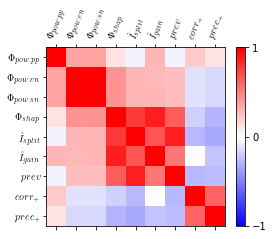

In [66]:
# Overview of how different measures correlate with each other
measures = [
    {'name':'FP_pp', 'label': r'$\Phi_{pow:pp}$', 'values':fp_pp_agg, 'z_scores':fp_pp_agg_z, 'sort_index':fp_pp_agg_sort_index, 'marker':'m^-'},
    {'name':'FP_cn', 'label': r'$\Phi_{pow:cn}$', 'values':fp_cn_agg, 'z_scores':fp_cn_agg_z, 'sort_index':fp_cn_agg_sort_index, 'marker':'m>:'},
    {'name':'FP_sn', 'label': r'$\Phi_{pow:sn}$', 'values':fp_sn_agg, 'z_scores':fp_sn_agg_z, 'sort_index':fp_sn_agg_sort_index, 'marker':'m<--'},
    {'name':'TreeSHAP', 'label': r'$\Phi_{shap}$', 'values':shap_agg, 'z_scores':shap_agg_z, 'sort_index':shap_agg_sort_index, 'marker':'ro-'},
    {'name':'FI_split', 'label': r'$\hat{I}_{split}$', 'values':fi_split, 'z_scores':fi_split_z, 'sort_index':fi_split_sort_index, 'marker':'bP-'},
    {'name':'FI_gain', 'label': r'$\hat{I}_{gain}$', 'values':fi_gain, 'z_scores':fi_gain_z, 'sort_index':fi_gain_sort_index, 'marker':'cX-'},
    {'name':'feat_prev', 'label': r'$prev$', 'values':prev, 'z_scores':prev_z, 'sort_index':prev_sort_index, 'marker':'gx--'},
    {'name':'spam_corr', 'label': r'$corr_{+}$', 'values':corr_A, 'z_scores':corr_A_z, 'sort_index':corr_A_sort_index, 'marker':'g2-'},
    {'name':'spam_prec', 'label': r'$prec_{+}$', 'values':prec_A, 'z_scores':prec_A_z, 'sort_index':prec_A_sort_index, 'marker':'g+:'},
]

mmks = {m['name']:m['marker'] for m in measures}
measure_labels = [m['label'] for m in measures]
measureDF = pd.DataFrame({m['name']:m['values'] for m in measures})
plt.set_cmap('bwr')
plt.matshow(measureDF.corr(), vmin=-1, vmax=1)
cb = plt.colorbar(ticks=[-1,0,1], shrink=.8)
tick_marks = [i for i in range(len(measureDF.columns))]
plt.xticks(tick_marks, measure_labels, usetex=True, rotation=70)
plt.yticks(tick_marks, measure_labels, usetex=True)
#plt.savefig(f'{figure_path}fig_fp_correlation.pdf', bbox_inches='tight', pad_inches=0)

### 5.6.3 Feature Selection Based on Model Interpretation

In [67]:
# Add features, top 1,2,3,...,100,... according to FP, SHAP, and FI.
yV_hot_A_validation = pd.Series([1 if v=='+' else 0 for v in yV_A_validation])
P_A_validation = sum(yV_hot_A_validation)
N_A_validation = len(yV_hot_A_validation) - P_A_validation

# Application constraints (not accounting for differentiated timing here!)
lmbda = 8
eta = .2
base_bmin = .01

# Train and evalute on full feature set for reference:
clf = LGBMRegressor()
clf.set_params(**lgbm_base_params)

clf.fit(X, yS)
t0 = time()
y_pred = clf.predict(X_validation)
base_t_val = time()-t0

feature_names = X.columns
topk_scores = {m['name']:[] for m in measures}

topKs = list(range(1,40))+[50, 70, 100, 120, 150, 170, 200, 230, len(feature_names)]

for topk in topKs:
    topk_feats = {m['name']: [feature_names[i] for i in list(m['sort_index'][-topk:])]
                  for m in measures} 
    for method in topk_feats.keys():
        clf = LGBMRegressor()
        clf.set_params(**lgbm_base_params)
        clf.fit(X[topk_feats[method]], yS)
        Xv = X_validation[topk_feats[method]]
        t0 = time()
        y_pred = clf.predict(Xv)
        t_val = time()-t0

        r2 = r2_score(yS_validation, y_pred)
        auc = roc_auc_score(yV_hot_A_validation, y_pred)

        # Compute utility and related values (adjusted for differing prediction speed)
        bmin = base_bmin*(t_val/base_t_val)
        best_util, best_valid_util = max_util_vals(yV_hot_A_validation, y_pred,
                                                   bmin, eta, lmbda,
                                                   N_A_validation, P_A_validation, pos_label=1)
        utility_val = best_valid_util[0]
        rho_val = best_valid_util[1]
        fpr_val = best_valid_util[2]
        tpr_val = best_valid_util[3]
        tcr_val = best_valid_util[4]
        utility_bst = best_util[0]
        rho_bst = best_util[1]
        fpr_bst = best_util[2]
        tpr_bst = best_util[3]
        tcr_bst = best_util[4]

        # Cmpute stats for classifications producdd in different settings
        y_fix_pred_A = [0 if s<.5 else 1 for s in y_pred]
        _, fpr_fix, _, tpr_fix = confusion_matrix(yV_hot_A_validation, y_fix_pred_A, normalize='all').ravel()
        utility_fix = roc_utility(fpr_fix, tpr_fix, eta, lmbda, N_A_validation, P_A_validation)
        tcr_fix = roc_tcr(fpr_fix, tpr_fix, lmbda, N_A_validation, P_A_validation)

        y_val_pred_A = [0 if s<rho_val else 1 for s in y_pred]
        y_bst_pred_A = [0 if s<rho_bst else 1 for s in y_pred]
        
        acc_val = accuracy_score(yV_hot_A_validation, y_val_pred_A)
        prc_val, rec_val, f1_val, sup_val = precision_recall_fscore_support(yV_hot_A_validation, y_val_pred_A,
                                                                    labels=[1])
        acc_bst = accuracy_score(yV_hot_A_validation, y_bst_pred_A)
        prc_bst, rec_bst, f1_bst, sup_bst = precision_recall_fscore_support(yV_hot_A_validation, y_bst_pred_A,
                                                                    labels=[1])
        acc_fix = accuracy_score(yV_hot_A_validation, y_fix_pred_A)
        prc_fix, rec_fix, f1_fix, sup_fix = precision_recall_fscore_support(yV_hot_A_validation, y_fix_pred_A,
                                                                    labels=[1])

        scores = {
            'utility_val': utility_val, 'tpr_val': tpr_val, 'fpr_val': fpr_val, 'tcr_val': tcr_val, 'rho_val': rho_val,
            'utility_bst': utility_bst, 'tpr_bst': tpr_bst, 'fpr_bst': fpr_bst, 'tcr_bst': tcr_bst, 'rho_bst': rho_bst,
            'utility_fix': utility_fix, 'tpr_fix': tpr_fix, 'fpr_fix': fpr_fix, 'tcr_fix': tcr_fix,
            'r2': r2, 'auc': auc,
            'accuracy_val': acc_val, 'precision_val': prc_val[0], 'recall_val': rec_val[0], 'f1_val': f1_val[0],
            'accuracy_bst': acc_bst, 'precision_bst': prc_bst[0], 'recall_bst': rec_bst[0], 'f1_bst': f1_bst[0],
            'accuracy_fix': acc_fix, 'precision_fix': prc_fix[0], 'recall_fix': rec_fix[0], 'f1_val': f1_fix[0],
        }
        topk_scores[method].append(scores)
        print(f'        {method}: rho (v,b) {rho_val, rho_bst}')

    print(topk, bmin, topk_scores['FP_pp'][-1]['precision_bst'], topk_scores['TreeSHAP'][-1]['precision_bst'])

        FP_pp: rho (v,b) (0.8990281144630864, 0.8990281144630864)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.518426373912942)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.518426373912942)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        TreeSHAP: rho (v,b) (nan, 1.507839231893219)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FI_split: rho (v,b) (nan, 1.4717886335808226)
        FI_gain: rho (v,b) (0.8990281144630864, 0.8990281144630864)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        feat_prev: rho (v,b) (nan, 1.525576029652824)
        spam_corr: rho (v,b) (0.8990281144630864, 0.8990281144630864)
        spam_prec: rho (v,b) (nan, 1.4704619336895552)
1 6.14499705741919e-05 1.0 0.0


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_pp: rho (v,b) (0.8670263849284677, 0.8670263849284677)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.5210038265909454)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.5210038265909454)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        TreeSHAP: rho (v,b) (nan, 1.6453412621341843)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FI_split: rho (v,b) (nan, 1.4778242569951858)
        FI_gain: rho (v,b) (0.8670263849284677, 0.8670263849284677)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        feat_prev: rho (v,b) (nan, 1.5551854062424861)
        spam_corr: rho (v,b) (0.8670263849284677, 0.8670263849284677)
        spam_prec: rho (v,b) (0.741812537537087, 0.741812537537087)
2 0.00014085893748773927 1.0 0.0
        FP_pp: rho (v,b) (0.8394580471204282, 0.8394580471204282)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.5492946626760085)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.5492946626760085)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        TreeSHAP: rho (v,b) (nan, 1.6457877082571954)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FI_split: rho (v,b) (nan, 1.6961651968522844)
        FI_gain: rho (v,b) (0.8167028989550136, 0.8167028989550136)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        feat_prev: rho (v,b) (nan, 1.5677080455220587)
        spam_corr: rho (v,b) (0.8600184109077728, 0.8600184109077728)
        spam_prec: rho (v,b) (0.741812537537087, 0.741812537537087)
3 0.00016570246251448157 1.0 0.0
        FP_pp: rho (v,b) (0.8394577354534735, 0.8394577354534735)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.8284720666845047)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.8284720666845047)
        TreeSHAP: rho (v,b) (0.8291128808564289, 0.8291128808564289)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FI_split: rho (v,b) (nan, 1.7031500858499022)
        FI_gain: rho (v,b) (0.7970561961728723, 0.7970561961728723)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        feat_prev: rho (v,b) (nan, 1.5677080454928944)
        spam_corr: rho (v,b) (0.8600184085964308, 0.8600184085964308)
        spam_prec: rho (v,b) (0.741812537537087, 0.741812537537087)
4 0.0001574854444037295 0.9988597491448119 1.0
        FP_pp: rho (v,b) (0.6778638802431014, 0.6778638802431014)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.8284720666845047)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.8284720666845047)
        TreeSHAP: rho (v,b) (0.8303735966496764, 0.8303735966496764)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FI_split: rho (v,b) (nan, 1.725678369434028)
        FI_gain: rho (v,b) (0.7964703995987145, 0.7964703995987145)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        feat_prev: rho (v,b) (nan, 1.6008760767350116)
        spam_corr: rho (v,b) (0.8592581104097748, 0.8592581104097748)
        spam_prec: rho (v,b) (0.741812537537087, 0.741812537537087)
5 0.00018474225583056656 0.9988649262202043 1.0
        FP_pp: rho (v,b) (0.8670263848462145, 0.8670263848462145)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.8284787280396668)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.8284787280396668)
        TreeSHAP: rho (v,b) (0.8146522222055744, 0.8146522222055744)
        FI_split: rho (v,b) (nan, 0.8242152075890233)
        FI_gain: rho (v,b) (0.7963221207896092, 0.7963221207896092)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        feat_prev: rho (v,b) (nan, 1.7890943669763315)
        spam_corr: rho (v,b) (0.8334751756653102, 0.8334751756653102)
        spam_prec: rho (v,b) (0.741812537537087, 0.741812537537087)
6 0.00016486595526536896 1.0 1.0
        FP_pp: rho (v,b) (0.6778061802269341, 0.6778061802269341)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.8840325565375649)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.8840325565375649)
        TreeSHAP: rho (v,b) (0.7917073967459881, 0.7917073967459881)
        FI_split: rho (v,b) (nan, 0.9166702255206779)
        FI_gain: rho (v,b) (0.7969879875526849, 0.7969879875526849)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        feat_prev: rho (v,b) (nan, 1.8051721775057852)
        spam_corr: rho (v,b) (0.8382139057950274, 0.8382139057950274)
        spam_prec: rho (v,b) (nan, 0.7418125403909579)
7 0.00439401712248909 0.9983193277310924 1.0
        FP_pp: rho (v,b) (0.6778058173609837, 0.6778058173609837)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.8840221820439322)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_sn: rho (v,b) (nan, 1.8840221820439322)
        TreeSHAP: rho (v,b) (0.7861077312823299, 0.7861077312823299)
        FI_split: rho (v,b) (nan, 0.9157176057403481)
        FI_gain: rho (v,b) (0.8164649710172217, 0.8164649710172217)
        feat_prev: rho (v,b) (nan, 0.7979196535717784)
        spam_corr: rho (v,b) (0.7985727376865482, 0.7985727376865482)
        spam_prec: rho (v,b) (nan, 0.7418125403909579)
8 0.004548163940615388 0.9983193277310924 1.0
        FP_pp: rho (v,b) (0.6777819288023413, 0.6777819288023413)


Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


        FP_cn: rho (v,b) (nan, 1.8840322556164881)
        FP_sn: rho (v,b) (0.8945285906575614, 0.8945285906575614)
        TreeSHAP: rho (v,b) (0.7913395944183823, 0.7913395944183823)
        FI_split: rho (v,b) (nan, 0.8024651809008614)
        FI_gain: rho (v,b) (0.8166743781473715, 0.8166743781473715)
        feat_prev: rho (v,b) (nan, 0.9025016580689398)
        spam_corr: rho (v,b) (0.7868049663651777, 0.7868049663651777)
        spam_prec: rho (v,b) (0.7418125405204606, 0.7418125405204606)
9 0.005188521343889611 0.9983193277310924 0.9925742574257426
        FP_pp: rho (v,b) (0.6777951491378567, 0.6777951491378567)
        FP_cn: rho (v,b) (0.8945285903537511, 0.8945285903537511)
        FP_sn: rho (v,b) (0.8945285903537511, 0.8945285903537511)
        TreeSHAP: rho (v,b) (0.7902162228567353, 0.7902162228567353)
        FI_split: rho (v,b) (nan, 0.8023715983973198)
        FI_gain: rho (v,b) (0.7732221822953526, 0.7732221822953526)
        feat_prev: rho (v,b) (0.791730980866886

        FI_gain: rho (v,b) (0.7909275367388945, 0.7909275367388945)
        feat_prev: rho (v,b) (0.8783368552631735, 0.8783368552631735)
        spam_corr: rho (v,b) (0.8039056412455353, 0.8039056412455353)
        spam_prec: rho (v,b) (0.7418125453832277, 0.7418125453832277)
21 0.009693423794559742 0.9953076120959332 0.968434896975011
        FP_pp: rho (v,b) (0.666528314870873, 0.666528314870873)
        FP_cn: rho (v,b) (0.7980412464951919, 0.7980412464951919)
        FP_sn: rho (v,b) (0.7896937184946967, 0.7896937184946967)
        TreeSHAP: rho (v,b) (0.8107572345453121, 0.8107572345453121)
        FI_split: rho (v,b) (0.8460933683219031, 0.8460933683219031)
        FI_gain: rho (v,b) (0.8084104381569366, 0.8084104381569366)
        feat_prev: rho (v,b) (0.8546480135608011, 0.8546480135608011)
        spam_corr: rho (v,b) (0.8031213757846875, 0.8031213757846875)
        spam_prec: rho (v,b) (0.7418125426979537, 0.7418125426979537)
22 0.010311151085793812 0.9949672873678913 0.9652

        spam_corr: rho (v,b) (0.7875778388021355, 0.7875778388021355)
        spam_prec: rho (v,b) (0.4776343584791388, 0.4776343584791388)
33 0.01187696680990928 0.9962779156327544 0.9426723176444345
        FP_pp: rho (v,b) (0.7944865396665474, 0.7944865396665474)
        FP_cn: rho (v,b) (0.8023874508485902, 0.8023874508485902)
        FP_sn: rho (v,b) (0.8023874508485902, 0.8023874508485902)
        TreeSHAP: rho (v,b) (0.7910645126410435, 0.7910645126410435)
        FI_split: rho (v,b) (0.7797621392970789, 0.7797621392970789)
        FI_gain: rho (v,b) (0.795232654380769, 0.795232654380769)
        feat_prev: rho (v,b) (0.8011368460567222, 0.8011368460567222)
        spam_corr: rho (v,b) (0.7855948313732026, 0.7855948313732026)
        spam_prec: rho (v,b) (0.5183693481156385, 0.5183693481156385)
34 0.011179623275629139 0.9962779156327544 0.9464627151051626
        FP_pp: rho (v,b) (0.789431600398928, 0.789431600398928)
        FP_cn: rho (v,b) (0.7943523548631524, 0.7943523548631

        FP_pp: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        FP_cn: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        FP_sn: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        TreeSHAP: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        FI_split: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        FI_gain: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        feat_prev: rho (v,b) (0.7559780272214316, 0.7559780272214316)
        spam_corr: rho (v,b) (0.7520510378138997, 0.7520510378138997)
        spam_prec: rho (v,b) (0.7332264783638287, 0.7332264783638287)
200 0.011012462477467976 0.9633431085043989 0.9633431085043989
        FP_pp: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        FP_cn: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        FP_sn: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        TreeSHAP: rho (v,b) (0.7553691051921035, 0.7553691051921035)
        FI_split: rho (v,b) (0.7553691051921035, 0.75536

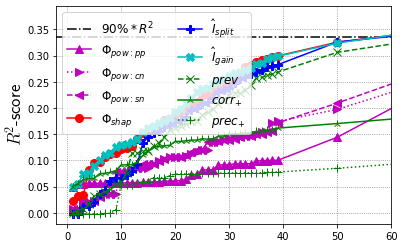

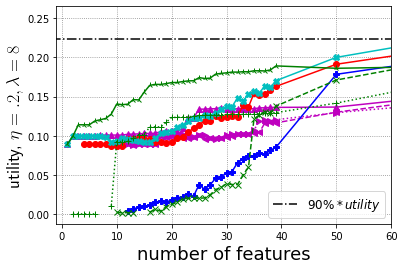

In [68]:
top_r2 = topk_scores['FP_pp'][-1]['r2']
plt.plot([-2,len(feature_names)], [top_r2*.9,top_r2*.9], 'k-.')
for (measure_label, measure_list) in topk_scores.items():
    plt.plot(topKs, [s['r2'] for s in measure_list], mmks[measure_label], markersize=8)
plt.xlim((-2,60))#len(feature_names)))
lgd = [r'$90\% * R^2$'] + measure_labels
plt.legend(lgd, ncol=2, fontsize=12)
plt.ylabel('$R^2$-score', usetex=True, fontsize=18)
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_feat_select_r2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

top_util = topk_scores['FP_pp'][-1]['utility_val']
plt.plot([-2,len(feature_names)], [top_util*.9,top_util*.9], 'k-.')
plt.legend([r'$90\% * utility$'], fontsize=12)
for (measure_label, measure_list) in topk_scores.items():
    plt.plot(topKs, [s['utility_val'] for s in measure_list], mmks[measure_label])
plt.ylabel('utility, $\eta=.2, \lambda=8$', usetex=True , fontsize=18)
#plt.xlim((-2,len(feature_names)))
plt.xlim((-1,60))
plt.xlabel('number of features', fontsize=18)
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_feat_select_utility.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

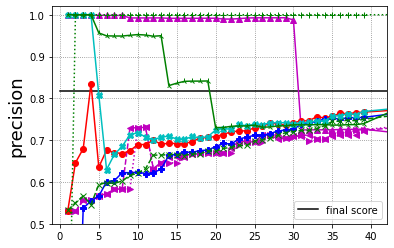

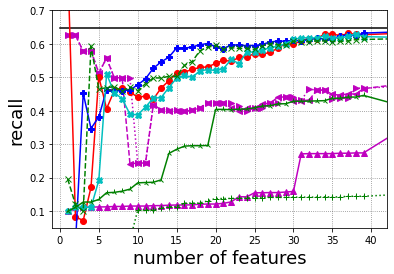

In [69]:
top_score = topk_scores['FP_pp'][-1]['precision_fix']
plt.plot([0,len(feature_names)], [top_score,top_score], 'k-')
plt.legend(['final score'])
for (measure_label, measure_list) in topk_scores.items():
    plt.plot(topKs, [s['precision_fix'] for s in measure_list], mmks[measure_label])
plt.ylabel('precision', fontsize=18)
plt.xlim((-1,42))
plt.ylim((.5,1.02))
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_feat_select_precision.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

top_score = topk_scores['FP_pp'][-1]['recall_fix']
plt.plot([0,len(feature_names)], [top_score,top_score], 'k-')
for (measure_label, measure_list) in topk_scores.items():
    plt.plot(topKs, [s['recall_fix'] for s in measure_list], mmks[measure_label])
plt.ylabel('recall', fontsize=18)
plt.xlim((-1,42))
plt.ylim((.05,.7))
plt.xlabel('number of features', fontsize=18)
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_feat_select_recall.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### 5.6.3.1 Robustness Against Selecting Highly Correlated Features

In [70]:
models = []

gammas = [10]
for gamma in gammas:
    models.append({
        'name': f'cegb_g{gamma:03d}',
        'gamma': gamma})
models.append({
    'name': 'base',
    'p_vals': lgbm_base_params
})

def _add_noise(feature, noise_pct):
    p=noise_pct/100
    if p<=0: # negate feature
        return [f if random()<-1*p else int(not f) for f in feature]
    else:
        return [int(not f) if random()<p else f for f in feature]

In [71]:
#noise_measure_ranked_feats = {mname: {} for mname in models}
# a) For each measure, add noisy copies to best feature and see if they are being picked up.
dummies = [
    {'name': '5x5_inv', 'top_k': 5, 'noise':[n for n in range(5)]+[-1*n for n in range(1,5)]},
    {'name': '45_straight', 'top_k': 1, 'noise':range(1,46)},
]
runs = range(10)

# noise_results[modname][msrname][dummy][run] = {results}
# Storing previous results to avoid re-computation
try:
    noise_results = pickle.load(open('../data/noise_results.pkl', 'rb'))
except FileNotFoundError:
    noise_results = {}

# Initialize if no previous data is available
if not noise_results:
    for mod in models:
        modname = mod['name']
        noise_results[modname] = {}
        for msr in measures:
            msrname = msr['name']
            noise_results[modname][msrname] = {}
            for dum in dummies:
                dumname = dum['name']
                noise_results[modname][msrname][dumname] = [] # list to store runs

In [73]:
seed(RAND_STATE)
for run in runs:
    print(f'starting run {run}')
    tr = time()
    for dum in dummies:
        dumname = dum['name']
        if len(noise_results[models[0]['name']][measures[0]['name']][dumname])>run:
            print(f'  skipping run {run} on dummy {dumname}')
            continue
        print(f'  starting run {run} on dummy {dumname}')
        td = time()
        top_k = -1 * dum['top_k']
        noise = dum['noise']

        for measure in measures:
            msrname = measure['name']
            print(f'    starting run {run} on dummy {dumname} on {msrname}')
            tmsr = time()

            # Create increasingly noisy copies and add them to X
            Xm = X.copy()
            topfeat_ids = measure['sort_index'][top_k:]
            fc = deepcopy(feature_cost_cachesize)
            for fi, topfeat_id in enumerate(topfeat_ids):
                top_feature = feature_names[topfeat_id]
                fc += len(noise)*[feature_cost_cachesize[topfeat_id]]
                for noise_pct in noise:
                    fn = f'noise_{fi:02d}_{noise_pct:04d}'
                    Xm[fn] = _add_noise(X[top_feature], noise_pct)
                    
            for mod in models:
                modname = mod['name']
                if 'gamma' in mod:  # CEGB model
                    # Adjust cegb, noisy features should be as costly as the original
                    noise_cegb_cost = [c*mod['gamma'] for c in fc]
                    cegb_params = {'cegb_penalty_feature_coupled': noise_cegb_cost,
                                   'cegb_penalty_split': 0}
                    cegb_params.update(lgbm_base_params)
                    mod['p_vals'] = cegb_params
            print(f'    created {len(noise)} noisy copies of {top_feature}')
            #print(Xm.shape, len(fc), len(noise), len(topfeat_ids))

            # (Re-) train models, compare cegb and base
            for mod in models:
                modname = mod['name']
                print(f'      starting run {run} on dummy {dumname} on {msrname} on {modname}')
                tmod = time()

                run_results = {'feature_names': Xm.columns}

                rgbm = LGBMRegressor()
                rgbm.set_params(**mod['p_vals'])
                rgbm.fit(Xm, yS)
                jgbm = rgbm._Booster.dump_model(num_iteration=-1)

                if msrname == 'FP_pp':  # Feature Power
                    first_tree_default_prediction = rgbm.predict(Xm.iloc[0:1,:], pred_contrib=True)[-1][-1]
                    discrimination_threshold = .5  # aggressive
                    noise_fp = regrGBM_FP_agg(jgbm,       # json representation of the model
                                               'pathPow',  # pathPow, cumNodePow, strictNodePow
                                               first_tree_default_prediction,  # f_0
                                               discrimination_threshold)       # \rho
                elif msrname == 'FP_cn':
                    first_tree_default_prediction = rgbm.predict(Xm.iloc[0:1,:], pred_contrib=True)[-1][-1]
                    discrimination_threshold = .5  # aggressive
                    noise_fp = regrGBM_FP_agg(jgbm,
                                           'cumNodePow',
                                           first_tree_default_prediction,
                                           discrimination_threshold)
                elif msrname == 'FP_sn':
                    first_tree_default_prediction = rgbm.predict(Xm.iloc[0:1,:], pred_contrib=True)[-1][-1]
                    discrimination_threshold = .5  # aggressive
                    noise_fp = regrGBM_FP_agg(jgbm,
                                           'strictNodePow',
                                           first_tree_default_prediction,
                                           discrimination_threshold)
                elif msrname == 'TreeSHAP':
                    shap_tree_explainer = shap.TreeExplainer(rgbm)
                    pred_shap_values = shap_tree_explainer.shap_values(Xm)
                    noise_fp = pd.Series(np.absolute(pred_shap_values).mean(axis=0),
                             index=jgbm['feature_names'])
                elif msrname == 'FI_split':
                    rgbm.set_params(importance_type='split')
                    noise_fp = pd.Series(rgbm.feature_importances_,
                       index=jgbm['feature_names'])
                elif msrname == 'FI_gain':
                    rgbm.set_params(importance_type='split')
                    noise_fp = pd.Series(rgbm.feature_importances_,
                       index=jgbm['feature_names'])
                elif msrname == 'spam_corr':
                    noise_fp = Xm.corrwith(yV_hot_A)
                elif msrname == 'spam_prec':
                    noise_fp = pd.Series([precision_score(yV_hot_A, Xm[fn]) for fn in jgbm['feature_names']],
                           index=jgbm['feature_names'])
                elif msrname == 'feat_prev':
                    prev = [sum(Xm[fn]) for fn in jgbm['feature_names']]
                    max_prev = float(max(prev))
                    noise_fp = pd.Series([p/max_prev for p in prev],
                         index=jgbm['feature_names'])
                else:
                    raise ValueError('unknown measure')

                noise_fp_sort_index = np.argsort(noise_fp)
                run_results['values'] = noise_fp
                run_results['sort_index'] = noise_fp_sort_index
                noise_results[modname][msrname][dumname].append(run_results)

                print(f'      done with run {run} on dummy {dumname} on {msrname} on {modname}, took {int(time()-tmod)} seconds')
            print(f'    done with run {run} on dummy {dumname} on {msrname}, took {int(time()-tmsr)} seconds')
        print(f'  done with run {run} on dummy {dumname}, took {int(time()-td)} seconds')
    print(f'donew with run {run}, took {int(time()-tr)} seconds')

starting run 0
  skipping run 0 on dummy 5x5_inv
  skipping run 0 on dummy 45_straight
donew with run 0, took 0 seconds
starting run 1
  skipping run 1 on dummy 5x5_inv
  skipping run 1 on dummy 45_straight
donew with run 1, took 0 seconds
starting run 2
  skipping run 2 on dummy 5x5_inv
  skipping run 2 on dummy 45_straight
donew with run 2, took 0 seconds
starting run 3
  skipping run 3 on dummy 5x5_inv
  skipping run 3 on dummy 45_straight
donew with run 3, took 0 seconds
starting run 4
  skipping run 4 on dummy 5x5_inv
  skipping run 4 on dummy 45_straight
donew with run 4, took 0 seconds
starting run 5
  skipping run 5 on dummy 5x5_inv
  skipping run 5 on dummy 45_straight
donew with run 5, took 0 seconds
starting run 6
  skipping run 6 on dummy 5x5_inv
  skipping run 6 on dummy 45_straight
donew with run 6, took 0 seconds
starting run 7
  skipping run 7 on dummy 5x5_inv
  skipping run 7 on dummy 45_straight
donew with run 7, took 0 seconds
starting run 8
  skipping run 8 on dummy

In [74]:
#pickle.dump(noise_results, open('../data/noise_results.pkl', 'wb'))

In [75]:
# Reorganize for ploting
noise_cnts = {}
top_check = -50
for dum in dummies:
    dumname = dum['name']
    noise_cnts[dumname] = {}
    for mod in models:
        modname = mod['name']
        noise_cnts[dumname][modname] = np.zeros((len(runs),len(measure_labels)))

for dum in dummies:
    dumname = dum['name']
    for mod in models:
        modname = mod['name']
        for row,run in enumerate(runs):
            for col,measure in enumerate(measures):
                msrname = measure['name']
                if modname not in noise_results:
                    print(modname)
                    continue
                if msrname not in noise_results[modname]:
                    print(msrname)
                    continue
                if dumname not in noise_results[modname][msrname]:
                    print(dumname)
                    continue
                if run > len(noise_results[modname][msrname][dumname]):
                    print(run)
                    continue
                fns = noise_results[modname][msrname][dumname][run]['feature_names']
                idx = noise_results[modname][msrname][dumname][run]['sort_index']
                nc = sum([fns[i].startswith('noise') for i in idx[top_check:]])
                noise_cnts[dumname][modname][row][col] = nc

In [76]:
dumname = '5x5_inv'
modname = 'base'
msrname = 'feat_prev'
run = 0
fns = noise_results[modname][msrname][dumname][run]['feature_names']
idx = noise_results[modname][msrname][dumname][run]['sort_index']
nc = sum([fns[i].startswith('noise') for i in idx[top_check:]])
print(nc)

39


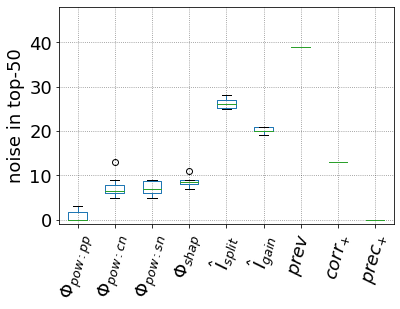

In [77]:
dumname = '5x5_inv'
modname = 'base'
pd.DataFrame(data=noise_cnts[dumname][modname],
             columns=measure_labels).boxplot(grid=False, fontsize=18, rot=75)
plt.ylabel('noise in top-50', fontsize=18)
plt.ylim([-1, 48])
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_noise_{dumname}_{modname}.pdf', bbox_inches='tight', pad_inches=0)

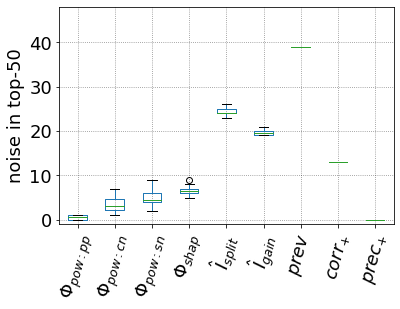

In [78]:
dumname = '5x5_inv'
modname = 'cegb_g010'
pd.DataFrame(data=noise_cnts[dumname][modname],
             columns=measure_labels).boxplot(grid=False, fontsize=18, rot=75)
plt.ylabel('noise in top-50', fontsize=18)
plt.ylim([-1, 48])
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_noise_{dumname}_{modname}.pdf', bbox_inches='tight', pad_inches=0)

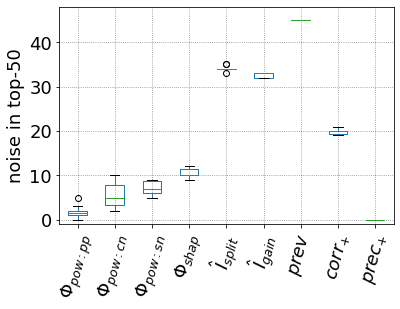

In [79]:
dumname = '45_straight'
modname = 'base'
pd.DataFrame(data=noise_cnts[dumname][modname],
             columns=measure_labels).boxplot(grid=False, fontsize=18, rot=75)
plt.ylabel('noise in top-50', fontsize=18)
plt.ylim([-1, 48])
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_noise_{dumname}_{modname}.pdf', bbox_inches='tight', pad_inches=0)

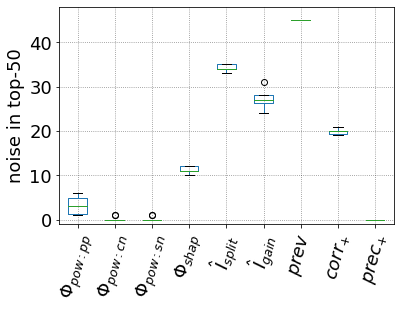

In [80]:
dumname = '45_straight'
modname = 'cegb_g010'
pd.DataFrame(data=noise_cnts[dumname][modname],
             columns=measure_labels).boxplot(grid=False, fontsize=18, rot=75)
plt.ylabel('noise in top-50', fontsize=18)
plt.ylim([-1, 48])
plt.grid(axis='both', color='k', linestyle=':', alpha=.5)
#plt.savefig(f'{figure_path}fig_noise_{dumname}_{modname}.pdf', bbox_inches='tight', pad_inches=0)